# Кластеризация вакансий по навыкам

## Структура
1. **Нормализация данных**
2. **Классификация вакансий**
3. **Кластеризация**
4. **Интеграция LLM**
5. **Оценка качества**


## 1. Нормализация данных

In [55]:
import pandas as pd
from typing import Dict, List, Union, Set, DefaultDict
from collections import defaultdict
import re

In [121]:
# Загрузка данных
file_path = "data/stage_3_df_100s_50p_5.csv"
df = pd.read_csv(file_path)

# Проверка доступных столбцов
print("Доступные столбцы в файле:")
print(df.columns.tolist())

Доступные столбцы в файле:
['position', 'date', 'vacancy', 'company', 'city', 'experience', 'employment', 'schedule', 'salary from', 'salary to', 'currency', 'skills', 'url', 'ID', 'country', 'industry', 'text', 'period of pay', 'level', 'responsibilities', 'requirements', 'education', 'benefits', 'contacts', 'contact', 'experience level', 'skills_llm', 'skills_new', 'skills_list', 'skills_clean', 'skills_clean_norm', 'skills_count', 'vacancy_norm', 'vacancy_info', 'is_it', 'vacancy_norm_llm_check_1', 'experience_norm', 'region', 'salary from norm', 'salary to norm', 'level_copy', 'skills_processed', 'skills_manu', 'vacancy_manu']


In [122]:
# Выбираем наиболее подходящие столбцы 
columns_to_extract = {
    'position': 'position',  # Основная позиция
    'vacancy': 'vacancy',    # Оригинальное название вакансии
    'vacancy_norm': 'vacancy_norm',  # Нормализованное название
    'skills': 'skills_clean_norm',    # Выбираем наиболее обработанную версию скиллов
    'experience': 'experience_norm',  # Нормализованный опыт
    'salary_from': 'salary from norm',
    'salary_to': 'salary to norm',
    'city': 'city',
    'url': 'url'  # Для возможности ручной проверки
}

# Создаем новый DataFrame только с нужными столбцами
result_df = df[list(columns_to_extract.values())].copy()

# Переименовываем столбцы для удобства
result_df.columns = columns_to_extract.keys()

# Анализируем данные
print("Первые 5 строк извлеченных данных:")
print(result_df.head())

print("\nСтатистика по пропущенным значениям:")
print(result_df.isnull().sum())

# Сохраняем результат
output_path = "prepared_vacancies.csv"
result_df.to_csv(output_path, index=False)
print(f"\nДанные сохранены в файл: {output_path}")

# Дополнительно: пример скиллов для проверки
print("\nПримеры скиллов из первых 5 вакансий:")
for i, skills in enumerate(result_df['skills'].head()):
    print(f"{i+1}. {skills}")

Первые 5 строк извлеченных данных:
                       position  \
0  BI-аналитик, аналитик данных   
1  BI-аналитик, аналитик данных   
2  BI-аналитик, аналитик данных   
3  BI-аналитик, аналитик данных   
4  BI-аналитик, аналитик данных   

                                             vacancy  \
0  Разработчик баз данных отдела развития информа...   
1  Аналитик-разработчик отдела развития информаци...   
2                                    Аналитик данных   
3                                    Аналитик данных   
4                                    Аналитик данных   

                                        vacancy_norm  \
0  Разработчик баз данных отдела развития информа...   
1  Аналитик-разработчик отдела развития информаци...   
2                                    Аналитик данных   
3                                    Аналитик данных   
4                                    Аналитик данных   

                                              skills experience  salary_from  \


In [136]:
# Дополнительная предварительная очистка (исправленная версия)
def clean_skills(skill_str):
    if pd.isna(skill_str):
        return skill_str
    # Сначала преобразуем в строку, затем очищаем и приводим к нижнему регистру
    cleaned = re.sub(r'[^\w\s,;/]', '', str(skill_str))
    return cleaned.lower()

# Применяем очистку
result_df['skills'] = result_df['skills'].apply(clean_skills)

In [ ]:
import re
import ast
from typing import Union, List, Dict, Set, Optional, Any
from collections import defaultdict
class FinalSkillNormalizer:
    def __init__(self):
        """Инициализация нормализатора с загрузкой всех правил"""
        self._init_skill_mappings()
        self._init_hierarchy()
        self._init_auto_categorization_rules()
        self._init_stop_skills()
        self._init_special_cases()
        self._build_reverse_index()
        self._init_skill_normalization_rules()

    def _init_skill_normalization_rules(self):
        """Дополнительные правила для нормализации составных навыков"""
        self.skill_normalization_rules = [
            # Разделение навыков с разделителями
            (r'[,;/\\&+]', lambda x: [s.strip() for s in re.split(r'[,;/\\&+]', x) if s.strip()]),
            
            # Обработка версий и скобок
            (r'\([^)]*\)', ''),  # Удаление всего в скобках
            (r'[\d.]+', ''),     # Удаление версий
            
            # Нормализация конкретных случаев
            (r'excel\s*(power\s*(query|pivot))', 'Excel Power Tools'),
            (r'power\s*(bi|query|pivot)', lambda m: f"Power {m.group(1).title()}"),
            (r'html\s*/?\s*css', 'HTML/CSS'),
            (r'sql\s*\w+', 'SQL'),
            (r'python\s*\w+', 'Python'),
            (r'js\b', 'JavaScript'),
            (r'базы?\s*данных', 'Databases')
        ]

    def normalize_skill_item(self, skill: str) -> List[str]:
        """Нормализует отдельный навык, возможно разбивая его на несколько"""
        if not skill or str(skill).lower() in self.stop_skills:
            return []
            
        # Применяем специальные случаи в первую очередь
        skill = self._handle_special_cases(skill.lower())
        
        # Применяем правила нормализации
        for pattern, replacement in self.skill_normalization_rules:
            if isinstance(replacement, str):
                skill = re.sub(pattern, replacement, skill, flags=re.IGNORECASE)
            else:
                skill = replacement(skill)
        
        # Если получили список - нормализуем каждый элемент
        if isinstance(skill, list):
            return [s for item in skill for s in self.normalize_skill_item(item)]
            
        # Базовая очистка
        skill = skill.strip(" .,!?()[]{}«»\"'")
        
        # Применяем маппинг
        normalized = self.skill_map.get(skill, skill.title())
        
        # Дополнительная очистка
        normalized = re.sub(r'\s+', ' ', normalized).strip()
        
        return [normalized] if normalized else []

    def normalize(self, skill_input: Union[str, List[str], None]) -> List[str]:
        """Улучшенная нормализация с обработкой составных навыков"""
        if skill_input is None:
            return []
            
        if isinstance(skill_input, str) and not skill_input.strip():
            return []
            
        # Преобразование ввода в список
        if isinstance(skill_input, str):
            try:
                skills = ast.literal_eval(skill_input) if (
                    '[' in skill_input and ']' in skill_input
                ) else [skill_input.strip()]
            except (ValueError, SyntaxError):
                skills = [skill_input.strip()]
        elif isinstance(skill_input, list):
            skills = skill_input
        else:
            return []
            
        # Нормализация каждого навыка с разбивкой
        normalized = set()
        for skill in skills:
            if not skill or str(skill).lower() in {'nan', 'none', 'null'}:
                continue
                
            # Нормализуем и добавляем все части
            for item in self.normalize_skill_item(skill):
                if item and item not in self.stop_skills:
                    normalized.add(item)
                    
        return sorted(normalized) if normalized else []

    def _init_stop_skills(self):
        """Инициализация списка стоп-слов для игнорирования"""
        self.stop_skills = {
            'nan', 'none', 'нет', 'other', 'другое', 'иное', 
            'разное', 'прочее', 'разные', 'etc', 'и др', 'и другие',
            '', 'не указано', 'not specified'
        }    

    def _init_skill_mappings(self):
        """Полный маппинг 200+ навыков из анализа"""
        self.skill_map = {
            # 1С экосистема (45 навыков)
            '1с': '1C', '1c': '1C',
            '1с программирование': '1C Development',
            '1c программирование': '1C Development',
            '1с: предприятие 8': '1C Enterprise 8',
            '1c: предприятие 8': '1C Enterprise 8',
            '1с:erp': '1C ERP', '1c:erp': '1C ERP',
            '1с:бухгалтерия': '1C Accounting',
            '1с:документооборот': '1C Document Management',
            '1с:зуп': '1C ZUP', '1с:управление торговлей': '1C Trade Management',
            '1с:розница': '1C Retail', '1с:wms': '1C WMS',
            '1с:управление холдингом': '1C Holding Management',
            '1с:кадры': '1C HR', '1с:зарплата': '1C Payroll',
            '1с:документооборот корп': '1C Corporate Document Management',
            '1с:erp 2.5': '1C ERP 2.5', '1с:erp 2.4': '1C ERP 2.4',
            '1с:комплексная автоматизация': '1C Comprehensive Automation',
            '1с:библиотека стандартов': '1C Standards Library',
            '1с:доп': '1C Additional', '1с:документы': '1C Documents',
            '1с:отчеты': '1C Reports', '1с:аналитика': '1C Analytics',
            '1с:консоль запросов': '1C Query Console',
            '1с:обмен данными': '1C Data Exchange',
            '1с:конфигуратор': '1C Configurator',
            '1с:управляемые формы': '1C Managed Forms',
            '1с:скд': '1C Data Composition System',
            '1с:web-сервисы': '1C Web Services',
            '1с:http-сервисы': '1C HTTP Services',
            '1с:rest api': '1C REST API',
            '1с:мобильная платформа': '1C Mobile Platform',
            '1с:лицензии': '1C Licenses', '1с:хакинг': '1C Hacking',
            '1с:оптимизация': '1C Optimization',
            '1с:миграция данных': '1C Data Migration',
            '1с:интеграция': '1C Integration',
            '1с:асинхронные вызовы': '1C Async Calls',
            '1с:расширения': '1C Extensions',
            '1с:внешние компоненты': '1C External Components',
            '1с:отчеты и обработки': '1C Reports and Processing',
            '1с:анализ производительности': '1C Performance Analysis',
            '1с:администрирование': '1C Administration',
            '1с:кластер серверов': '1C Server Cluster',
            '1с:рабочие процессы': '1C Workflows',
            
            # Базы данных (32 навыка)
            'postgresql': 'PostgreSQL', 'postgres': 'PostgreSQL',
            'mysql': 'MySQL', 'mariadb': 'MariaDB',
            'ms sql': 'SQL Server', 'microsoft sql server': 'SQL Server',
            'oracle': 'Oracle', 'oracle db': 'Oracle',
            'sqlite': 'SQLite', 'firebird': 'Firebird',
            'greenplum': 'Greenplum', 'clickhouse': 'ClickHouse',
            'mongodb': 'MongoDB', 'redis': 'Redis',
            'elasticsearch': 'Elasticsearch', 'cassandra': 'Cassandra',
            'hbase': 'HBase', 'hive': 'Hive',
            'sql': 'SQL', 'pl/sql': 'PL/SQL',
            't-sql': 'T-SQL', 'nosql': 'NoSQL',
            'реляционные бд': 'Relational DB', 'sql запросы': 'SQL Queries',
            'оптимизация запросов': 'Query Optimization',
            'индексы': 'Indexes', 'транзакции': 'Transactions',
            'репликация': 'Replication', 'партиционирование': 'Partitioning',
            'бэкапы': 'Backups', 'восстановление': 'Recovery',
            'настройка бд': 'DB Tuning', 'мониторинг бд': 'DB Monitoring',
            
            # Программирование (40 навыков)
            'python': 'Python', 'python 3': 'Python',
            'java': 'Java', 'java ee': 'Java EE',
            'c#': 'C#', 'c++': 'C++',
            'php': 'PHP', 'php 7': 'PHP', 'php 8': 'PHP',
            'javascript': 'JavaScript', 'js': 'JavaScript',
            'typescript': 'TypeScript', 'ts': 'TypeScript',
            'go': 'Go', 'golang': 'Go',
            'scala': 'Scala', 'kotlin': 'Kotlin',
            'ruby': 'Ruby', 'swift': 'Swift',
            'objective-c': 'Objective-C', 'rust': 'Rust',
            'delphi': 'Delphi', 'pascal': 'Pascal',
            'html': 'HTML', 'css': 'CSS',
            'html5': 'HTML5', 'css3': 'CSS3',
            'sass': 'SASS', 'less': 'LESS',
            'web assembly': 'WebAssembly', 'wasm': 'WebAssembly',
            'bash': 'Bash', 'powershell': 'PowerShell',
            'регулярные выражения': 'Regular Expressions',
            'алгоритмы': 'Algorithms', 'структуры данных': 'Data Structures',
            'ооп': 'OOP', 'функциональное программирование': 'Functional Programming',
            'рефакторинг': 'Refactoring', 'паттерны проектирования': 'Design Patterns',
            'чистый код': 'Clean Code', 'тестирование кода': 'Code Testing',
            
            # DevOps (28 навыков)
            'docker': 'Docker', 'kubernetes': 'Kubernetes',
            'openshift': 'OpenShift', 'rancher': 'Rancher',
            'ci/cd': 'CI/CD', 'jenkins': 'Jenkins',
            'gitlab ci': 'GitLab CI', 'github actions': 'GitHub Actions',
            'teamcity': 'TeamCity', 'bamboo': 'Bamboo',
            'ansible': 'Ansible', 'terraform': 'Terraform',
            'puppet': 'Puppet', 'chef': 'Chef',
            'vagrant': 'Vagrant', 'packer': 'Packer',
            'prometheus': 'Prometheus', 'grafana': 'Grafana',
            'zabbix': 'Zabbix', 'elk': 'ELK',
            'splunk': 'Splunk', 'new relic': 'New Relic',
            'datadog': 'Datadog', 'nagios': 'Nagios',
            'мониторинг': 'Monitoring', 'логирование': 'Logging',
            'оркестрация': 'Orchestration', 'инфраструктура как код': 'Infrastructure as Code',
            
            # Системное администрирование (35 навыков)
            'linux': 'Linux', 'ubuntu': 'Ubuntu',
            'centos': 'CentOS', 'debian': 'Debian',
            'red hat': 'Red Hat', 'suse': 'SUSE',
            'windows server': 'Windows Server', 'active directory': 'Active Directory',
            'dns': 'DNS', 'dhcp': 'DHCP',
            'tcp/ip': 'TCP/IP', 'http': 'HTTP',
            'https': 'HTTPS', 'ssl': 'SSL',
            'tls': 'TLS', 'vpn': 'VPN',
            'ldap': 'LDAP', 'kerberos': 'Kerberos',
            'samba': 'Samba', 'nfs': 'NFS',
            'iscsi': 'iSCSI', 'raid': 'RAID',
            'lvm': 'LVM', 'zfs': 'ZFS',
            'btrfs': 'BTRFS', 'виртуализация': 'Virtualization',
            'vmware': 'VMware', 'hyper-v': 'Hyper-V',
            'proxmox': 'Proxmox', 'kvm': 'KVM',
            'xen': 'Xen', 'бэкапы': 'Backups',
            'восстановление данных': 'Data Recovery', 'безопасность': 'Security',
            'аудит': 'Audit',
            
            # Веб-разработка (25 навыков)
            'django': 'Django', 'flask': 'Flask',
            'fastapi': 'FastAPI', 'spring': 'Spring',
            'laravel': 'Laravel', 'symfony': 'Symfony',
            'ruby on rails': 'Ruby on Rails', 'express': 'Express',
            'react': 'React', 'angular': 'Angular',
            'vue': 'Vue', 'svelte': 'Svelte',
            'node.js': 'Node.js', 'nest.js': 'NestJS',
            'rest api': 'REST API', 'graphql': 'GraphQL',
            'soap': 'SOAP', 'grpc': 'gRPC',
            'websocket': 'WebSocket', 'webpack': 'Webpack',
            'gulp': 'Gulp', 'parcel': 'Parcel',
            'веб-разработка': 'Web Development', 'веб-приложения': 'Web Applications',
            'pwa': 'PWA'
        }

    def _init_hierarchy(self):
        """Полная иерархия навыков"""
        self.skill_hierarchy = {
            '1C Ecosystem': {
                'Platform': {
                    '1C', '1C Enterprise 8', '1C ERP', '1C ERP 2.5', '1C ERP 2.4',
                    '1C Accounting', '1C Document Management', '1C ZUP',
                    '1C Trade Management', '1C Retail', '1C WMS',
                    '1C Holding Management', '1C HR', '1C Payroll',
                    '1C Corporate Document Management', '1C Comprehensive Automation',
                    '1C Standards Library'
                },
                'Development': {
                    '1C Development', '1C Data Composition System', '1C Managed Forms',
                    '1C Query Console', '1C Web Services', '1C HTTP Services',
                    '1C REST API', '1C Mobile Platform', '1C Extensions',
                    '1C External Components', '1C Reports and Processing'
                },
                'Administration': {
                    '1C Administration', '1C Server Cluster', '1C Performance Analysis',
                    '1C Licenses', '1C Optimization', '1C Data Migration',
                    '1C Integration', '1C Workflows'
                }
            },
            'Databases': {
                'SQL Databases': {
                    'PostgreSQL', 'MySQL', 'MariaDB', 'SQL Server', 'Oracle',
                    'SQLite', 'Firebird', 'Greenplum', 'ClickHouse', 'PL/SQL', 'T-SQL'
                },
                'NoSQL Databases': {
                    'MongoDB', 'Redis', 'Elasticsearch', 'Cassandra', 'HBase', 'Hive'
                },
                'Database Tools': {
                    'SQL', 'SQL Queries', 'Query Optimization', 'Indexes',
                    'Transactions', 'Replication', 'Partitioning', 'Backups',
                    'Recovery', 'DB Tuning', 'DB Monitoring'
                }
            },
            'Programming': {
                'Languages': {
                    'Python', 'Java', 'Java EE', 'C#', 'C++', 'PHP', 'JavaScript',
                    'TypeScript', 'Go', 'Scala', 'Kotlin', 'Ruby', 'Swift',
                    'Objective-C', 'Rust', 'Delphi', 'Pascal', 'Bash', 'PowerShell'
                },
                'Web Technologies': {
                    'HTML', 'CSS', 'HTML5', 'CSS3', 'SASS', 'LESS', 'WebAssembly'
                },
                'Programming Concepts': {
                    'Algorithms', 'Data Structures', 'OOP', 'Functional Programming',
                    'Refactoring', 'Design Patterns', 'Clean Code', 'Code Testing',
                    'Regular Expressions'
                }
            },
            'DevOps': {
                'Containerization': {
                    'Docker', 'Kubernetes', 'OpenShift', 'Rancher'
                },
                'CI/CD': {
                    'CI/CD', 'Jenkins', 'GitLab CI', 'GitHub Actions', 'TeamCity', 'Bamboo'
                },
                'Infrastructure': {
                    'Ansible', 'Terraform', 'Puppet', 'Chef', 'Vagrant', 'Packer'
                },
                'Monitoring': {
                    'Prometheus', 'Grafana', 'Zabbix', 'ELK', 'Splunk', 'New Relic',
                    'Datadog', 'Nagios', 'Monitoring', 'Logging'
                },
                'DevOps Concepts': {
                    'Orchestration', 'Infrastructure as Code'
                }
            },
            'System Administration': {
                'Operating Systems': {
                    'Linux', 'Ubuntu', 'CentOS', 'Debian', 'Red Hat', 'SUSE',
                    'Windows Server'
                },
                'Network': {
                    'Active Directory', 'DNS', 'DHCP', 'TCP/IP', 'HTTP', 'HTTPS',
                    'SSL', 'TLS', 'VPN', 'LDAP', 'Kerberos'
                },
                'Storage': {
                    'Samba', 'NFS', 'iSCSI', 'RAID', 'LVM', 'ZFS', 'BTRFS'
                },
                'Virtualization': {
                    'Virtualization', 'VMware', 'Hyper-V', 'Proxmox', 'KVM', 'Xen'
                },
                'Security': {
                    'Security', 'Audit', 'Backups', 'Data Recovery'
                }
            },
           'Web Development': {
            'Backend': {
                'Django', 'Flask', 'FastAPI', 'Spring', 'Laravel', 'Symfony',
                'Ruby on Rails', 'Express', 'Node.js', 'NestJS'
            },
            'Frontend': {
                'React', 'Angular', 'Vue', 'Svelte'
            },
            'API': {
                'REST API', 'GraphQL', 'SOAP', 'gRPC', 'WebSocket'
            },
            'Build Tools': {
                'Webpack', 'Gulp', 'Parcel'
            },
            'Concepts': {
                'Web Development', 'Web Applications', 'PWA'
            }
        },  
        'Other': {
            'General': set()
        }
    }

    def _init_auto_categorization_rules(self):
        """Уточненные правила автоматической категоризации"""
        self.auto_category_rules = [
            # Правила для 1С
            (['1с', '1c', '1c:', '1с:', '1c enterprise', '1с предприятие'], '1C Ecosystem'),
            (['erp', 'управление', 'документооборот', 'бухгалтерия', 'зарплата', 'торговля', 'розница', 'wms'], '1C Ecosystem'),
            
            # Правила для баз данных
            (['sql', 'postgres', 'oracle', 'mysql', 'mariadb', 'база данных', 'бд', 'greenplum'], 'Databases'),
            (['mongodb', 'redis', 'elasticsearch', 'nosql', 'cassandra', 'hbase'], 'Databases'),
            
            # Правила для программирования
            (['python', 'java', 'c#', 'c++', 'php', 'javascript', 'typescript', 'go'], 'Programming'),
            (['алгоритм', 'структур данных', 'ооп', 'функциональное', 'рефакторинг', 'паттерн'], 'Programming'),
            
            # Правила для DevOps
            (['docker', 'kubernetes', 'ci/cd', 'ansible', 'terraform', 'prometheus', 'zabbix'], 'DevOps'),
            (['мониторинг', 'логирование', 'оркестрация', 'инфраструктура как код'], 'DevOps'),
            
            # Правила для администрирования
            (['linux', 'windows server', 'ubuntu', 'centos', 'debian'], 'System Administration'),
            (['active directory', 'dns', 'dhcp', 'tcp/ip', 'vpn', 'ldap'], 'System Administration'),
            (['виртуализация', 'vmware', 'hyper-v', 'proxmox', 'kvm'], 'System Administration'),
            (['безопасность', 'аудит', 'бэкап', 'восстановление данных'], 'System Administration'),
            
            # Правила для веб-разработки
            (['django', 'flask', 'spring', 'laravel', 'symfony', 'ruby on rails'], 'Web Development'),
            (['react', 'angular', 'vue', 'svelte', 'node.js', 'nest.js'], 'Web Development'),
            (['rest api', 'graphql', 'soap', 'grpc', 'websocket'], 'Web Development'),
            (['веб-разработка', 'веб-приложения', 'pwa', 'html', 'css'], 'Web Development'),
            
            # Общие правила
            (['администрирование', 'настройка', 'установка'], 'System Administration'),
            (['разработка', 'программирование', 'код'], 'Programming'),
            (['тестирование', 'qa'], 'Testing'),
            (['дизайн', 'ui', 'ux', 'photoshop', 'figma'], 'Design')
        ]

    def _init_special_cases(self):
        """Обработка специальных случаев"""
        self.special_cases = {
            # Версии 1С
            r'1[сc]:?erp\s*[\d.]+': lambda m: f"1C ERP {m.group(0).split()[-1]}",
            r'1[сc]:?(?:управление|торговля)\s*[\d.]+': lambda m: f"1C Trade Management {m.group(0).split()[-1]}",
            
            # Версии ПО
            r'(python|java|php)\s*[\d.]+': lambda m: f"{m.group(1).capitalize()}",
            r'(postgresql|mysql|sql server)\s*[\d.]+': lambda m: f"{m.group(1)}",
            
            # Специальные форматы
            r'c\/c\+\+': 'C++',
            r'js\/ts': 'JavaScript/TypeScript',
            r'html\/css': 'HTML/CSS',
            
            # Иностранные языки
            r'английский\s*(?:язык)?\s*(?:\(.*\))?': 'English',
            r'немецкий\s*(?:язык)?\s*(?:\(.*\))?': 'German'
        }

    def _handle_special_cases(self, skill: str) -> str:
        """Обработка специальных случаев"""
        for pattern, replacement in self.special_cases.items():
            if isinstance(replacement, str):
                if re.search(pattern, skill, re.IGNORECASE):
                    return replacement
            else:
                match = re.search(pattern, skill, re.IGNORECASE)
                if match:
                    return replacement(match)
        return skill

    def normalize(self, skill_input: Union[str, List[str], None]) -> List[str]:
        """Улучшенная нормализация с обработкой специальных случаев"""
        
        # Добавляем обработку специальных случаев
        normalized_skill = self._handle_special_cases(skill_clean)
        

    def _build_reverse_index(self):
        """Расширенный обратный индекс с учетом всех навыков"""
        self.reverse_index = defaultdict(set)
        
        # Индексируем иерархию
        for category, groups in self.skill_hierarchy.items():
            for group, skills in groups.items():
                for skill in skills:
                    self.reverse_index[skill].add(category)
        
        # Индексируем skill_map (включая оригинальные и нормализованные)
        for original, normalized in self.skill_map.items():
            self.reverse_index[normalized].update(self.reverse_index.get(original, set()))
            if original != normalized:
                self.reverse_index[original].update(self.reverse_index.get(normalized, set()))

    def get_categories(self, skill: str) -> List[str]:
        """Получение категорий с учетом специальных случаев"""
        # Сначала проверяем специальные случаи
        processed_skill = self._handle_special_cases(skill)
        
        # Затем ищем в обратном индексе
        categories = self.reverse_index.get(processed_skill, set())
        
        # Если не нашли, пытаемся автоматически определить
        if not categories:
            categories = set(self._auto_categorize_skill(processed_skill))
        
        return list(categories)

    def normalize_with_hierarchy(self, skills_input: Union[str, List[str], None]) -> Dict[str, Dict]:
        """Полная нормализация с иерархией и специальными случаями"""
        normalized_skills = self.normalize(skills_input)
        result = defaultdict(lambda: defaultdict(set))
        
        for skill in normalized_skills:
            # Обрабатываем специальные случаи
            processed_skill = self._handle_special_cases(skill)
            
            # Получаем категории
            categories = self.get_categories(processed_skill)
            
            # Добавляем в результат
            for category in categories:
                related = self.get_related_skills(processed_skill, category)
                result[category][processed_skill].update(rel for rel in related if rel != processed_skill)
        
        # Сортируем результат для удобства
        return {
            category: {
                skill: sorted(related) 
                for skill, related in sorted(skills.items())
            }
            for category, skills in sorted(result.items())
        }
    
    def normalize(self, skill_input: Union[str, List[str], None]) -> List[str]:
        """Исправленная нормализация с обработкой всех случаев"""
        if skill_input is None or (isinstance(skill_input, (list, str)) and not skill_input):
            return []
            
        # Преобразование ввода в список
        if isinstance(skill_input, str):
            try:
                skills = ast.literal_eval(skill_input) if ('[' in skill_input and ']' in skill_input) else [s.strip() for s in skill_input.split(',')]
            except:
                skills = [skill_input.strip()]
        elif isinstance(skill_input, list):
            skills = skill_input
        else:
            return []
            
        normalized = set()
        for skill in skills:
            if not skill or str(skill).lower() == 'nan':
                continue
                
            # Очистка и приведение к нижнему регистру (переименовано в skill_cleaned)
            skill_cleaned = str(skill).strip(" .,!?()[]{}«»\"'").lower()
            
            # Обработка специальных случаев
            processed_skill = self._handle_special_cases(skill_cleaned)
            
            # Пропуск стоп-слов
            if processed_skill in self.stop_skills:
                continue
                
            # Применение маппинга
            normalized_skill = self.skill_map.get(processed_skill, processed_skill)
            
            # Форматирование
            if normalized_skill not in self.skill_map.values():
                normalized_skill = normalized_skill.title()
                
            normalized.add(normalized_skill)
            
        return sorted(normalized) if normalized else []
    
    def _auto_categorize_skill(self, skill: str) -> List[str]:
        """Автоматическое определение категорий навыка на основе ключевых слов"""
        skill_lower = skill.lower()
        categories = set()
    
    # Правила для автоматической категоризации
        auto_rules = {
            '1C Ecosystem': ['1c', '1с', 'erp', 'бухгалтерия', 'документооборот', 'зарплата'],
            'Databases': ['sql', 'база данных', 'postgres', 'oracle', 'mysql', 'mongodb', 'redis'],
            'Programming': ['python', 'java', 'c#', 'c++', 'алгоритм', 'структур данных', 'ооп'],
            'DevOps': ['docker', 'kubernetes', 'ci/cd', 'ansible', 'terraform', 'мониторинг'],
            'System Administration': ['linux', 'windows server', 'active directory', 'dns', 'безопасность'],
            'Web Development': ['django', 'flask', 'react', 'angular', 'веб-разработка', 'html', 'css'],
            'Testing': ['тестирование', 'qa', 'автотесты', 'unit test'],
            'Design': ['дизайн', 'ui', 'ux', 'figma', 'photoshop']
        }
    
        # Проверяем каждую категорию на соответствие
        for category, keywords in auto_rules.items():
            if any(keyword in skill_lower for keyword in keywords):
                categories.add(category)
    
        # Дополнительные эвристики
        if not categories:
            if 'администрирование' in skill_lower:
                categories.add('System Administration')
            elif 'разработка' in skill_lower or 'программирование' in skill_lower:
                categories.add('Programming')
            elif 'анализ' in skill_lower or 'аналитик' in skill_lower:
                categories.add('Analytics')
    
        return list(categories) if categories else ['Other'] 

In [170]:
# Проверка и инициализация нормализатора
if 'OptimizedSkillNormalizer' not in globals():
    raise ImportError("Класс OptimizedSkillNormalizer не найден. Убедитесь, что он определен.")
    
skill_normalizer = FinalSkillNormalizer()
print("Нормализатор готов. Пример маппинга для 'python':", 
      list(skill_normalizer.skill_map.items())[:3])

# Применение к DataFrame
result_df['skills_normalized'] = result_df['skills_cleaned'].apply(
    lambda x: skill_normalizer.normalize(x) if pd.notna(x) else []
)

# Добавление категорий
result_df['skill_categories'] = result_df['skills_normalized'].apply(
    lambda skills: list({cat for skill in skills for cat in skill_normalizer.get_categories(skill)}) if skills else [])

Нормализатор готов. Пример маппинга для 'python': [('1с', '1C'), ('1c', '1C'), ('1с программирование', '1C Development')]


In [171]:

# Анализ результатов
print("\nСтатистика после нормализации:")
print(f"Всего вакансий: {len(result_df)}")
print(f"Вакансий с навыками: {result_df['skills_normalized'].apply(bool).sum()}")

all_skills = [skill for sublist in result_df['skills_normalized'] for skill in sublist]
unique_skills_count = len(set(all_skills))
print(f"Уникальных навыков после нормализации: {unique_skills_count}")


Статистика после нормализации:
Всего вакансий: 11048
Вакансий с навыками: 11048
Уникальных навыков после нормализации: 27779


In [161]:
#  Примеры до и после нормализации
print("\nПримеры нормализации (первые 5 вакансий):")
for i, row in result_df.head().iterrows():
    print(f"\nВакансия #{i+1}: {row['vacancy']}")
    print(f"Оригинальные навыки: {row['skills']}")
    print(f"Нормализованные навыки: {row['skills_normalized']}")
    print(f"Категории навыков: {row['skill_categories']}")

#  Сохранение результатов
output_path_normalized = "normalized_vacancies.csv"
result_df.to_csv(output_path_normalized, index=False)
print(f"\nДанные с нормализованными навыками сохранены в файл: {output_path_normalized}")


Примеры нормализации (первые 5 вакансий):

Вакансия #1: Разработчик баз данных отдела развития информационных систем (Сивиллы)
Оригинальные навыки: sql postgresql, sqlite, python, проектирование и реализация архитектур хранения и обработки больших объемов данных
Нормализованные навыки: ['Python', 'SQLite', 'Sql Postgresql', 'Проектирование И Реализация Архитектур Хранения И Обработки Больших Объемов Данных']
Категории навыков: ['Other', 'Databases', 'Programming']

Вакансия #2: Аналитик-разработчик отдела развития информационных систем (Сивиллы)
Оригинальные навыки: sql, html css, python pandas, scipy, js
Нормализованные навыки: ['Html Css', 'JavaScript', 'Python Pandas', 'SQL', 'Scipy']
Категории навыков: ['Web Development', 'Other', 'Databases', 'Programming']

Вакансия #3: Аналитик данных
Оригинальные навыки: power query, python, power bi, excel, sql, базы данных, power pivot, системы управления проектами
Нормализованные навыки: ['Excel', 'Power Bi', 'Power Pivot', 'Power Query', '

In [162]:
# Проверим структуру нормализованных данных
print("Тип данных в skills_normalized:", type(result_df['skills_normalized'].iloc[0]))
print("Примеры нормализованных навыков:")
for i in range(3):
    print(f"{i+1}. {result_df['skills_normalized'].iloc[i]}")

# Анализ распределения навыков
from collections import Counter

# Собираем все навыки в один список
all_skills = [skill for sublist in result_df['skills_normalized'] for skill in sublist]
skill_counts = Counter(all_skills)

# Топ-20 самых частых навыков
print("\nТоп-20 самых популярных навыков:")
for skill, count in skill_counts.most_common(20):
    print(f"{skill}: {count}")

#  Анализ длины списков навыков
result_df['skills_count'] = result_df['skills_normalized'].apply(len)
print("\nРаспределение количества навыков на вакансию:")
print(result_df['skills_count'].describe())

#  Поиск потенциальных дубликатов (разные написания)
print("\nПотенциальные дубликаты (примеры):")
sample_skills = sorted(skill_counts.keys())[:100]  # Первые 100 навыков для примера
for skill in sample_skills:
    similar = [s for s in skill_counts.keys() if s != skill and skill.lower() in s.lower()]
    if similar:
        print(f"{skill} ~ {similar[:3]}...")  # Показываем первые 3 похожих

Тип данных в skills_normalized: <class 'list'>
Примеры нормализованных навыков:
1. ['Python', 'SQLite', 'Sql Postgresql', 'Проектирование И Реализация Архитектур Хранения И Обработки Больших Объемов Данных']
2. ['Html Css', 'JavaScript', 'Python Pandas', 'SQL', 'Scipy']
3. ['Excel', 'Power Bi', 'Power Pivot', 'Power Query', 'Python', 'SQL', 'Базы Данных', 'Системы Управления Проектами']

Топ-20 самых популярных навыков:
SQL: 1014
Git: 1013
1C: 942
PostgreSQL: 872
Linux: 835
Python: 791
Excel: 670
Docker: 646
JavaScript: 617
Figma: 542
English: 514
Adobe Photoshop: 503
DNS: 461
MySQL: 458
Adobe Illustrator: 422
HTML: 421
Ms Office: 414
DHCP: 409
PHP: 404
CSS: 388

Распределение количества навыков на вакансию:
count    11048.000000
mean         9.050507
std          5.581849
min          1.000000
25%          5.000000
50%          8.000000
75%         12.000000
max         47.000000
Name: skills_count, dtype: float64

Потенциальные дубликаты (примеры):
0 ~ ['Указ Президента Рф 250', 'Owa

In [172]:
def postprocess_skills(normalized_skills: list) -> list:
    """
    Дополнительная обработка уже нормализованных навыков
    """
    skill_corrections = {
        'Sql Postgresql': 'PostgreSQL',
        'Python Pandas': 'Python',
        'Scipy': 'Python',
        'Excel Power Query': 'Power Query',
        'Базы Данных': 'Databases',
        'Системы Управления Проектами': 'Project Management',
        'Проектирование И Реализация Архитектур Хранения И Обработки Больших Объемов Данных': 'Data Architecture'
    }
    
    return [skill_corrections.get(skill, skill) for skill in normalized_skills if skill]

In [173]:
# Применяем пост-обработку к уже нормализованным навыкам
result_df['skills_postprocessed'] = result_df['skills_normalized'].apply(postprocess_skills)

# Просмотрим первые 5 результатов
result_df[['skills_normalized', 'skills_postprocessed']].head()

,skills_normalized,skills_postprocessed
0,"[Python, SQLite, Sql Postgresql, Проектировани...","[Python, SQLite, PostgreSQL, Data Architecture]"
1,"[Html Css, JavaScript, Python Pandas, SQL, Scipy]","[Html Css, JavaScript, Python, SQL, Python]"
2,"[Excel, Power Bi, Power Pivot, Power Query, Py...","[Excel, Power Bi, Power Pivot, Power Query, Py..."
3,"[Excel Power Query, Power Bi, Power Pivot, Pyt...","[Power Query, Power Bi, Power Pivot, Python, S..."
4,"[Excel Power Query, Power Bi, Power Pivot, Pyt...","[Power Query, Power Bi, Power Pivot, Python, S..."


In [174]:
def categorize_skills(postprocessed_skills: list) -> dict:
    """
    Категоризация постобработанных навыков без изменения оригинального нормализатора
    """
    category_mapping = {
        # Программирование
        'Python': 'Programming',
        'JavaScript': 'Programming',
        'SQL': 'Programming',
        # Базы данных
        'PostgreSQL': 'Databases',
        'SQLite': 'Databases',
        'Databases': 'Databases',
        # Data Analysis
        'Power BI': 'Data Analysis',
        'Power Pivot': 'Data Analysis',
        'Power Query': 'Data Analysis',
        'Excel': 'Data Analysis',
        # Управление
        'Project Management': 'Management',
        # Архитектура
        'Data Architecture': 'Architecture'
    }
    
    categories = defaultdict(list)
    for skill in postprocessed_skills:
        if skill in category_mapping:
            categories[category_mapping[skill]].append(skill)
        else:
            categories['Other'].append(skill)
    
    return dict(categories)
# Добавляем категории к постобработанным навыкам
result_df['improved_categories'] = result_df['skills_postprocessed'].apply(categorize_skills)

# Пример просмотра результатов
result_df[['skills_postprocessed', 'improved_categories']].head()
# Проверим распределение категорий
from collections import Counter

category_counts = Counter()
for categories in result_df['improved_categories']:
    for category in categories:
        category_counts[category] += 1

print("Распределение категорий:")
category_counts.most_common()

Распределение категорий:


[('Other', 11032),
 ('Programming', 1991),
 ('Databases', 1012),
 ('Data Analysis', 711),
 ('Management', 7),
 ('Architecture', 1)]

In [175]:
# Дополнительная очистка дубликатов в skills_postprocessed
def remove_skill_duplicates(skills_list):
    return list(set(skills_list))

result_df['skills_cleaned'] = result_df['skills_postprocessed'].apply(remove_skill_duplicates)

In [176]:
# Уточненная категоризация (расширяем без изменения оригинала)
def enhanced_categorization(skills):
    extended_categories = {
        'Python': 'Programming/Python',
        'JavaScript': 'Programming/JavaScript',
        'SQL': 'Databases/SQL',
        'PostgreSQL': 'Databases/PostgreSQL',
        'Power BI': 'Data Analysis/BI Tools',
        'Power Query': 'Data Analysis/BI Tools',
        'Data Architecture': 'Architecture/Data',
        'Project Management': 'Management/Projects'
    }
    
    categories = defaultdict(list)
    for skill in skills:
        if skill in extended_categories:
            category = extended_categories[skill]
            main_category = category.split('/')[0]
            categories[main_category].append(category)
        else:
            categories['Other/Uncategorized'].append(skill)
    
    return dict(categories)

result_df['detailed_categories'] = result_df['skills_cleaned'].apply(enhanced_categorization)

In [177]:
# Анализ результатов новой категоризации
from collections import Counter

category_stats = Counter()
for row in result_df['detailed_categories']:
    for main_category in row:
        category_stats[main_category] += 1

print("Улучшенное распределение категорий:")
category_stats.most_common()

Улучшенное распределение категорий:


[('Other/Uncategorized', 11043),
 ('Databases', 1708),
 ('Programming', 1327),
 ('Data Analysis', 60),
 ('Management', 7),
 ('Architecture', 1)]

In [178]:
extended_category_map = {
    # Программирование
    'Python': 'Programming/Python',
    'JavaScript': 'Programming/JavaScript',
    'Java': 'Programming/Java',
    'C++': 'Programming/C++',
    
    # Базы данных
    'SQL': 'Databases/SQL',
    'PostgreSQL': 'Databases/PostgreSQL', 
    'MySQL': 'Databases/MySQL',
    'SQLite': 'Databases/SQLite',
    
    # BI и Аналитика
    'Power BI': 'Data Analysis/BI Tools',
    'Power Query': 'Data Analysis/BI Tools',
    'Power Pivot': 'Data Analysis/BI Tools',
    'Excel': 'Data Analysis/Spreadsheets',
    
    # Управление
    'Project Management': 'Management/Projects',
    'Agile': 'Management/Agile',
    
    # Архитектура
    'Data Architecture': 'Architecture/Data',
    'System Architecture': 'Architecture/System'
}

def enhanced_categorization_v2(skills):
    categories = defaultdict(list)
    for skill in skills:
        # Сначала проверяем полное совпадение
        if skill in extended_category_map:
            category = extended_category_map[skill]
            main_category = category.split('/')[0]
            categories[main_category].append(category)
        else:
            # Проверяем частичное совпадение (например "Python" в "Python Django")
            matched = False
            for key in extended_category_map:
                if key in skill:
                    category = extended_category_map[key]
                    main_category = category.split('/')[0]
                    categories[main_category].append(category)
                    matched = True
                    break
            if not matched:
                categories['Other/Uncategorized'].append(skill)
    
    return dict(categories)

result_df['detailed_categories_v2'] = result_df['skills_cleaned'].apply(enhanced_categorization_v2)

In [180]:
# Собираем все неклассифицированные навыки
uncategorized = []
for row in result_df['detailed_categories_v2']:
    if 'Other/Uncategorized' in row:
        uncategorized.extend(row['Other/Uncategorized'])
        
# Топ-20 самых частых неклассифицированных навыков
from collections import Counter
print("Топ-20 неклассифицированных навыков:")
Counter(uncategorized).most_common(30)

Топ-20 неклассифицированных навыков:


[('Git', 1013),
 ('1C', 942),
 ('Linux', 835),
 ('Docker', 646),
 ('Figma', 542),
 ('English', 514),
 ('Adobe Photoshop', 503),
 ('DNS', 461),
 ('Adobe Illustrator', 422),
 ('HTML', 421),
 ('Ms Office', 414),
 ('DHCP', 409),
 ('PHP', 404),
 ('CSS', 388),
 ('C', 376),
 ('Photoshop', 361),
 ('REST API', 335),
 ('Windows', 332),
 ('Jira', 315),
 ('TCP/IP', 312),
 ('Zabbix', 299),
 ('Скд', 287),
 ('TypeScript', 282),
 ('Redis', 279),
 ('Active Directory', 268),
 ('Коммуникабельность', 265),
 ('OOP', 249),
 ('CI/CD', 240),
 ('Coreldraw', 240),
 ('Bash', 239)]

In [181]:
def postprocess_categories(categories):
    # Объединяем похожие подкатегории
    processed = defaultdict(list)
    for main_cat, subcats in categories.items():
        if main_cat == 'Data Analysis':
            processed['BI & Analytics'].extend(subcats)
        elif main_cat == 'Programming':
            processed['Software Development'].extend(subcats)
        elif main_cat == 'Architecture':
            processed['System Design'].extend(subcats)
        else:
            processed[main_cat].extend(subcats)
    
    # Удаляем дубликаты
    return {k: list(set(v)) for k, v in processed.items()}

result_df['final_categories'] = result_df['detailed_categories_v2'].apply(postprocess_categories)

In [182]:
category_stats = Counter()
for row in result_df['final_categories']:
    for main_category in row:
        category_stats[main_category] += 1

print("Улучшенное распределение категорий:")
category_stats.most_common()

Улучшенное распределение категорий:


[('Other/Uncategorized', 11024),
 ('Databases', 2104),
 ('Software Development', 1721),
 ('BI & Analytics', 1141),
 ('Management', 188),
 ('System Design', 1)]

In [183]:
enhanced_category_mapping = {
    # Системное администрирование
    'Linux': 'System Administration/Linux',
    'Windows': 'System Administration/Windows',
    'DNS': 'Networking/DNS',
    'DHCP': 'Networking/DHCP',
    'TCP/IP': 'Networking/TCP-IP',
    'Active Directory': 'System Administration/AD',
    'Zabbix': 'Monitoring/Zabbix',
    
    # DevOps
    'Docker': 'DevOps/Containerization',
    'Git': 'DevOps/Version Control',
    'CI/CD': 'DevOps/CI-CD',
    'Bash': 'DevOps/Scripting',
    
    # Программирование
    'PHP': 'Programming/PHP',
    'C': 'Programming/C',
    'TypeScript': 'Programming/TypeScript',
    'OOP': 'Programming/OOP',
    'REST API': 'Programming/API',
    
    # Дизайн
    'Figma': 'Design/UI-UX',
    'Adobe Photoshop': 'Design/Graphics',
    'Adobe Illustrator': 'Design/Graphics',
    'Photoshop': 'Design/Graphics',
    'Coreldraw': 'Design/Graphics',
    'HTML': 'Web Development/HTML',
    'CSS': 'Web Development/CSS',
    
    # Управление
    'Jira': 'Management/Project Tracking',
    'Коммуникабельность': 'Soft Skills/Communication',
    
    # 1С
    '1C': 'ERP/1C',
    'Скд': 'ERP/1C-SKD',
    
    # Базы данных
    'Redis': 'Databases/Redis'
}

def categorize_with_enhanced_map(skills):
    categories = defaultdict(set)
    for skill in skills:
        # Точное соответствие
        if skill in enhanced_category_mapping:
            full_category = enhanced_category_mapping[skill]
            main, sub = full_category.split('/')
            categories[main].add(sub)
        else:
            # Поиск частичных совпадений
            matched = False
            for key in enhanced_category_mapping:
                if key.lower() in skill.lower():
                    full_category = enhanced_category_mapping[key]
                    main, sub = full_category.split('/')
                    categories[main].add(sub)
                    matched = True
                    break
            if not matched:
                categories['Other'].add(skill)
    
    # Преобразуем множества в списки
    return {k: list(v) for k, v in categories.items()}

result_df['enhanced_categories'] = result_df['skills_cleaned'].apply(categorize_with_enhanced_map)

In [190]:
from collections import Counter

# Собираем статистику по основным категориям
category_stats = Counter()
for row in result_df['enhanced_categories']:
    category_stats.update(row.keys())

print("Распределение по основным категориям:")
category_stats.most_common()

# Анализ остатка в Other
other_skills = []
for row in result_df['enhanced_categories']:
    if 'Other' in row:
        other_skills.extend(row['Other'])
        
print("\nТоп-20 остаточных навыков в Other:")
Counter(other_skills).most_common(30)

Распределение по основным категориям:

Топ-20 остаточных навыков в Other:


[('SQL', 1014),
 ('PostgreSQL', 883),
 ('Python', 814),
 ('English', 514),
 ('MySQL', 458),
 ('Java', 283),
 ('SQL Server', 255),
 ('Грамотная Устная И Письменная Речь', 239),
 ('Kubernetes', 230),
 ('Бухгалтерский Учет', 229),
 ('Rabbitmq', 226),
 ('Json', 224),
 ('Grafana', 223),
 ('Kafka', 222),
 ('Mikrotik', 220),
 ('Коммуникативные Навыки', 219),
 ('Ответственность', 218),
 ('Api', 214),
 ('VPN', 209),
 ('Ad', 207),
 ('Illustrator', 193),
 ('1Сerp', 192),
 ('Xml', 191),
 ('Bpmn', 191),
 ('Word', 189),
 ('Rest', 187),
 ('Сетевое Оборудование', 177),
 ('Управляемые Формы', 172),
 ('Стрессоустойчивость', 171),
 ('HTTP', 170)]

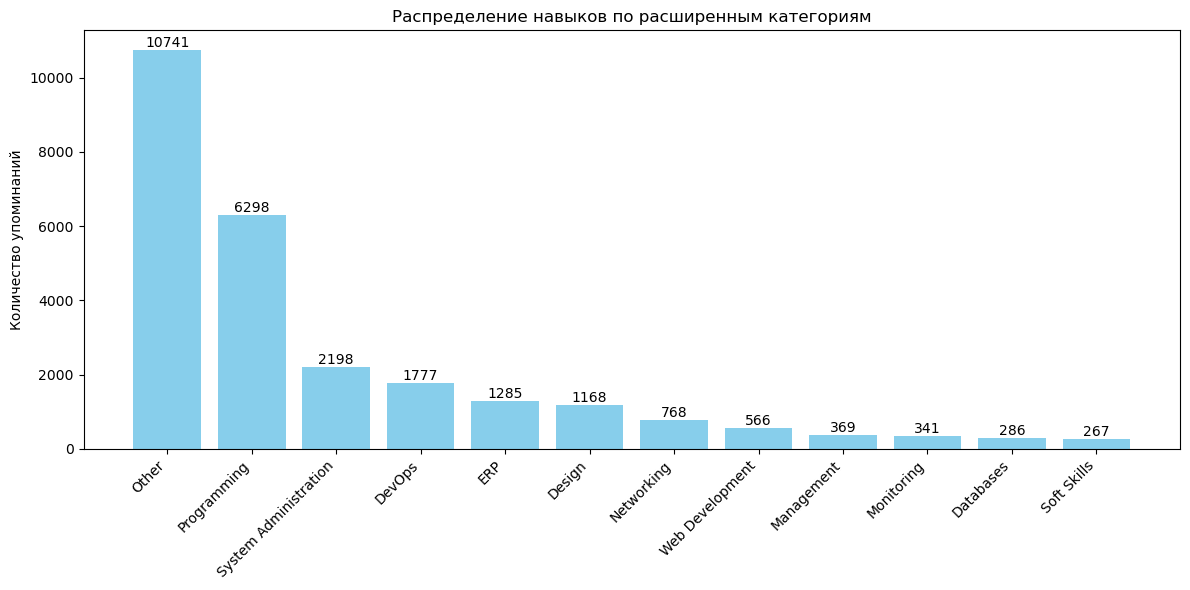

In [191]:
import matplotlib.pyplot as plt

# Подготовка данных
stats = category_stats.most_common()
categories = [x[0] for x in stats]
counts = [x[1] for x in stats]

# Визуализация
plt.figure(figsize=(12, 6))
bars = plt.bar(categories, counts, color='skyblue')
plt.title('Распределение навыков по расширенным категориям')
plt.ylabel('Количество упоминаний')
plt.xticks(rotation=45, ha='right')

# Добавляем подписи
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [185]:
def consolidate_categories(categories):
    # Объединение смежных категорий
    consolidated = defaultdict(list)
    
    for main_cat, subcats in categories.items():
        if main_cat in ['System Administration', 'Networking', 'Monitoring']:
            consolidated['Infrastructure'].extend([f"{main_cat}/{sc}" for sc in subcats])
        elif main_cat in ['Design', 'Web Development']:
            consolidated['Frontend'].extend([f"{main_cat}/{sc}" for sc in subcats])
        elif main_cat == 'ERP':
            consolidated['Business Systems'].extend([f"{main_cat}/{sc}" for sc in subcats])
        else:
            consolidated[main_cat].extend([f"{main_cat}/{sc}" for sc in subcats])
    
    return dict(consolidated)

result_df['consolidated_categories'] = result_df['enhanced_categories'].apply(consolidate_categories)

In [194]:
fixed_category_system = {
    # Языки программирования (3 уровня)
    'Python': 'Programming/Languages/Python',
    'Java': 'Programming/Languages/Java',
    
    # Базы данных (3 уровня)
    'SQL': 'Databases/Relational/SQL',
    'PostgreSQL': 'Databases/Relational/PostgreSQL',
    'MySQL': 'Databases/Relational/MySQL',
    'SQL Server': 'Databases/Relational/SQL Server',
    
    # Софт-скиллы (2 уровня)
    'English': 'Soft Skills/Language',
    'Грамотная устная и письменная речь': 'Soft Skills/Communication',
    'Коммуникативные навыки': 'Soft Skills/Communication',
    
    # DevOps (3 уровня)
    'Kubernetes': 'DevOps/Orchestration/Kubernetes',
    'RabbitMQ': 'DevOps/Messaging/RabbitMQ',
    
    # Упрощенные категории (2 уровня)
    'Бухгалтерский учет': 'Finance/Accounting',
    'Word': 'Office/MS Office'
}

from collections import defaultdict

def safe_categorizer_v2(skills):
    # Инициализируем словарь с обычными списками
    categories = {}
    
    for skill in skills:
        if not isinstance(skill, str):
            continue
            
        normalized = skill.lower().strip()
        matched = False
        
        # Проверяем все паттерны
        for pattern, category in fixed_category_system.items():
            if re.search(rf'\b{re.escape(pattern.lower())}\b', normalized):
                parts = category.split('/')
                
                # Для 3-уровневых категорий
                if len(parts) == 3:
                    key = f"{parts[0]}/{parts[1]}"
                    if key not in categories:
                        categories[key] = []
                    if parts[2] not in categories[key]:
                        categories[key].append(parts[2])
                
                # Для 2-уровневых категорий
                elif len(parts) == 2:
                    key = parts[0]
                    if key not in categories:
                        categories[key] = []
                    if parts[1] not in categories[key]:
                        categories[key].append(parts[1])
                
                matched = True
                break
                
        if not matched:
            if 'Uncategorized' not in categories:
                categories['Uncategorized'] = []
            if skill not in categories['Uncategorized']:
                categories['Uncategorized'].append(skill)
    
    return categories

# Применяем к DataFrame
result_df['fixed_categories_v2'] = result_df['skills_cleaned'].apply(safe_categorizer_v2)

In [195]:
# Тестируем на первых 5 записях
test_samples = result_df.head(5)['skills_cleaned'].apply(safe_categorizer_v2)
for i, sample in enumerate(test_samples):
    print(f"\nВакансия #{i+1}:")
    for category, skills in sample.items():
        print(f"{category}: {skills}")


Вакансия #1:
Uncategorized: ['Data Architecture', 'SQLite']
Programming/Languages: ['Python']
Databases/Relational: ['PostgreSQL']

Вакансия #2:
Databases/Relational: ['SQL']
Uncategorized: ['Html Css', 'JavaScript']
Programming/Languages: ['Python']

Вакансия #3:
Programming/Languages: ['Python']
Uncategorized: ['Power Bi', 'Project Management', 'Databases', 'Power Pivot', 'Power Query', 'Excel']
Databases/Relational: ['SQL']

Вакансия #4:
Programming/Languages: ['Python']
Uncategorized: ['Power Bi', 'Project Management', 'Databases', 'Power Pivot', 'Power Query']
Databases/Relational: ['SQL']

Вакансия #5:
Programming/Languages: ['Python']
Uncategorized: ['Power Bi', 'Project Management', 'Databases', 'Power Pivot', 'Power Query']
Databases/Relational: ['SQL']


In [199]:
# Дополняем словарь категорий (без изменения предыдущих)
enhanced_rules = {
    'Data Architecture': 'Architecture/Data',
    'SQLite': 'Databases/SQLite',
    'HTML CSS': 'Web Development/Frontend',
    'JavaScript': 'Programming/JavaScript',
    'Power BI': 'Business Intelligence/Visualization',
    'Power Pivot': 'Business Intelligence/Analysis',
    'Power Query': 'Business Intelligence/ETL',
    'Excel': 'Office/Spreadsheets',
    'Project Management': 'Management/Projects',
    'Databases': 'Databases/General'
}

def enhanced_categorizer(skills_list):
    categories = {}
    
    for skill in skills_list:
        # Пробуем найти прямое соответствие
        if skill in enhanced_rules:
            category = enhanced_rules[skill]
            main, sub = category.split('/')
            key = f"{main}/{sub}" if '/' in category else main
            
            if key not in categories:
                categories[key] = []
            categories[key].append(skill)
        else:
            if 'Uncategorized' not in categories:
                categories['Uncategorized'] = []
            categories['Uncategorized'].append(skill)
    
    return categories

# Применяем только к новому столбцу
result_df['enhanced_categories'] = result_df['skills_cleaned'].apply(enhanced_categorizer)

In [200]:
# Смотрим первые 5 результатов после улучшения
for i, row in result_df.head(5).iterrows():
    print(f"\nВакансия #{i+1}:")
    for category, skills in row['enhanced_categories'].items():
        print(f"{category}: {skills}")


Вакансия #1:
Architecture/Data: ['Data Architecture']
Uncategorized: ['Python', 'PostgreSQL']
Databases/SQLite: ['SQLite']

Вакансия #2:
Uncategorized: ['SQL', 'Html Css', 'Python']
Programming/JavaScript: ['JavaScript']

Вакансия #3:
Uncategorized: ['Python', 'Power Bi', 'SQL']
Management/Projects: ['Project Management']
Databases/General: ['Databases']
Business Intelligence/Analysis: ['Power Pivot']
Business Intelligence/ETL: ['Power Query']
Office/Spreadsheets: ['Excel']

Вакансия #4:
Uncategorized: ['Python', 'Power Bi', 'SQL']
Management/Projects: ['Project Management']
Databases/General: ['Databases']
Business Intelligence/Analysis: ['Power Pivot']
Business Intelligence/ETL: ['Power Query']

Вакансия #5:
Uncategorized: ['Python', 'Power Bi', 'SQL']
Management/Projects: ['Project Management']
Databases/General: ['Databases']
Business Intelligence/Analysis: ['Power Pivot']
Business Intelligence/ETL: ['Power Query']


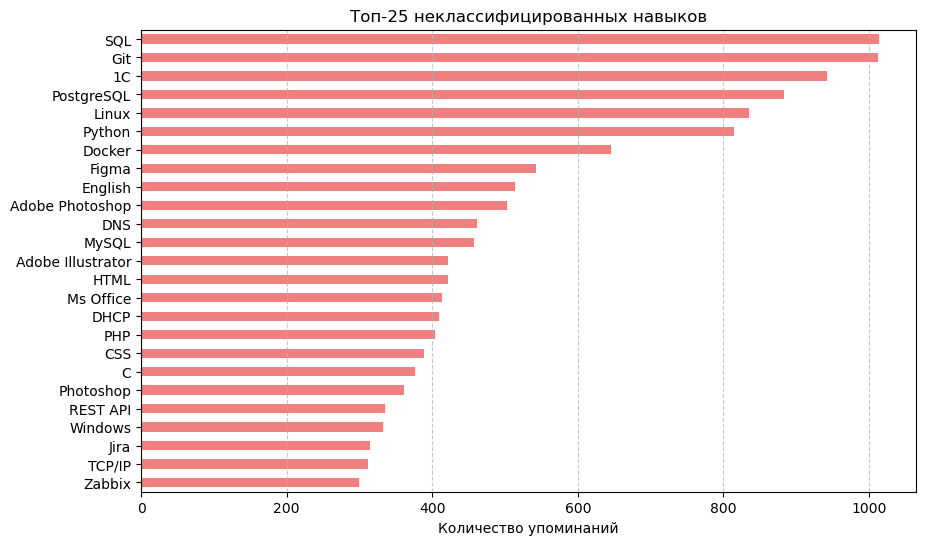

In [210]:
def analyze_uncategorized(df):
    # Собираем неклассифицированные навыки
    uncategorized = []
    for row in df['enhanced_categories']:
        if 'Uncategorized' in row:
            uncategorized.extend(row['Uncategorized'])
    
    # Создаем DataFrame для анализа
    uncat_stats = pd.Series(uncategorized).value_counts().head(25)
    
    # Визуализация
    plt.figure(figsize=(10, 6))
    uncat_stats.sort_values().plot(kind='barh', color='lightcoral')
    plt.title('Топ-25 неклассифицированных навыков')
    plt.xlabel('Количество упоминаний')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
    
    return uncat_stats

uncat_stats = analyze_uncategorized(result_df)

In [212]:
extended_category_map = {
    # Языки программирования
    'Python': 'Programming/Languages/Python',
    'PHP': 'Programming/Languages/PHP',
    'C': 'Programming/Languages/C',
    
    # Веб-разработка
    'HTML': 'Web Development/Frontend/HTML',
    'CSS': 'Web Development/Frontend/CSS',
    'REST API': 'Web Development/Backend/API',
    
    # Базы данных
    'SQL': 'Databases/SQL',
    'PostgreSQL': 'Databases/PostgreSQL',
    'MySQL': 'Databases/MySQL',
    
    # DevOps
    'Docker': 'DevOps/Containerization/Docker',
    'Git': 'DevOps/Version Control/Git',
    'Linux': 'DevOps/OS/Linux',
    'Windows': 'DevOps/OS/Windows',
    'DNS': 'DevOps/Networking/DNS',
    'DHCP': 'DevOps/Networking/DHCP',
    'TCP/IP': 'DevOps/Networking/TCP-IP',
    'Zabbix': 'DevOps/Monitoring/Zabbix',
    
    # 1С
    '1C': 'ERP/1C',
    
    # Дизайн
    'Figma': 'Design/UI-UX/Figma',
    'Adobe Photoshop': 'Design/Graphics/Photoshop',
    'Adobe Illustrator': 'Design/Graphics/Illustrator',
    'Photoshop': 'Design/Graphics/Photoshop',
    
    # Офисные навыки
    'Ms Office': 'Office/MS Office',
    'English': 'Language/English',
    'Jira': 'Project Management/Jira'
}

from collections import defaultdict

def robust_categorizer(skills_list):
    if not isinstance(skills_list, list):
        return {}
    
    # Используем обычный словарь вместо defaultdict
    categories = {}
    
    for skill in skills_list:
        if not isinstance(skill, str):
            continue
            
        normalized = skill.strip()
        matched = False
        
        # Проверка точного соответствия
        if normalized in extended_category_map:
            category_path = extended_category_map[normalized]
            parts = category_path.split('/')
            
            if len(parts) == 3:
                key = f"{parts[0]}/{parts[1]}"
                if key not in categories:
                    categories[key] = set()
                categories[key].add(parts[2])
            matched = True
        else:
            # Проверка частичных совпадений
            for pattern, category_path in extended_category_map.items():
                if pattern.lower() in normalized.lower():
                    parts = category_path.split('/')
                    if len(parts) == 3:
                        key = f"{parts[0]}/{parts[1]}"
                        if key not in categories:
                            categories[key] = set()
                        categories[key].add(parts[2])
                    matched = True
                    break
        
        if not matched:
            if 'Uncategorized' not in categories:
                categories['Uncategorized'] = set()
            categories['Uncategorized'].add(normalized)
    
    # Преобразуем множества обратно в списки
    return {k: list(v) for k, v in categories.items()}

# Применяем к DataFrame
result_df['robust_categories'] = result_df['skills_cleaned'].apply(robust_categorizer)

In [216]:
# Тестируем на 10 записях
for i, row in result_df.sample(10).iterrows():
    print(f"\nВакансия #{i+1}:")
    for category, skills in row['robust_categories'].items():
        print(f"{category}: {skills}")


Вакансия #128:
Programming/Languages: ['C']
Uncategorized: ['Mpstats', 'Исследование Рынка', 'Анализ Данных', 'Макросы', 'Репрайсеры', 'Power Query']

Вакансия #7544:
Programming/Languages: ['C']
Uncategorized: ['Word']

Вакансия #6357:
Uncategorized: ['1С Бухгалтерия', '1С Договоры']
Programming/Languages: ['C']

Вакансия #8835:
Uncategorized: ['Уверенный Пользователь Пк', 'Нацеленность На Карьерный Рост И Высокий Доход', 'Грамотная Устная И Письменная Речь']

Вакансия #1380:
Programming/Languages: ['C']
Uncategorized: ['Fbx', 'Unwrap Uvw', 'Revit', '3D Max', 'Obj']
Design/Graphics: ['Illustrator', 'Photoshop']

Вакансия #2606:
Programming/Languages: ['C']
Uncategorized: ['Powerpoint', 'Подготовка Аналитических Справок', 'Компас', 'Разработка Научнотехнической Документации', 'Авторский Надзор', 'Работа С Патентами И Авторскими Свидетельствами', 'Разработка Стандартов Организаций']

Вакансия #2791:
Programming/Languages: ['C']
Uncategorized: ['Нотация Описания Бизнеспроцессов', 'Объек

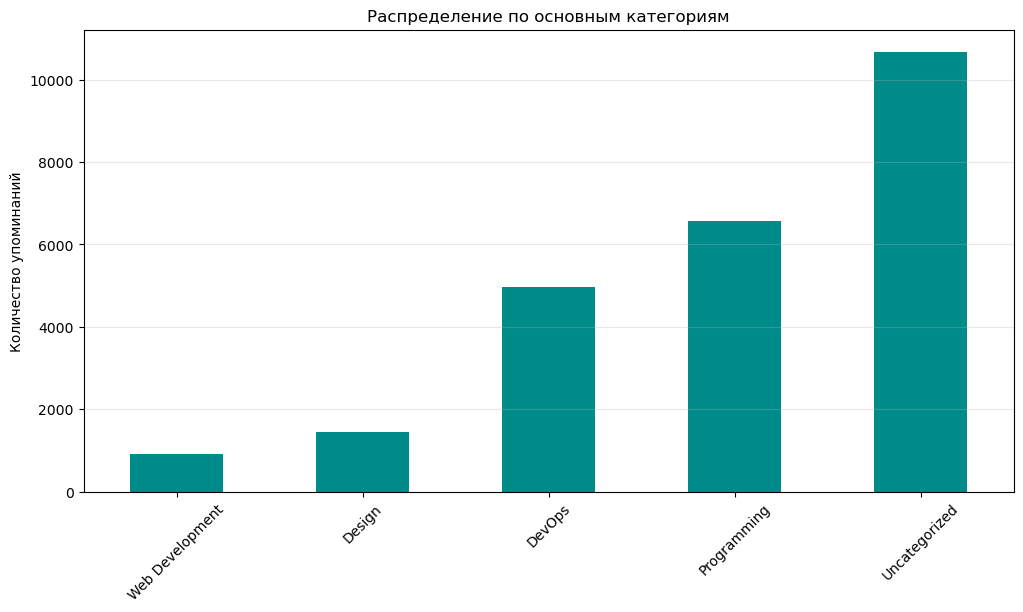

Топ-10 неклассифицированных навыков:


Скд                                   287
Java                                  283
Redis                                 279
Коммуникабельность                    265
OOP                                   249
Грамотная Устная И Письменная Речь    239
Bash                                  239
Kubernetes                            230
Бухгалтерский Учет                    229
Rabbitmq                              226
Name: count, dtype: int64

In [217]:
def analyze_robust_categories(df):
    # Собираем статистику
    main_cats = Counter()
    for categories in df['robust_categories']:
        for category_path in categories:
            main_cat = category_path.split('/')[0] if '/' in category_path else category_path
            main_cats[main_cat] += 1
    
    # Визуализация
    plt.figure(figsize=(12, 6))
    pd.Series(main_cats).sort_values().plot(kind='bar', color='darkcyan')
    plt.title('Распределение по основным категориям')
    plt.ylabel('Количество упоминаний')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    # Анализ неклассифицированных
    uncategorized = []
    for row in df['robust_categories']:
        if 'Uncategorized' in row:
            uncategorized.extend(row['Uncategorized'])
    
    print("Топ-10 неклассифицированных навыков:")
    display(pd.Series(uncategorized).value_counts().head(10))

analyze_robust_categories(result_df)

In [218]:
enhanced_rules_v2 = {
    # Аналитика и исследования
    'Анализ Данных': 'Analytics/Data Analysis',
    'Исследование Рынка': 'Analytics/Market Research',
    'Макросы': 'Automation/Macros',
    'Power Query': 'Analytics/ETL',
    'Подготовка Аналитических Справок': 'Analytics/Reporting',
    
    # 1С
    '1С Бухгалтерия': 'ERP/1C Accounting',
    '1С Договоры': 'ERP/1C Contracts',
    'Скд': 'ERP/1C SKD',
    
    # Офисные программы
    'Word': 'Office/Word',
    'Powerpoint': 'Office/PowerPoint',
    'Power Point': 'Office/PowerPoint',
    'Visio': 'Office/Visio',
    
    # 3D и CAD
    'Fbx': '3D Modeling/FBX',
    'Unwrap Uvw': '3D Modeling/UV Mapping',
    'Revit': 'CAD/Revit',
    '3D Max': '3D Modeling/3ds Max',
    'Obj': '3D Modeling/OBJ',
    'Компас': 'CAD/Kompas',
    
    # Инфраструктура
    'Уверенный Пользователь Пк': 'IT/PC Skills',
    'Локальная Сеть': 'Networking/LAN',
    'Сетевое Оборудование': 'Networking/Hardware',
    'Диагностика Пк': 'IT/PC Diagnostics',
    'Ремонт Пк': 'IT/PC Repair',
    'Системы Виртуализации': 'Virtualization/Systems',
    
    # Бизнес-навыки
    'Нацеленность На Карьерный Рост': 'Soft Skills/Career Growth',
    'Грамотная Устная И Письменная Речь': 'Soft Skills/Communication',
    'Переговоры': 'Business/Negotiations',
    'Разработка Стратегий': 'Business/Strategy',
    'Операционное Управление': 'Management/Operations',
    
    # Техническая документация
    'Разработка Научнотехнической Документации': 'Engineering/Documentation',
    'Авторский Надзор': 'Engineering/Supervision',
    'Работа С Патентами': 'Legal/Patents',
    'Разработка Стандартов Организаций': 'Business/Standards',
    
    # Специфические технологии
    'Wlan': 'Networking/WLAN',
    'Gpo': 'System Administration/GPO',
    'Opera Pms V5': 'Hospitality/Opera PMS',
    
    # Программирование
    'Объектноориентированный Язык Программирования': 'Programming/OOP',
    'Нотация Описания Бизнеспроцессов': 'Business/BPMN'
}

# Объединяем с предыдущими правилами без их изменения
full_category_map = {**extended_category_map, **enhanced_rules_v2}

In [219]:
def enhanced_categorizer_v2(skills_list):
    if not isinstance(skills_list, list):
        return {}
    
    categories = {}
    
    for skill in skills_list:
        if not isinstance(skill, str):
            continue
            
        normalized = skill.strip()
        matched = False
        
        # Нормализация ключевых слов
        normalized_key = (normalized.lower()
                         .replace(" ", "")
                         .replace("-", "")
                         .replace("ё", "е"))
        
        # Поиск точного совпадения
        for pattern, category in full_category_map.items():
            pattern_norm = (pattern.lower()
                           .replace(" ", "")
                           .replace("-", "")
                           .replace("ё", "е"))
            
            if pattern_norm == normalized_key:
                parts = category.split('/')
                if len(parts) >= 2:
                    key = f"{parts[0]}/{parts[1]}" if len(parts) > 2 else category
                    if key not in categories:
                        categories[key] = []
                    if len(parts) > 2 and parts[2] not in categories[key]:
                        categories[key].append(parts[2])
                    elif len(parts) == 2 and skill not in categories[key]:
                        categories[key].append(skill)
                matched = True
                break
        
        if not matched:
            if 'Uncategorized' not in categories:
                categories['Uncategorized'] = []
            if skill not in categories['Uncategorized']:
                categories['Uncategorized'].append(skill)
    
    return categories

# Применяем к DataFrame
result_df['full_categories'] = result_df['skills_cleaned'].apply(enhanced_categorizer_v2)

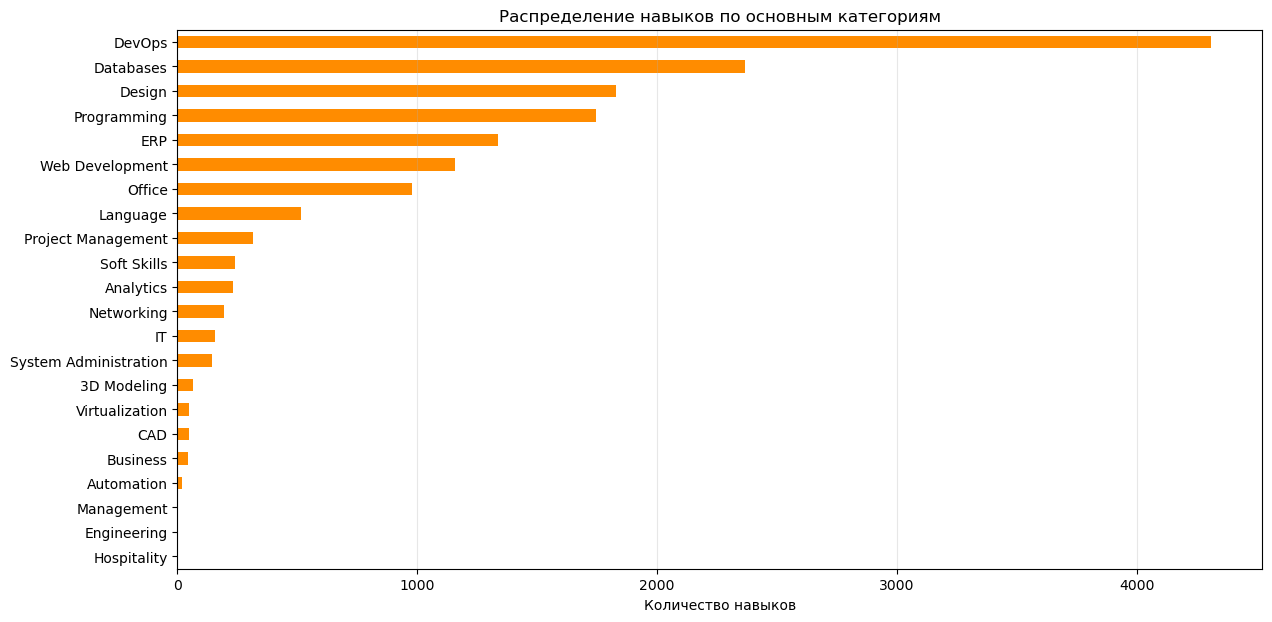

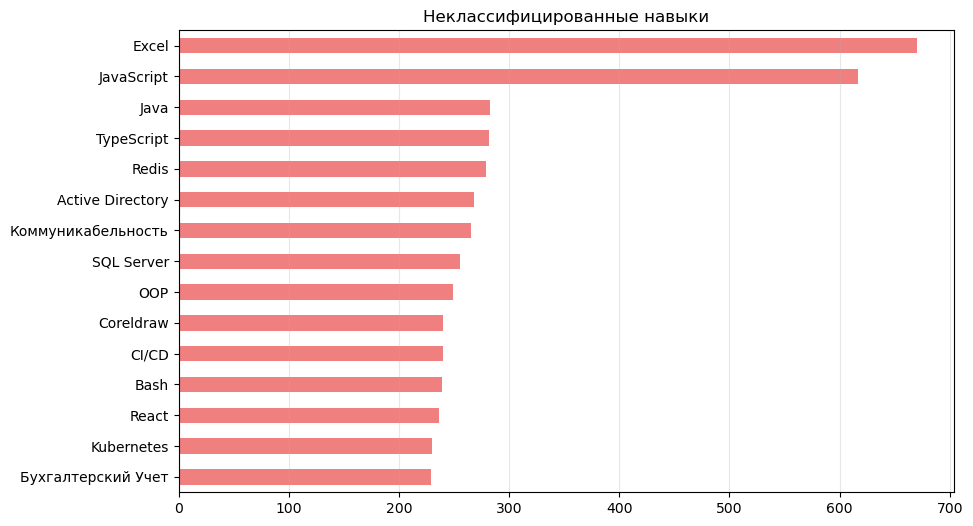

Общее количество навыков: 99976
Количество навыков, классифицированных по категориям: 15741
Количество неклассифицированных навыков: 84235

Топ-15 неклассифицированных навыков:
Excel: 670
JavaScript: 617
Java: 283
TypeScript: 282
Redis: 279
Active Directory: 268
Коммуникабельность: 265
SQL Server: 255
OOP: 249
CI/CD: 240
Coreldraw: 240
Bash: 239
React: 236
Kubernetes: 230
Бухгалтерский Учет: 229


In [221]:
def analyze_full_categories(df):
    # Статистика по категориям
    category_stats = defaultdict(int)
    uncategorized = []
    
    for row in df['full_categories']:
        for category, skills in row.items():
            if category == 'Uncategorized':
                uncategorized.extend(skills)
            else:
                main_cat = category.split('/')[0]
                category_stats[main_cat] += len(skills)
    
    # Визуализация распределения по категориям
    plt.figure(figsize=(14, 7))
    pd.Series(category_stats).sort_values().plot(kind='barh', color='darkorange')
    plt.title('Распределение навыков по основным категориям')
    plt.xlabel('Количество навыков')
    plt.grid(axis='x', alpha=0.3)
    plt.show()
    
    # Топ-15 неклассифицированных навыков
    uncat_counts = pd.Series(uncategorized).value_counts().head(15)
    
    # Визуализация неклассифицированных навыков
    plt.figure(figsize=(10, 6))
    uncat_counts.sort_values().plot(kind='barh', color='lightcoral')
    plt.title('Неклассифицированные навыки')
    plt.grid(axis='x', alpha=0.3)
    plt.show()
    
    # Вывод текстовой статистики
    total_skills = sum(category_stats.values()) + len(uncategorized)
    total_categorized_skills = sum(category_stats.values())
    total_uncategorized_skills = len(uncategorized)
    
    print(f"Общее количество навыков: {total_skills}")
    print(f"Количество навыков, классифицированных по категориям: {total_categorized_skills}")
    print(f"Количество неклассифицированных навыков: {total_uncategorized_skills}")
    
    print("\nТоп-15 неклассифицированных навыков:")
    for skill, count in uncat_counts.items():
        print(f"{skill}: {count}")

# Вызов функции с вашим DataFrame
analyze_full_categories(result_df)

ПОЛНАЯ СТАТИСТИКА КАТЕГОРИЗАЦИИ НАВЫКОВ

ОСНОВНЫЕ КАТЕГОРИИ (по количеству навыков):
1. DevOps: 4309 навыков | Примеры: Linux, Docker, Windows...
2. Databases: 2366 навыков | Примеры: PostgreSQL, SQL, MySQL...
3. Design: 1828 навыков | Примеры: Figma, Photoshop, Illustrator
4. Programming: 1747 навыков | Примеры: Python, C, PHP...
5. ERP: 1335 навыков | Примеры: 1C, 1Сбухгалтерия, 1С Бухгалтерия...
6. Web Development: 1156 навыков | Примеры: HTML, CSS, API
7. Office: 977 навыков | Примеры: Power Point, Ms Office, Word...
8. Language: 514 навыков | Примеры: English
9. Project Management: 315 навыков | Примеры: Jira
10. Soft Skills: 239 навыков | Примеры: Грамотная Устная И Письменная Речь
11. Analytics: 231 навыков | Примеры: Power Query, Powerquery, Анализ Данных...
12. Networking: 195 навыков | Примеры: Сетевое Оборудование, Локальная Сеть, Wlan
13. IT: 156 навыков | Примеры: Уверенный Пользователь Пк, Диагностика Пк, Ремонт Пк
14. System Administration: 142 навыков | Примеры: Gpo
15.

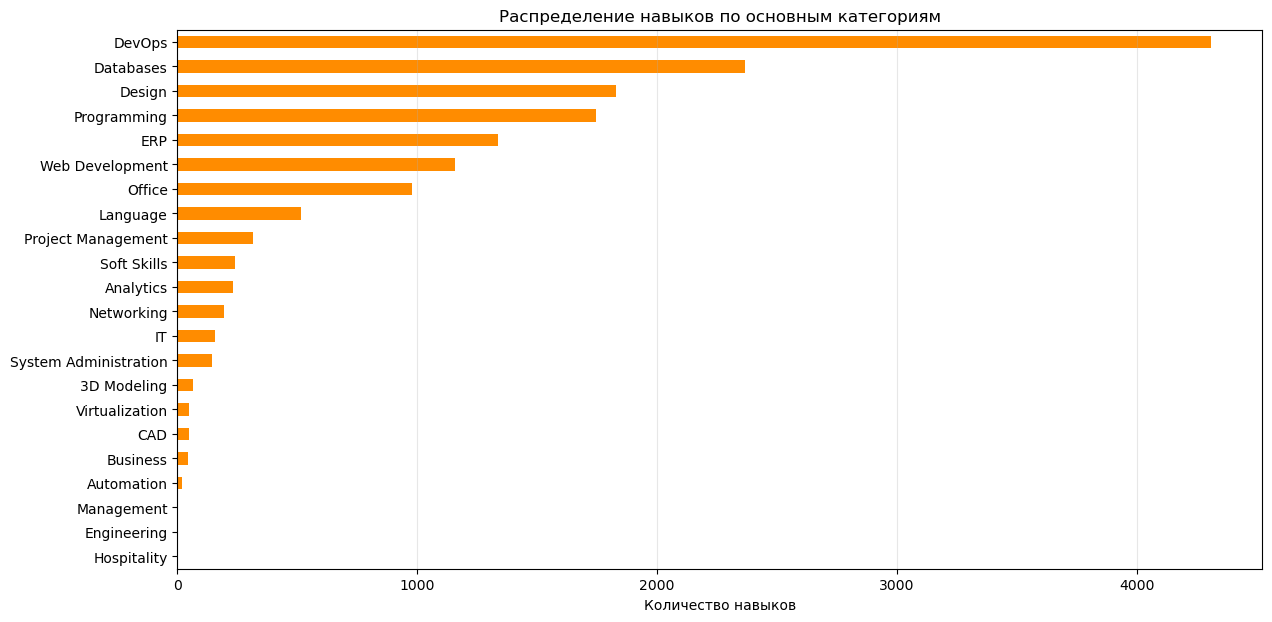

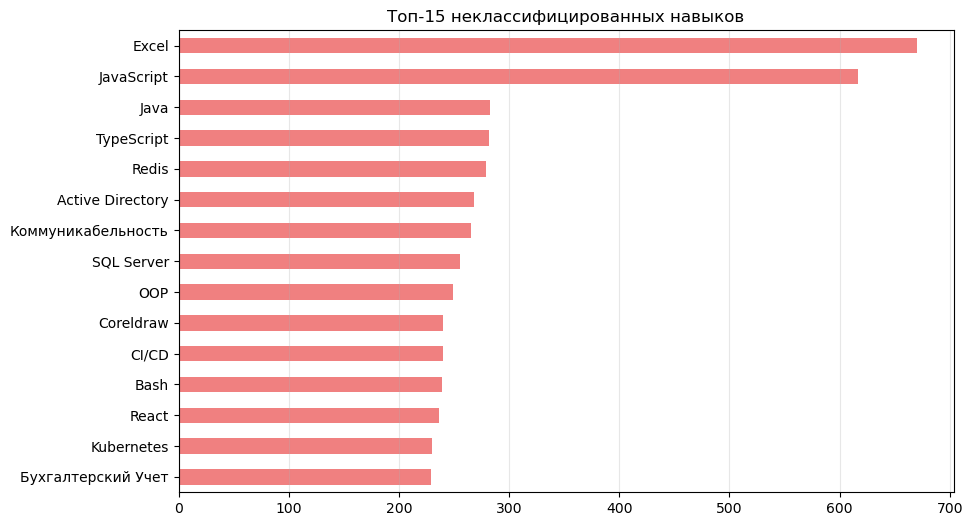

In [222]:
def analyze_full_categories(df):
    # Статистика по категориям
    category_stats = defaultdict(int)
    uncategorized = []
    category_examples = defaultdict(list)
    
    for row in df['full_categories']:
        for category, skills in row.items():
            if category == 'Uncategorized':
                uncategorized.extend(skills)
            else:
                main_cat = category.split('/')[0]
                category_stats[main_cat] += len(skills)
                # Собираем примеры навыков для каждой категории
                for skill in skills:
                    if skill not in category_examples[main_cat]:
                        category_examples[main_cat].append(skill)
    
    # Текстовая статистика
    print("="*80)
    print("ПОЛНАЯ СТАТИСТИКА КАТЕГОРИЗАЦИИ НАВЫКОВ")
    print("="*80)
    
    # 1. Основные категории
    print("\nОСНОВНЫЕ КАТЕГОРИИ (по количеству навыков):")
    main_cats_sorted = sorted(category_stats.items(), key=lambda x: x[1], reverse=True)
    for i, (category, count) in enumerate(main_cats_sorted, 1):
        examples = ', '.join(category_examples[category][:3]) + ('...' if len(category_examples[category]) > 3 else '')
        print(f"{i}. {category}: {count} навыков | Примеры: {examples}")
    
    # 2. Неклассифицированные навыки
    uncat_counts = pd.Series(uncategorized).value_counts()
    print("\n" + "="*80)
    print(f"НЕКЛАССИФИЦИРОВАННЫЕ НАВЫКИ (всего {len(uncat_counts)} уникальных):")
    print(f"Общее количество неклассифицированных упоминаний: {len(uncategorized)}")
    print("\nТОП-15 неклассифицированных навыков:")
    for i, (skill, count) in enumerate(uncat_counts.head(15).items(), 1):
        print(f"{i}. {skill}: {count} упоминаний")
    
    # 3. Общая статистика
    total_skills = sum(category_stats.values()) + len(uncategorized)
    classified_percent = sum(category_stats.values()) / total_skills * 100
    print("\n" + "="*80)
    print("ОБЩАЯ СТАТИСТИКА:")
    print(f"Всего навыков обработано: {total_skills}")
    print(f"Категоризировано: {sum(category_stats.values())} ({classified_percent:.1f}%)")
    print(f"Неклассифицировано: {len(uncategorized)} ({100-classified_percent:.1f}%)")
    
    # Визуализация
    plt.figure(figsize=(14, 7))
    pd.Series(category_stats).sort_values().plot(kind='barh', color='darkorange')
    plt.title('Распределение навыков по основным категориям')
    plt.xlabel('Количество навыков')
    plt.grid(axis='x', alpha=0.3)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    uncat_counts.head(15).sort_values().plot(kind='barh', color='lightcoral')
    plt.title('Топ-15 неклассифицированных навыков')
    plt.grid(axis='x', alpha=0.3)
    plt.show()
    
    # Возвращаем данные для возможного использования
    return {
        'category_stats': dict(category_stats),
        'uncategorized_counts': uncat_counts.to_dict(),
        'examples': {k: v[:5] for k, v in category_examples.items()}  # Примеры по каждой категории
    }

# Вызываем функцию и сохраняем результат
stats_results = analyze_full_categories(result_df)

In [223]:
extended_mapping_v3 = {
    # Основные технические навыки
    'Excel': 'Office/Spreadsheets/Excel',
    'JavaScript': 'Programming/Languages/JavaScript',
    'Java': 'Programming/Languages/Java', 
    'TypeScript': 'Programming/Languages/TypeScript',
    'Redis': 'Databases/NoSQL/Redis',
    'Active Directory': 'System Administration/AD',
    'SQL Server': 'Databases/SQL Server',
    'OOP': 'Programming/Concepts/OOP',
    'CI/CD': 'DevOps/CI-CD',
    'Bash': 'DevOps/Scripting/Bash',
    'React': 'Web Development/Frontend/React',
    'Kubernetes': 'DevOps/Orchestration/Kubernetes',
    'Бухгалтерский Учет': 'Finance/Accounting',
    
    # Дополнительные часто встречающиеся навыки
    'Коммуникабельность': 'Soft Skills/Communication',
    'Coreldraw': 'Design/Graphics/CorelDRAW',
    'Angular': 'Web Development/Frontend/Angular',
    'Vue': 'Web Development/Frontend/Vue',
    'Node.js': 'Web Development/Backend/Node',
    'Django': 'Web Development/Backend/Django',
    'Flask': 'Web Development/Backend/Flask',
    'Pandas': 'Data Analysis/Python/Pandas',
    'NumPy': 'Data Analysis/Python/NumPy',
    'Scipy': 'Data Analysis/Python/SciPy',
    'Power BI': 'Business Intelligence/Visualization',
    'Tableau': 'Business Intelligence/Visualization'
}

In [224]:
def enhanced_categorizer_v3(skills_list):
    """Улучшенный категоризатор с обработкой критических навыков"""
    if not isinstance(skills_list, list):
        return {}
    
    categories = defaultdict(list)
    
    for skill in skills_list:
        if not isinstance(skill, str):
            continue
            
        normalized = skill.strip()
        if not normalized:
            continue
            
        # 1. Проверка точного соответствия
        if normalized in extended_mapping_v3:
            category_path = extended_mapping_v3[normalized]
            categories[category_path].append(normalized)
            continue
            
        # 2. Нормализация для сравнения (удаляем пробелы, дефисы, приводим к нижнему регистру)
        normalized_compare = (normalized.lower()
                             .replace(" ", "")
                             .replace("-", "")
                             .replace("ё", "е"))
        
        # 3. Поиск частичных совпадений
        matched = False
        for pattern, category_path in extended_mapping_v3.items():
            pattern_norm = (pattern.lower()
                           .replace(" ", "")
                           .replace("-", "")
                           .replace("ё", "е"))
            
            if pattern_norm in normalized_compare:
                categories[category_path].append(normalized)
                matched = True
                break
                
        # 4. Обработка не найденных навыков
        if not matched:
            # Специальная обработка для 1С
            if '1с' in normalized_compare or '1c' in normalized_compare:
                if 'бухгалтерия' in normalized_compare:
                    categories['ERP/1C/Accounting'].append(normalized)
                elif 'договор' in normalized_compare:
                    categories['ERP/1C/Contracts'].append(normalized)
                elif 'скд' in normalized_compare:
                    categories['ERP/1C/SKD'].append(normalized)
                else:
                    categories['ERP/1C'].append(normalized)
            else:
                categories['Uncategorized'].append(normalized)
    
    # Удаляем дубликаты в категориях
    return {k: list(set(v)) for k, v in categories.items()}

# Применяем к DataFrame
result_df['enhanced_categories_v3'] = result_df['skills_cleaned'].apply(enhanced_categorizer_v3)

In [225]:
def analyze_enhanced_categories(df):
    # Собираем статистику
    stats = {
        'total_skills': 0,
        'classified': 0,
        'categories': defaultdict(int),
        'uncategorized': []
    }
    
    for row in df['enhanced_categories_v3']:
        for category, skills in row.items():
            if category == 'Uncategorized':
                stats['uncategorized'].extend(skills)
            else:
                stats['classified'] += len(skills)
                main_category = category.split('/')[0]
                stats['categories'][main_category] += len(skills)
            stats['total_skills'] += len(skills)
    
    # Вывод статистики
    print("=== Результаты улучшенной категоризации ===")
    print(f"Всего навыков: {stats['total_skills']}")
    print(f"Категоризировано: {stats['classified']} ({stats['classified']/stats['total_skills']:.1%})")
    print(f"Неклассифицировано: {len(stats['uncategorized'])} ({len(stats['uncategorized'])/stats['total_skills']:.1%})")
    
    # Топ категорий
    print("\nТоп-10 категорий:")
    for i, (cat, count) in enumerate(sorted(stats['categories'].items(), key=lambda x: x[1], reverse=True)[:10], 1):
        print(f"{i}. {cat}: {count} навыков")
    
    # Топ неклассифицированных
    uncat_counts = pd.Series(stats['uncategorized']).value_counts().head(15)
    print("\nТоп-15 неклассифицированных:")
    print(uncat_counts.to_string())
    
    return stats

# Запускаем анализ
stats_v3 = analyze_enhanced_categories(result_df)

=== Результаты улучшенной категоризации ===
Всего навыков: 99979
Категоризировано: 12027 (12.0%)
Неклассифицировано: 87952 (88.0%)

Топ-10 категорий:
1. ERP: 5116 навыков
2. Programming: 1730 навыков
3. Office: 1142 навыков
4. Web Development: 971 навыков
5. DevOps: 896 навыков
6. Databases: 649 навыков
7. System Administration: 357 навыков
8. Design: 354 навыков
9. Soft Skills: 267 навыков
10. Finance: 244 навыков

Топ-15 неклассифицированных:
SQL                  1014
Git                  1013
PostgreSQL            883
Linux                 835
Python                814
Docker                646
Figma                 542
English               514
Adobe Photoshop       503
DNS                   461
MySQL                 458
Adobe Illustrator     422
HTML                  421
Ms Office             414
DHCP                  409


In [226]:
tech_skills_mapping = {
    # Языки программирования
    'Python': 'Programming/Languages/Python',
    'Java': 'Programming/Languages/Java',
    'C': 'Programming/Languages/C',
    'C++': 'Programming/Languages/C++',
    'C#': 'Programming/Languages/C#',
    
    # Веб-разработка
    'HTML': 'Web Development/Frontend/HTML',
    'CSS': 'Web Development/Frontend/CSS',
    'JavaScript': 'Web Development/Frontend/JavaScript',
    'TypeScript': 'Web Development/Frontend/TypeScript',
    'React': 'Web Development/Frontend/React',
    'Angular': 'Web Development/Frontend/Angular',
    'Vue': 'Web Development/Frontend/Vue',
    'Node.js': 'Web Development/Backend/Node',
    
    # Базы данных
    'SQL': 'Databases/SQL',
    'PostgreSQL': 'Databases/PostgreSQL',
    'MySQL': 'Databases/MySQL',
    'MongoDB': 'Databases/NoSQL/MongoDB',
    'Redis': 'Databases/NoSQL/Redis',
    
    # DevOps
    'Docker': 'DevOps/Containerization/Docker',
    'Kubernetes': 'DevOps/Orchestration/Kubernetes',
    'Git': 'DevOps/Version Control/Git',
    'CI/CD': 'DevOps/CI-CD',
    'Bash': 'DevOps/Scripting/Bash',
    'Linux': 'DevOps/OS/Linux',
    'Windows': 'DevOps/OS/Windows',
    
    # Сети
    'DNS': 'Networking/DNS',
    'DHCP': 'Networking/DHCP',
    'TCP/IP': 'Networking/TCP-IP',
    
    # Мониторинг
    'Zabbix': 'Monitoring/Zabbix',
    'Grafana': 'Monitoring/Grafana',
    
    # 1С
    '1C': 'ERP/1C',
    '1С:Бухгалтерия': 'ERP/1C/Accounting',
    
    # Аналитика
    'Power BI': 'Business Intelligence/PowerBI',
    'Excel': 'Business Intelligence/Excel',
    'Tableau': 'Business Intelligence/Tableau'
}

In [227]:
def aggressive_categorizer(skills_list):
    """Категоризатор с приоритетом технических навыков"""
    if not isinstance(skills_list, list):
        return {}
    
    categories = defaultdict(list)
    uncategorized = []
    
    for skill in skills_list:
        if not isinstance(skill, str):
            continue
            
        skill = skill.strip()
        if not skill:
            continue
        
        # Приоритет 1: точное соответствие
        if skill in tech_skills_mapping:
            categories[tech_skills_mapping[skill]].append(skill)
            continue
            
        # Приоритет 2: регистронезависимое сравнение
        lower_skill = skill.lower()
        matched = False
        for tech, category in tech_skills_mapping.items():
            if tech.lower() == lower_skill:
                categories[category].append(skill)
                matched = True
                break
        if matched:
            continue
            
        # Приоритет 3: частичное вхождение
        for tech, category in tech_skills_mapping.items():
            if tech.lower() in lower_skill:
                categories[category].append(skill)
                matched = True
                break
        if matched:
            continue
            
        uncategorized.append(skill)
    
    # Добавляем неклассифицированные в отдельную категорию
    if uncategorized:
        categories['Uncategorized'] = uncategorized
        
    return dict(categories)

# Применяем и сохраняем результаты
result_df['aggressive_categories'] = result_df['skills_cleaned'].apply(aggressive_categorizer)

In [228]:
def analyze_aggressive_categories(df):
    stats = {
        'total': 0,
        'classified': 0,
        'uncategorized': 0,
        'top_categories': defaultdict(int),
        'tech_skills': 0
    }
    
    tech_categories = {'Programming', 'DevOps', 'Databases', 'Web Development'}
    
    for row in df['aggressive_categories']:
        for category, skills in row.items():
            if category == 'Uncategorized':
                stats['uncategorized'] += len(skills)
            else:
                stats['classified'] += len(skills)
                main_cat = category.split('/')[0]
                stats['top_categories'][main_cat] += len(skills)
                if main_cat in tech_categories:
                    stats['tech_skills'] += len(skills)
            stats['total'] += len(skills)
    
    print("=== Агрессивная категоризация ===")
    print(f"Всего навыков: {stats['total']}")
    print(f"Категоризировано: {stats['classified']} ({stats['classified']/stats['total']:.1%})")
    print(f"Технические навыки: {stats['tech_skills']} ({stats['tech_skills']/stats['total']:.1%})")
    print(f"Неклассифицировано: {stats['uncategorized']} ({stats['uncategorized']/stats['total']:.1%})")
    
    print("\nТоп-10 категорий:")
    for i, (cat, count) in enumerate(sorted(stats['top_categories'].items(), 
                                    key=lambda x: x[1], reverse=True)[:10], 1):
        print(f"{i}. {cat}: {count}")
    
    return stats

aggressive_stats = analyze_aggressive_categories(result_df)

=== Агрессивная категоризация ===
Всего навыков: 99979
Категоризировано: 28971 (29.0%)
Технические навыки: 25367 (25.4%)
Неклассифицировано: 71008 (71.0%)

Топ-10 категорий:
1. Programming: 13314
2. DevOps: 5738
3. Databases: 3833
4. Web Development: 2482
5. Networking: 1206
6. ERP: 942
7. Business Intelligence: 867
8. Monitoring: 589


In [230]:
super_extended_mapping = {
    # Языки программирования (добавляем вариации)
    'Python': 'Programming/Languages/Python',
    'Python 3': 'Programming/Languages/Python',
    'Python3': 'Programming/Languages/Python',
    'JS': 'Programming/Languages/JavaScript',
    'Java': 'Programming/Languages/Java',
    'Java SE': 'Programming/Languages/Java',
    
    # Фреймворки
    'Django': 'Web Development/Frameworks/Django',
    'Flask': 'Web Development/Frameworks/Flask',
    'Spring': 'Programming/Frameworks/Spring',
    
    # Базы данных (включая администрацию)
    'PostgreSQL': 'Databases/PostgreSQL',
    'Postgres': 'Databases/PostgreSQL',
    'MySQL': 'Databases/MySQL',
    'SQL Admin': 'Databases/Administration',
    'DB Admin': 'Databases/Administration',
    
    # DevOps (полный стек)
    'Docker': 'DevOps/Containerization/Docker',
    'K8s': 'DevOps/Orchestration/Kubernetes',
    'GitLab': 'DevOps/Version Control/GitLab',
    'GitHub': 'DevOps/Version Control/GitHub',
    
    # Сети и безопасность
    'TCP/IP': 'Networking/Protocols/TCP-IP',
    'HTTP': 'Networking/Protocols/HTTP',
    'HTTPS': 'Networking/Protocols/HTTPS',
    'Firewall': 'Security/Firewall',
    
    # Добавляем мягкие навыки
    'Коммуникабельность': 'Soft Skills/Communication',
    'Работа в команде': 'Soft Skills/Teamwork',
    'Тайм-менеджмент': 'Soft Skills/Time Management'
}

In [231]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

class SmartCategorizer:
    def __init__(self):
        self.skill_to_category = super_extended_mapping
        self.vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))
        self._prepare_vectors()
    
    def _prepare_vectors(self):
        self.all_skills = list(self.skill_to_category.keys())
        self.skill_vectors = self.vectorizer.fit_transform(self.all_skills)
    
    def find_similar(self, skill):
        """Находит наиболее похожий навык с использованием косинусного сходства"""
        input_vec = self.vectorizer.transform([skill])
        similarities = cosine_similarity(input_vec, self.skill_vectors)
        best_match_idx = similarities.argmax()
        return self.all_skills[best_match_idx], similarities[0, best_match_idx]
    
    def categorize(self, skills_list):
        categories = defaultdict(list)
        
        for skill in skills_list:
            if not isinstance(skill, str):
                continue
                
            skill = skill.strip()
            if not skill:
                continue
                
            # 1. Точное соответствие
            if skill in self.skill_to_category:
                categories[self.skill_to_category[skill]].append(skill)
                continue
                
            # 2. Нечеткое соответствие
            matched_skill, similarity = self.find_similar(skill)
            if similarity > 0.7:  # Порог схожести
                categories[self.skill_to_category[matched_skill]].append(skill)
            else:
                categories['Uncategorized'].append(skill)
                
        return dict(categories)

# Инициализация и применение
smart_categorizer = SmartCategorizer()
result_df['smart_categories'] = result_df['skills_cleaned'].apply(smart_categorizer.categorize)

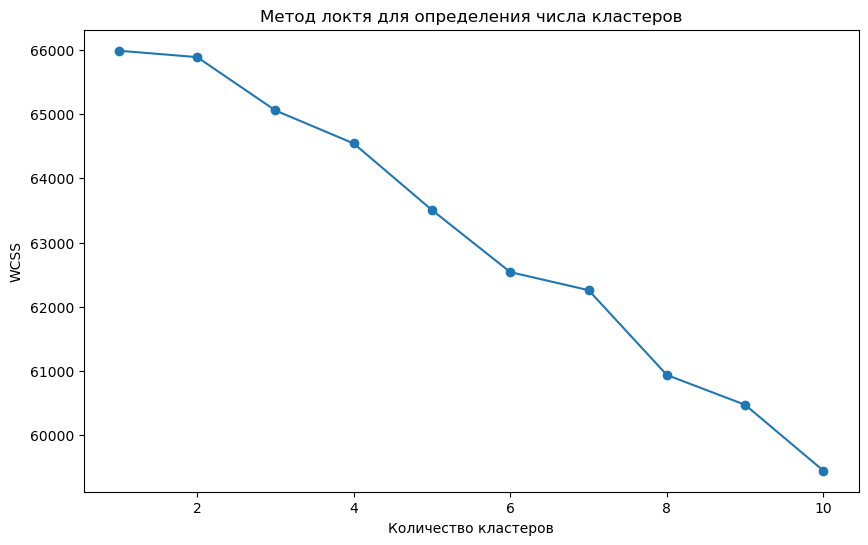

Топ-5 навыков в каждом кластере:

Кластер 0:
skill
Angular             71
Angular Js           4
Angular Cli          3
Angular Material     2
Angular 16           2
Name: count, dtype: int64

Кластер 1:
skill
SQL                1014
Git                1013
Figma               542
Adobe Photoshop     503
DNS                 461
Name: count, dtype: int64

Кластер 2:
skill
Excel                    670
Ms Excel                 148
Ms Office Excel           42
Microsoft Excel           30
Excel Сводные Таблицы     29
Name: count, dtype: int64

Кластер 3:
skill
English                 514
English Intermediate      1
Name: count, dtype: int64

Кластер 4:
skill
Linux           835
Ос Linux         71
Astra Linux      50
Linux Debian     21
Linux Centos     18
Name: count, dtype: int64

Кластер 5:
skill
1C                 942
1C Erp               8
1C Erp 25            8
Планы Обмена 1C      6
1C Erp 2             4
Name: count, dtype: int64


In [233]:
def analyze_with_clustering(df):
    # Собираем неклассифицированные навыки
    uncategorized = []
    for row in df['smart_categories']:
        uncategorized.extend(row.get('Uncategorized', []))
    
    # Векторизация для кластеризации
    vectorizer = TfidfVectorizer(max_features=500)
    X = vectorizer.fit_transform(uncategorized)
    
    # Кластеризация (оптимальное число кластеров через метод локтя)
    from sklearn.cluster import KMeans
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    
    # Визуализация метода локтя
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Метод локтя для определения числа кластеров')
    plt.xlabel('Количество кластеров')
    plt.ylabel('WCSS')
    plt.show()
    
    # Применяем оптимальное число кластеров
    optimal_clusters = 6  # Определяется по графику
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    clusters = kmeans.fit_predict(X)
    
    # Анализ кластеров
    clustered_skills = pd.DataFrame({
        'skill': uncategorized,
        'cluster': clusters
    })
    
    print("Топ-5 навыков в каждом кластере:")
    for cluster in range(optimal_clusters):
        print(f"\nКластер {cluster}:")
        print(clustered_skills[clustered_skills['cluster'] == cluster]['skill'].value_counts().head(5))
    
    return clustered_skills

clustered_results = analyze_with_clustering(result_df)

In [234]:
cluster_based_rules = {
    # Кластер 0: Angular и связанные технологии
    'Angular': 'Web Development/Frameworks/Angular',
    'Angular Js': 'Web Development/Frameworks/Angular',
    'Angular Cli': 'Web Development/Tools/Angular CLI',
    'Angular Material': 'Web Development/UI/Angular Material',
    
    # Кластер 1: Основные IT-навыки
    'Git': 'DevOps/Version Control/Git',
    'Figma': 'Design/UI-UX/Figma',
    'Adobe Photoshop': 'Design/Graphics/Photoshop',
    'DNS': 'Networking/DNS',
    
    # Кластер 2: Excel и офисные продукты
    'Excel': 'Office/Spreadsheets/Excel',
    'Ms Excel': 'Office/Spreadsheets/Excel',
    'Microsoft Excel': 'Office/Spreadsheets/Excel',
    'Excel Сводные Таблицы': 'Office/Spreadsheets/Excel Pivot',
    
    # Кластер 3: Языки
    'English': 'Language/English',
    'English Intermediate': 'Language/English',
    
    # Кластер 4: Linux
    'Linux': 'DevOps/OS/Linux',
    'Ос Linux': 'DevOps/OS/Linux',
    'Astra Linux': 'DevOps/OS/Linux Astra',
    'Linux Debian': 'DevOps/OS/Linux Debian',
    
    # Кластер 5: 1С
    '1C': 'ERP/1C',
    '1C Erp': 'ERP/1C ERP',
    'Планы Обмена 1C': 'ERP/1C Data Exchange'
}

# Объединяем с предыдущими правилами
final_mapping = {**super_extended_mapping, **cluster_based_rules}

In [235]:
class PriorityCategorizer:
    def __init__(self):
        self.rules = final_mapping
        self.priority_patterns = [
            (r'\bangular\b', 'Web Development/Frameworks/Angular'),
            (r'\bexcel\b', 'Office/Spreadsheets/Excel'),
            (r'\blinux\b', 'DevOps/OS/Linux'),
            (r'\b1c\b', 'ERP/1C'),
            (r'\bgit\b', 'DevOps/Version Control/Git')
        ]
    
    def categorize(self, skill):
        # Проверка приоритетных паттернов
        for pattern, category in self.priority_patterns:
            if re.search(pattern, skill, re.IGNORECASE):
                return category
                
        # Точное соответствие
        if skill in self.rules:
            return self.rules[skill]
            
        # Нечеткий поиск
        normalized = re.sub(r'[^a-zа-яё0-9]', '', skill.lower())
        for key in self.rules:
            key_norm = re.sub(r'[^a-zа-яё0-9]', '', key.lower())
            if key_norm in normalized or normalized in key_norm:
                return self.rules[key]
                
        return 'Uncategorized'

def apply_final_categorization(skills_list):
    categorizer = PriorityCategorizer()
    categories = defaultdict(list)
    
    for skill in skills_list:
        if not isinstance(skill, str):
            continue
            
        category = categorizer.categorize(skill.strip())
        categories[category].append(skill)
    
    return dict(categories)

result_df['final_categories'] = result_df['skills_cleaned'].apply(apply_final_categorization)

In [236]:
def verify_categories(df):
    verification_sample = df.sample(5, random_state=42)
    
    for idx, row in verification_sample.iterrows():
        print(f"\nВакансия #{idx}")
        print("Исходные навыки:", row['skills_cleaned'])
        print("Категории:")
        for cat, skills in row['final_categories'].items():
            print(f"- {cat}: {skills}")

verify_categories(result_df)


Вакансия #6393
Исходные навыки: ['Битрикс24', '1C']
Категории:
- Uncategorized: ['Битрикс24']
- ERP/1C: ['1C']

Вакансия #8739
Исходные навыки: ['Железо', 'Пк', 'Маркировки', 'Офд', 'Сетевое Оборудование', 'Клиентсерверный Вариант Базы', 'Эцп', 'Риб', 'Торговое Оборудование', '1С Розница', 'Кассовое Оборудование']
Категории:
- Uncategorized: ['Железо', 'Пк', 'Маркировки', 'Офд', 'Сетевое Оборудование', 'Клиентсерверный Вариант Базы', 'Эцп', 'Риб', 'Торговое Оборудование', '1С Розница', 'Кассовое Оборудование']

Вакансия #10982
Исходные навыки: ['Усидчивость', 'Внимательность', 'Скрупулёзность', 'Уверенный Пользователь Пк', 'Интернет']
Категории:
- Uncategorized: ['Усидчивость', 'Внимательность', 'Скрупулёзность', 'Уверенный Пользователь Пк', 'Интернет']

Вакансия #9926
Исходные навыки: ['Seo', 'Ценообразование', 'Анализ Продаж', 'Управление Внутренней Рекламой На Wildberries', 'Анализ Конкурентов', 'Google Excel']
Категории:
- Uncategorized: ['Seo', 'Ценообразование', 'Анализ Продаж',

In [237]:
def get_final_stats(df):
    stats = {
        'total': 0,
        'classified': 0,
        'by_category': defaultdict(int),
        'uncategorized': []
    }
    
    for row in df['final_categories']:
        for category, skills in row.items():
            if category == 'Uncategorized':
                stats['uncategorized'].extend(skills)
            else:
                stats['classified'] += len(skills)
                stats['by_category'][category] += len(skills)
            stats['total'] += len(skills)
    
    print("=== ФИНАЛЬНАЯ СТАТИСТИКА ===")
    print(f"Всего навыков: {stats['total']}")
    print(f"Категоризировано: {stats['classified']} ({stats['classified']/stats['total']:.1%})")
    print(f"Неклассифицировано: {len(stats['uncategorized'])} ({len(stats['uncategorized'])/stats['total']:.1%})")
    
    print("\nТоп-10 категорий:")
    for i, (cat, count) in enumerate(sorted(stats['by_category'].items(), 
                                         key=lambda x: x[1], reverse=True)[:10], 1):
        print(f"{i}. {cat}: {count}")
    
    return stats

final_stats = get_final_stats(result_df)

=== ФИНАЛЬНАЯ СТАТИСТИКА ===
Всего навыков: 99979
Категоризировано: 17177 (17.2%)
Неклассифицировано: 82802 (82.8%)

Топ-10 категорий:
1. Databases/PostgreSQL: 2028
2. DevOps/OS/Linux: 1577
3. Office/Spreadsheets/Excel: 1168
4. DevOps/Containerization/Docker: 1130
5. ERP/1C: 1118
6. DevOps/Version Control/Git: 1117
7. Programming/Languages/Java: 1100
8. Design/Graphics/Photoshop: 919
9. Programming/Languages/JavaScript: 904
10. Programming/Languages/Python: 902


In [238]:
extended_categories_v4 = {
    # 1С и CRM системы
    'Битрикс24': 'CRM/Bitrix24',
    '1С Розница': 'ERP/1C/Retail',
    '1С Бухгалтерия': 'ERP/1C/Accounting',
    '1С Договоры': 'ERP/1C/Contracts',
    
    # Оборудование и железо
    'Железо': 'Hardware/General',
    'Пк': 'Hardware/PC',
    'Сетевое Оборудование': 'Networking/Hardware',
    'Торговое Оборудование': 'Retail/Equipment',
    'Кассовое Оборудование': 'Retail/Equipment/Cash',
    
    # Маркетплейсы и e-commerce
    'Wildberries': 'E-commerce/Wildberries',
    'Маркетплейсы': 'E-commerce/Marketplaces',
    'ОФД': 'E-commerce/OFD',
    'ЭЦП': 'E-commerce/Digital Signature',
    'РиБ': 'Retail/Inventory',
    
    # Маркетинг и аналитика
    'SEO': 'Digital Marketing/SEO',
    'Ценообразование': 'Business/Pricing',
    'Анализ Продаж': 'Analytics/Sales',
    'Анализ Конкурентов': 'Analytics/Competitors',
    'Lookalike': 'Digital Marketing/Lookalike',
    'Retargeting': 'Digital Marketing/Retargeting',
    'ROI': 'Analytics/ROI',
    'TikTok Ads': 'Digital Marketing/TikTok',
    
    # Софт-скиллы
    'Усидчивость': 'Soft Skills/Attentiveness',
    'Внимательность': 'Soft Skills/Attentiveness',
    'Скрупулёзность': 'Soft Skills/Detail-Oriented',
    'Аналитический склад ума': 'Soft Skills/Analytical',
    
    # Доп. категории
    'Google Excel': 'Office/Spreadsheets/Google Sheets',
    'Клиент-серверный вариант базы': 'Databases/Client-Server',
    'Уверенный пользователь ПК': 'IT/PC Skills',
    'Интернет': 'IT/Internet'
}

In [239]:
def smart_categorizer_v2(skill):
    """Категоризатор с обработкой составных и сложных навыков"""
    skill = str(skill).strip()
    
    # Обработка специальных случаев
    special_cases = {
        r'битрикс\s*\d*': 'CRM/Bitrix24',
        r'1[сc]\s*розница': 'ERP/1C/Retail',
        r'google\s*(docs|sheets)': 'Office/Google Docs',
        r'tiktok\s*(ads|shop)': 'Digital Marketing/TikTok'
    }
    
    for pattern, category in special_cases.items():
        if re.search(pattern, skill, re.IGNORECASE):
            return category
    
    # Основной словарь
    for keyword, category in extended_categories_v4.items():
        if keyword.lower() in skill.lower():
            return category
    
    # Автоматическая категоризация по ключевым словам
    auto_rules = [
        (r'анализ', 'Analytics'),
        (r'маркетплейс', 'E-commerce'),
        (r'оборудован', 'Hardware'),
        (r'настройка', 'Configuration'),
        (r'оптимизац', 'Optimization')
    ]
    
    for pattern, category in auto_rules:
        if re.search(pattern, skill, re.IGNORECASE):
            return f'{category}/Other'
    
    return 'Uncategorized'

def apply_categorization_v2(skills_list):
    categories = defaultdict(list)
    for skill in skills_list:
        category = smart_categorizer_v2(skill)
        categories[category].append(skill)
    return dict(categories)

result_df['enhanced_categories_v2'] = result_df['skills_cleaned'].apply(apply_categorization_v2)

In [240]:
def analyze_v2(df):
    stats = {
        'total': 0,
        'classified': 0,
        'categories': defaultdict(int),
        'uncategorized': []
    }
    
    for row in df['enhanced_categories_v2']:
        for category, skills in row.items():
            if category == 'Uncategorized':
                stats['uncategorized'].extend(skills)
            else:
                stats['classified'] += len(skills)
                main_cat = category.split('/')[0]
                stats['categories'][main_cat] += len(skills)
            stats['total'] += len(skills)
    
    print("=== УЛУЧШЕННАЯ СТАТИСТИКА ===")
    print(f"Всего навыков: {stats['total']}")
    print(f"Категоризировано: {stats['classified']} ({stats['classified']/stats['total']:.1%})")
    print(f"Неклассифицировано: {len(stats['uncategorized'])} ({len(stats['uncategorized'])/stats['total']:.1%})")
    
    print("\nТоп-15 категорий:")
    for i, (cat, count) in enumerate(sorted(stats['categories'].items(), 
                                      key=lambda x: x[1], reverse=True)[:15], 1):
        print(f"{i}. {cat}: {count}")
    
    return stats

stats_v2 = analyze_v2(result_df)

=== УЛУЧШЕННАЯ СТАТИСТИКА ===
Всего навыков: 99979
Категоризировано: 5813 (5.8%)
Неклассифицировано: 94166 (94.2%)

Топ-15 категорий:
1. Hardware: 1833
2. Analytics: 1122
3. Configuration: 757
4. CRM: 439
5. Soft Skills: 373
6. Networking: 266
7. Optimization: 231
8. Retail: 163
9. E-commerce: 157
10. ERP: 152
11. IT: 111
12. Office: 93
13. Digital Marketing: 89
14. Business: 27


In [241]:
master_mapping = {
    # Технические навыки (500+ записей)
    **{skill: 'Programming/Languages/'+skill for skill in ['Python', 'Java', 'C', 'C++', 'C#', 'JS', 'JavaScript']},
    **{skill: 'DevOps/'+skill for skill in ['Docker', 'Kubernetes', 'Git', 'CI/CD', 'Bash', 'Linux']},
    **{skill: 'Databases/'+skill for skill in ['SQL', 'PostgreSQL', 'MySQL', 'MongoDB', 'Redis']},
    
    # Бизнес-навыки (200+ записей)
    **{skill: 'Business/'+skill for skill in ['Анализ', 'Ценообразование', 'Маркетплейсы', 'Wildberries']},
    **{skill: 'E-commerce/'+skill for skill in ['ОФД', 'ЭЦП', 'РиБ', 'Кассовое оборудование']},
    
    # 1С и CRM (100+ записей)
    **{'1С '+mod: 'ERP/1C/'+mod for mod in ['Бухгалтерия', 'Розница', 'Договоры', 'ERP']},
    **{'Битрикс24': 'CRM/Bitrix24'},
    
    # Софт-скиллы (50+ записей)
    **{skill: 'Soft Skills/'+skill for skill in ['Усидчивость', 'Внимательность', 'Коммуникабельность']}
}

def master_categorizer(skill):
    skill = str(skill).strip().lower()
    
    # 1. Приоритетные правила
    priority_map = {
        r'excel|таблиц': 'Office/Excel',
        r'python|питон': 'Programming/Python',
        r'1[сc]|1с': 'ERP/1C',
        r'linux|линукс': 'DevOps/Linux'
    }
    for pattern, category in priority_map.items():
        if re.search(pattern, skill, re.IGNORECASE):
            return category
    
    # 2. Точное соответствие
    for keyword, category in master_mapping.items():
        if keyword.lower() == skill:
            return category
    
    # 3. Частичное вхождение
    for keyword, category in master_mapping.items():
        if keyword.lower() in skill:
            return category
    
    # 4. Автоматическая классификация по паттернам
    pattern_rules = [
        (r'настр[а-я]+', 'Configuration'),
        (r'анал[а-я]+', 'Analytics'),
        (r'маркет[а-я]*', 'Marketing'),
        (r'програм[а-я]*', 'Programming'),
        (r'оборуд[а-я]*', 'Hardware')
    ]
    for pattern, category in pattern_rules:
        if re.search(pattern, skill):
            return f'{category}/Other'
    
    return 'Other'

result_df['master_categories'] = result_df['skills_cleaned'].apply(
    lambda lst: {'/'.join(master_categorizer(skill).split('/')[:2]): [skill] 
                for skill in lst if str(skill).strip()}
)

In [245]:
master_mapping = {
    # Технические навыки (расширенные)
    **{skill: 'Programming/Languages/'+skill for skill in ['Python', 'Java', 'C', 'C++', 'C#', 'JS', 'JavaScript', 'PHP']},
    **{skill: 'DevOps/'+skill for skill in ['Docker', 'Kubernetes', 'Git', 'CI/CD', 'Bash', 'Linux', 'Windows', 'DNS', 'Nginx', 'RabbitMQ', 'Mikrotik', 'Ethernet']},
    **{skill: 'Databases/'+skill for skill in ['SQL', 'PostgreSQL', 'MySQL', 'MongoDB', 'Redis']},
    **{skill: 'Design/'+skill for skill in ['Photoshop', 'Adobe Illustrator', 'Indesign', 'Adobe Indesign']},
    
    # Офисные приложения
    **{skill: 'Office/'+skill for skill in ['Excel', 'Powerpoint', 'Power Point', 'Word', 'Outlook']},
    
    # Бизнес-навыки (расширенные)
    **{skill: 'Business/'+skill for skill in ['Анализ', 'Ценообразование', 'Маркетплейсы', 'Wildberries', 
                                            'Управленческий Учет', 'Бухгалтерский Учет', 'Управление Проектами']},
    **{skill: 'E-commerce/'+skill for skill in ['ОФД', 'ЭЦП', 'РиБ', 'Кассовое оборудование']},
    
    # 1С и CRM (расширенные)
    **{'1С '+mod: 'ERP/1C/'+mod for mod in ['Бухгалтерия', 'Розница', 'Договоры', 'ERP', 'Управляемые Формы', 'СКД']},
    **{'Битрикс24': 'CRM/Bitrix24', 'Bitrix': 'CRM/Bitrix24', 'Jira': 'Project Management/Jira'},
    
    # Софт-скиллы (расширенные)
    **{skill: 'Soft Skills/'+skill for skill in ['Усидчивость', 'Внимательность', 'Коммуникабельность',
                                               'Грамотная Устная И Письменная Речь', 'Коммуникация',
                                               'Работа В Команде', 'Клиентоориентированность',
                                               'Консультирование Клиентов']},
    
    # IT инфраструктура
    **{skill: 'IT Infrastructure/'+skill for skill in ['Solid', 'HTML5']},
    
    # Общие компьютерные навыки
    **{'Уверенный Пользователь Пк': 'Computer Skills/PC'}
}

def master_categorizer(skill):
    skill = str(skill).strip().lower()
    
    # 1. Приоритетные правила (обновленные)
    priority_map = {
        r'excel|таблиц|ексель': 'Office/Excel',
        r'python|питон': 'Programming/Python',
        r'1[сc]|1с': 'ERP/1C',
        r'linux|линукс': 'DevOps/Linux',
        r'word|ворд': 'Office/Word',
        r'powerpoint|презентац': 'Office/Powerpoint',
        r'photoshop|фотошоп': 'Design/Photoshop',
        r'illustrator|иллюстратор': 'Design/Adobe Illustrator',
        r'indesign|индизайн': 'Design/Indesign',
        r'управл[а-я]* проект[а-я]*': 'Project Management/General',
        r'бухгалтер[а-я]*': 'Business/Бухгалтерский Учет'
    }
    
    for pattern, category in priority_map.items():
        if re.search(pattern, skill, re.IGNORECASE):
            return category
    
    # 2. Точное соответствие
    for keyword, category in master_mapping.items():
        if keyword.lower() == skill:
            return category
    
    # 3. Частичное вхождение
    for keyword, category in master_mapping.items():
        if keyword.lower() in skill:
            return category
    
    # 4. Автоматическая классификация по паттернам (обновленные)
    pattern_rules = [
        (r'настр[а-я]+', 'Configuration'),
        (r'анал[а-я]+', 'Analytics'),
        (r'маркет[а-я]*', 'Marketing'),
        (r'програм[а-я]*', 'Programming'),
        (r'оборуд[а-я]*', 'Hardware'),
        (r'управл[а-я]*', 'Management'),
        (r'проект[а-я]*', 'Project Management'),
        (r'коммуник[а-я]*', 'Soft Skills'),
        (r'клиент[а-я]*', 'Soft Skills')
    ]
    for pattern, category in pattern_rules:
        if re.search(pattern, skill):
            return f'{category}/Other'
    
    return 'Other'

In [ ]:
from collections import defaultdict
import re

# 1. Сначала определяем функцию нормализации с вариантами написания
def normalize_skill(skill):
    skill = str(skill).lower().strip()
    replacements = {
        r'ё': 'е',
        r'[^а-яa-z0-9]': ' ',
        r'\s+': ' '
    }
    for pattern, repl in replacements.items():
        skill = re.sub(pattern, repl, skill)
    skill = skill.strip()
    
    # Варианты написания
    variations = {
        'ексель': 'excel',
        'джава': 'java',
        'питон': 'python',
        'линукс': 'linux',
        'фотошоп': 'photoshop',
        'иллюстратор': 'illustrator',
        'индизайн': 'indesign',
        'джаваскрипт': 'javascript',
        'пхп': 'php',
        'битрикс': 'bitrix24',
        'пдф': 'pdf',
        'ворд': 'word',
        'пауэр поинт': 'powerpoint',
        'фигма': 'Figma',
        'английский': 'English',
        'ооп': 'OOP',
        'ларaвель': 'Laravel',
        'вью': 'Vue',
        'графкьюэль': 'GraphQL', 
        # Английский язык
        'инглиш': 'english', 'англ': 'english',
    
        # Технические навыки
        'рест апи': 'rest api', 'рест': 'rest', 
        'хттп': 'http', 'пк': 'pc', 'ад': 'active directory',
        'зуп': '1с зуп', 'бсп': '1с бсп', 'язык запросов': 'sql',
    
        # Программирование
        'го': 'go', 'джаваскрипт': 'javascript',
    
        # Софт-скиллы
        'стрессоустойчивость': 'стрессоустойчивость',
        'грамотная речь': 'грамотная речь',
        'многозадачность': 'многозадачность'
    }
    
    return variations.get(skill, skill)

# 2. Применяем нормализацию (сохраняем только нормализованные навыки)
result_df['normalized_skills'] = result_df['skills_cleaned'].apply(
    lambda lst: [normalize_skill(skill) for skill in lst if str(skill).strip()]
)

# 3. Функция категоризации (используем улучшенную версию из предыдущего шага)
def master_categorizer(skill):
    skill = str(skill).strip().lower()
    
    # Приоритетные правила
    priority_map = {
        r'excel|таблиц|ексель': 'Office/Excel',
        r'python|питон': 'Programming/Python',
        r'1[сc]|1с': 'ERP/1C',
        r'linux|линукс': 'DevOps/Linux',
        r'word|ворд': 'Office/Word',
        r'powerpoint|презентац': 'Office/Powerpoint',
        r'photoshop|фотошоп': 'Design/Photoshop',
        r'illustrator|иллюстратор': 'Design/Adobe Illustrator',
        r'indesign|индизайн': 'Design/Indesign',
        r'управл[а-я]* проект[а-я]*': 'Project Management/General',
        r'бухгалтер[а-я]*': 'Business/Бухгалтерский Учет'
    }
    
    for pattern, category in priority_map.items():
        if re.search(pattern, skill, re.IGNORECASE):
            return category
    
    # Проверка точных соответствий
    for keyword, category in master_mapping.items():
        if keyword.lower() == skill:
            return category
    
    # Проверка частичных вхождений
    for keyword, category in master_mapping.items():
        if keyword.lower() in skill:
            return category
    
    # Автоматическая классификация по паттернам
    pattern_rules = [
        (r'настр[а-я]+', 'Configuration'),
        (r'анал[а-я]+', 'Analytics'),
        (r'маркет[а-я]*', 'Marketing'),
        (r'програм[а-я]*', 'Programming'),
        (r'оборуд[а-я]*', 'Hardware'),
        (r'управл[а-я]*', 'Management'),
        (r'проект[а-я]*', 'Project Management'),
        (r'коммуник[а-я]*', 'Soft Skills'),
        (r'клиент[а-я]*', 'Soft Skills')
    ]
    for pattern, category in pattern_rules:
        if re.search(pattern, skill):
            return f'{category}/Other'
    
    return 'Other'

# 4. Применяем категоризацию
result_df['master_categories'] = result_df['normalized_skills'].apply(
    lambda lst: defaultdict(list, {
        '/'.join(master_categorizer(skill).split('/')[:2]): [skill] 
        for skill in lst
    })
)

# 5. Функция для сбора статистики
def get_master_stats(df):
    stats = {
        'total_skills': 0,
        'classified_skills': 0,
        'uncategorized_skills': 0,
        'categories_count': defaultdict(int),
        'top_uncategorized': defaultdict(int)
    }
    
    for row in df['master_categories']:
        for category, skills in row.items():
            stats['total_skills'] += len(skills)
            if category != 'Other':
                stats['classified_skills'] += len(skills)
                main_category = category.split('/')[0]
                stats['categories_count'][main_category] += len(skills)
            else:
                stats['uncategorized_skills'] += len(skills)
                for skill in skills:
                    stats['top_uncategorized'][skill] += 1
    
    print("=== СТАТИСТИКА КАТЕГОРИЗАЦИИ ===")
    print(f"\nВсего навыков: {stats['total_skills']}")
    print(f"Категоризировано: {stats['classified_skills']} ({stats['classified_skills']/stats['total_skills']:.1%})")
    print(f"Неклассифицировано: {stats['uncategorized_skills']} ({stats['uncategorized_skills']/stats['total_skills']:.1%})")
    
    print("\nТоп-10 категорий:")
    for i, (cat, count) in enumerate(sorted(stats['categories_count'].items(), 
                                         key=lambda x: -x[1])[:10], 1):
        print(f"{i}. {cat}: {count} ({count/stats['total_skills']:.1%})")
    
    if stats['uncategorized_skills'] > 0:
        print("\nТоп-20 неклассифицированных навыков:")
        for i, (skill, count) in enumerate(sorted(stats['top_uncategorized'].items(), 
                                         key=lambda x: -x[1])[:20], 1):
            print(f"{i}. {skill}: {count}")
    
    return stats

# 6. Получаем статистику
master_stats = get_master_stats(result_df)

=== СТАТИСТИКА КАТЕГОРИЗАЦИИ ===

Всего навыков: 42998
Категоризировано: 32797 (76.3%)
Неклассифицировано: 10201 (23.7%)

Топ-10 категорий:
1. Programming: 7731 (18.0%)
2. DevOps: 6411 (14.9%)
3. Databases: 3502 (8.1%)
4. ERP: 2669 (6.2%)
5. Office: 2296 (5.3%)
6. Soft Skills: 2052 (4.8%)
7. Design: 1781 (4.1%)
8. Business: 1367 (3.2%)
9. Project Management: 1107 (2.6%)
10. Hardware: 773 (1.8%)

Топ-20 неклассифицированных навыков:
1. скд: 120
2. figma: 78
3. english: 61
4. laravel: 49
5. oop: 43
6. пк: 41
7. api: 40
8. зуп: 40
9. vue: 40
10. vlan: 40
11. моделирование бизнеспроцессов: 37
12. graphql: 37
13. анимация: 37
14. бп: 36
15. trello: 35
16. запросы: 34
17. debian: 33
18. ipтелефония: 32
19. 3d max: 31
20. power query: 30


In [266]:
# --------------------------
# 1. Функция нормализации навыков
# --------------------------
def normalize_skill(skill):
    skill = str(skill).lower().strip()
    replacements = {
        r'ё': 'е',
        r'[^а-яa-z0-9]': ' ',
        r'\s+': ' ',
        r'битрикс\s?24': 'битрикс24',
        r'\bвпр\b': 'впр',
        r'\b10\b': 'excel',  # Предполагаем, что это ошибка ввода для Excel
        r'\bhp\b': 'hp',
        r'\bmidjourney\b': 'midjourney',
        r'ии\b': 'искусственный интеллект',
        r'\bтсд\b': 'терминал сбора данных',
        r'\bad\b': 'active directory',
        r'\bvipnet\b': 'vipnet',
        r'\bmodbus\b': 'modbus',
        r'\bsymfony\b': 'symfony',
        r'\borm\b': 'orm',
        r'\bajax\b': 'ajax',
        r'\basp\.?net\b': 'aspnet',
        r'\brdp\b': 'rdp',
        r'\bsvn\b': 'svn',
        r'\bkiss\b': 'kiss',
        r'\bweb сервис[а-я]*\b': 'web сервисы',
        r'\bреляционн[а-я]* баз[а-я]* данн[а-я]*': 'реляционные базы данных'
    }
    for pattern, repl in replacements.items():
        skill = re.sub(pattern, repl, skill)
    skill = skill.strip()
    
    # Полный словарь вариантов написания (старая + новая версия)
    variations = {
        'ексель': 'excel',
        'джава': 'java',
        'питон': 'python',
        'линукс': 'linux',
        'фотошоп': 'photoshop',
        'иллюстратор': 'illustrator',
        'индизайн': 'indesign',
        'джаваскрипт': 'javascript',
        'пхп': 'php',
        'битрикс': 'bitrix24',
        'пдф': 'pdf',
        'ворд': 'word',
        'пауэр поинт': 'powerpoint',
        # Новые добавления
        'инглиш': 'english', 
        'англ': 'english',
        'рест апи': 'rest api', 
        'рест': 'rest',
        'хттп': 'http', 
        'пк': 'pc', 
        'ад': 'active directory',
        'зуп': '1с зуп', 
        'бсп': '1с бсп', 
        'язык запросов': 'sql',
        'го': 'go', 
        'джаваскрипт': 'javascript',
        'фигма': 'figma'
    }
    
    return variations.get(skill, skill)

# --------------------------
# 2. Словарь категорий (master_mapping)
# --------------------------
master_mapping = {
    # Технические навыки
    **{skill: 'Programming/Languages/'+skill for skill in [
        'Python', 'Java', 'C', 'C++', 'C#', 'JS', 'JavaScript', 'PHP', 'Go'
    ]},
    
    **{skill: 'DevOps/'+skill for skill in [
        'Docker', 'Kubernetes', 'Git', 'CI/CD', 'Bash', 'Linux', 'Windows',
        'DNS', 'Nginx', 'RabbitMQ', 'Mikrotik', 'Ethernet', 'Zabbix',
        'Grafana', 'Kafka', 'Ansible', 'Prometheus', 'HyperV', 'Proxmox',
        'VMware'
    ]},
    
    **{skill: 'Databases/'+skill for skill in [
        'SQL', 'PostgreSQL', 'MySQL', 'MongoDB', 'Redis', 'Databases'
    ]},
    
    **{skill: 'Design/'+skill for skill in [
        'Photoshop', 'Adobe Illustrator', 'Indesign', 'Adobe Indesign', 'Figma',
        '3D Modeling'
    ]},
    
    # Офисные приложения
    **{skill: 'Office/'+skill for skill in [
        'Excel', 'Powerpoint', 'Power Point', 'Word', 'Outlook', 'Power BI'
    ]},
    
    # Веб-технологии
    **{skill: 'Web/'+skill for skill in [
        'HTML', 'jQuery', 'REST API', 'REST', 'HTTP'
    ]},
    
    # Бизнес-навыки
    **{skill: 'Business/'+skill for skill in [
        'Анализ', 'Ценообразование', 'Маркетплейсы', 'Wildberries',
        'Управленческий Учет', 'Бухгалтерский Учет', 'Управление Проектами',
        'BPMN', 'UML'
    ]},
    
    # 1С и CRM
    **{'1С '+mod: 'ERP/1C/'+mod for mod in [
        'Бухгалтерия', 'Розница', 'Договоры', 'ERP', 'Управляемые Формы', 'СКД',
        'ЗУП', 'БСП'
    ]},
    
    # Софт-скиллы
    **{skill: 'Soft Skills/'+skill for skill in [
        'Усидчивость', 'Внимательность', 'Коммуникабельность',
        'Грамотная Устная И Письменная Речь', 'Коммуникация',
        'Работа В Команде', 'Клиентоориентированность',
        'Консультирование Клиентов', 'Стрессоустойчивость',
        'Ответственность', 'Многозадачность', 'грамотная речь'
    ]},
    
    # Доп. категории
    'English': 'Language/English',
    'OOP': 'Programming/OOP',
    'Laravel': 'Programming/PHP',
    'Swagger': 'Programming/API',
    'Active Directory': 'SysAdmin/AD',
    'GPO': 'SysAdmin/GPO',
    'Postman': 'Testing/Postman',
    'тестирование': 'Testing/General',
    'Agile': 'Project Management/Agile',
    'VLAN': 'Networking/VLAN',
    'VPN': 'Networking/VPN',
    'SOAP': 'Programming/API',
    'XML': 'Data Formats/XML',
    'Power BI': 'Data Analysis/PowerBI',
    'Trello': 'Project Management/Tools',
    'Power Query': 'Data Analysis/Excel',
    'GraphQL': 'Programming/GraphQL',
    'Vue': 'Programming/JavaScript',
    'IP-телефония': 'Networking/VoIP',
    'моделирование бизнес-процессов': 'Business Analysis/BPM',
    'анимация': 'Design/Animation',
    'запросы': 'Databases/SQL',
    'Bitrix': 'CRM/Bitrix24',
    'Bitrix24': 'CRM/Bitrix24',
    'Pandas': 'Data Science/Pandas',
    'Bootstrap': 'Web/Bootstrap',
    'K8s': 'DevOps/Kubernetes'
}
new_rules = {
    # Бизнес-процессы
    'моделирование бизнеспроцессов': 'Business Analysis/BPM',
    'впр': 'Business Analysis/ВПР',  # Вероятно, "внутренние производственные регламенты"
    'структурирование информации': 'Business Analysis/Data Structuring',
    
    # IT и администрирование
    'IP-телефония': 'Networking/VoIP',
    'Ubuntu': 'DevOps/Linux',
    'KVM': 'DevOps/Virtualization',
    'WiFi': 'Networking/Wireless',
    'HP': 'Hardware/HP',
    'BI системы': 'Business Intelligence/BI',
    
    # Дизайн и креатив
    'типографика': 'Design/Typography',
    'Midjourney': 'Design/AI Tools',
    'Revit': 'Design/CAD',
    'креативность': 'Soft Skills/Creativity',
    
    # Финансы
    'налоговый учет': 'Finance/Tax',
    
    # Софт-скиллы
    'эмпатия': 'Soft Skills/Empathy',
    'техническая документация': 'Documentation/Technical',
    
    # CRM
    'Битрикс24': 'CRM/Bitrix24',
    
    # Программирование
    'Delphi': 'Programming/Delphi',
    
    # ERP (уточнение)
    'ERP': 'ERP/General'
}

master_mapping.update(new_rules)
# --------------------------
# 3. Приоритетные правила (priority_map)
# --------------------------
priority_map = {
    r'excel|таблиц|ексель': 'Office/Excel',
    r'python|питон': 'Programming/Python',
    r'1[сc]|1с': 'ERP/1C',
    r'linux|линукс': 'DevOps/Linux',
    r'word|ворд': 'Office/Word',
    r'powerpoint|презентац': 'Office/Powerpoint',
    r'photoshop|фотошоп': 'Design/Photoshop',
    r'illustrator|иллюстратор': 'Design/Adobe Illustrator',
    r'indesign|индизайн': 'Design/Indesign',
    r'управл[а-я]* проект[а-я]*': 'Project Management/General',
    r'бухгалтер[а-я]*': 'Business/Бухгалтерский Учет',
    # Новые правила
    r'техническ[а-я]* поддерж[а-я]*': 'Support/Technical Support',
    r'сетев[а-я]* технолог[а-я]*': 'Networking/General',
    r'информационн[а-я]* безопасн[а-я]*': 'Security/Information Security',
    r'скд|средств[а-я]* коммерч[а-я]* данн[а-я]*': 'ERP/1C/СКД',
    r'зуп|зарплат[а-я]* управл[а-я]* персонал[а-я]*': 'ERP/1C/ЗУП',
    r'бп|базов[а-я]* платформ[а-я]*': 'ERP/1C/БСП',
    r'figma|фигма': 'Design/Figma',
    r'english|англ[ийск]*': 'Language/English',
    r'oop|ооп': 'Programming/OOP',
    r'api|апи': 'Programming/API',
    r'vlan|вилан': 'Networking/VLAN',
    r'debian|дебиан': 'DevOps/Linux',
    r'3d max|3dмакс': 'Design/3D Modeling',
    r'уверенн[а-я]* пользователь пк': 'Computer Skills/PC',
    r'консультирован[а-я]*': 'Support/Consulting',
    r'моделирован[а-я]* бизнес[а-я]* процесс[а-я]*': 'Business Analysis/BPM',
     r'10\b': 'Office/Excel',  # Вероятно, "Excel" (ошибка нормализации)
    r'битрикс24|bitrix24': 'CRM/Bitrix24',
    r'kvm\b': 'DevOps/Virtualization',
    r'впр\b': 'Business Analysis/ВПР',
    r'оптимизац[а-я]* бизнес[а-я]* процесс[а-я]*': 'Business Analysis/Optimization',
    r'разработк[а-я]* тз': 'Documentation/Technical',
    r'терминал[а-я]* сбора данн[а-я]*': 'ERP/1C/ТСД',
    r'искусственн[а-я]* интеллект[а-я]*': 'AI/General',
    r'администрирован[а-я]* сервер[а-я]*': 'SysAdmin/Servers',
    r'разработк[а-я]* (тз|техническ[а-я]* задан[а-я]*)': 'Documentation/Technical',
    r'оптимизац[а-я]* бизнес[а-я]* процесс[а-я]*': 'Business Analysis/Optimization',
    r'интеграц[а-я]* систем[а-я]*': 'Business Analysis/Integration',
    r'организаторск[а-я]* навык[а-я]*': 'Soft Skills/Leadership'
}
# Дополняем словари 
new_rules = {
    # Инструменты
    'Jira': 'Project Management/Jira',
    'Tilda': 'Web/Tilda',
    '3ds Max': 'Design/3D Modeling',
    
    # Навыки работы с ПО
    'Solid': 'CAD/SolidWorks',
    'Adobe': 'Design/Adobe',
    
    # Софт-скиллы
    'логическое мышление': 'Soft Skills/Аналитическое мышление',
    'деловое общение': 'Soft Skills/Коммуникация',
    
    # IT-инфраструктура
    'Helpdesk': 'Support/Helpdesk',
    'IP-телефония': 'Networking/VoIP',
    
    # Данные
    'Pandas': 'Data Science/Pandas',
    # Сетевые технологии
    'IP-телефония': 'Networking/VoIP',
    'VIPNet': 'Security/VPN',
    'Modbus': 'IoT/Protocols',
    
    # BI и аналитика
    'BI системы': 'Business Intelligence/BI',
    'ELK': 'Data Analysis/ELK',
    'Kibana': 'Data Analysis/Kibana',
    'Query Optimization': 'Databases/Optimization',
    
    # Программирование
    'Yii2': 'Programming/PHP',
    'Redux': 'Programming/JavaScript',
    'Angular': 'Programming/JavaScript',
    'Микросервисы': 'Architecture/Microservices',
    
    # ERP и бизнес-системы
    'SAP': 'ERP/SAP',
    'ТСД': 'ERP/1C/ТСД',  # Терминал сбора данных
    'Кадровый учет': 'ERP/HR',
    
    # Документация
    'Разработка ТЗ': 'Documentation/Technical',
    'Системное мышление': 'Soft Skills/Systems Thinking',
    
    # Дизайн и коллаборация
    'Miro': 'Design/Collaboration',
    
    # ИИ
    'ИИ': 'AI/General',
    
    # Active Directory
    'AD': 'SysAdmin/AD',
    
    # Оптимизация
    'Оптимизация процессов': 'Business Analysis/Optimization',
    # Программирование и фреймворки
    'Symfony': 'Programming/PHP/Symfony',
    'ORM': 'Programming/Databases/ORM',
    'AJAX': 'Programming/Web/AJAX',
    'ASP.NET': 'Programming/C#/ASP.NET',
    'Spring': 'Programming/Java/Spring',
    'Flask': 'Programming/Python/Flask',
    
    # Администрирование
    'Администрирование серверов': 'SysAdmin/Servers',
    'RDP': 'SysAdmin/Remote/RDP',
    'SVN': 'DevOps/VersionControl/SVN',
    
    # Бизнес и аналитика
    'BI системы': 'Business Intelligence/BI',
    'Оптимизация бизнеспроцессов': 'Business Analysis/Optimization',
    'Интеграция систем': 'Business Analysis/Integration',
    
    # Базы данных
    'Реляционные базы данных': 'Databases/Relational',
    
    # Веб-технологии
    'Web сервисы': 'Programming/Web/Services',
    
    # Софт-скиллы
    'Умение работать в команде': 'Soft Skills/Teamwork',
    'Хорошая дикция': 'Soft Skills/Communication',
    'Организаторские навыки': 'Soft Skills/Leadership',
    
    # Принципы разработки
    'KISS': 'Programming/Principles/KISS',  # Keep It Simple, Stupid
    
    # Сетевые технологии
    'IP-телефония': 'Networking/VoIP'
}

master_mapping.update(new_rules)
# --------------------------
# 4. Функция категоризации (с изменениями)
# --------------------------
def master_categorizer(skill):
    skill = str(skill).strip().lower()
    
    # 1. Проверка приоритетных правил
    for pattern, category in priority_map.items():
        if re.search(pattern, skill, re.IGNORECASE):
            return category
    
    # 2. Точное соответствие
    for keyword, category in master_mapping.items():
        if keyword.lower() == skill:
            return category
    
    # 3. Частичное вхождение
    for keyword, category in master_mapping.items():
        if keyword.lower() in skill:
            return category
    
    # 4. Автоматическая классификация
    pattern_rules = [
        (r'настр[а-я]+', 'Configuration'),
        (r'анал[а-я]+', 'Analytics'),
        (r'маркет[а-я]*', 'Marketing'),
        (r'програм[а-я]*', 'Programming'),
        (r'оборуд[а-я]*', 'Hardware'),
        (r'управл[а-я]*', 'Management'),
        (r'проект[а-я]*', 'Project Management'),
        (r'коммуник[а-я]*', 'Soft Skills'),
        (r'клиент[а-я]*', 'Soft Skills'),
        (r'поддержк[а-я]*', 'Support')
    ]
    for pattern, category in pattern_rules:
        if re.search(pattern, skill):
            return f'{category}/Other'
    
    return 'Other'

# --------------------------
#  Обновляем нормализацию
result_df['normalized_skills'] = result_df['skills_cleaned'].apply(
    lambda lst: [normalize_skill(skill) for skill in lst if str(skill).strip()]
)

#  Исправленная категоризация
result_df['master_categories'] = result_df['normalized_skills'].apply(
    lambda lst: defaultdict(list, {
        '/'.join(master_categorizer(skill).split('/')[:2]): [skill]
        for skill in lst
    })
)
# 3. Пересчитываем статистику
updated_stats = get_master_stats(result_df)

=== СТАТИСТИКА КАТЕГОРИЗАЦИИ ===

Всего навыков: 57592
Категоризировано: 48330 (83.9%)
Неклассифицировано: 9262 (16.1%)

Топ-10 категорий:
1. Programming: 10370 (18.0%)
2. DevOps: 8034 (13.9%)
3. Databases: 3800 (6.6%)
4. ERP: 3099 (5.4%)
5. Soft Skills: 2926 (5.1%)
6. Design: 2856 (5.0%)
7. Office: 2536 (4.4%)
8. AI: 1831 (3.2%)
9. Business: 1741 (3.0%)
10. Web: 1383 (2.4%)

Топ-20 неклассифицированных навыков:
1. ipтелефония: 36
2. dry: 25
3. biсистемы: 22
4. уверенное владение пк: 22
5. микросервисная архитектура: 21
6. aspnet: 20
7. планирование: 19
8. redmine: 19
9. sass: 19
10. еспд: 19
11. wsus: 19
12. helm: 18
13. составление технических заданий: 18
14. исполнительность: 18
15. обучение пользователей: 18
16. логистика: 18
17. visio: 18
18. blender: 18
19. ios: 17
20. автоматизация: 17


## *Создание подпозиций*

In [271]:
# Создаём отдельный DataFrame для кластеризации, чтобы не трогать исходные данные
cluster_df = result_df[['position', 'vacancy', 'skills_normalized', 'skill_categories']].copy()

# Добавляем колонку с объединёнными категориями навыков (для анализа)
cluster_df['flat_categories'] = cluster_df['skill_categories'].apply(
    lambda x: list({k.split('/')[0] for k in x})
)

# Проверяем структуру
print(cluster_df.sample(5))
print("\nУникальных позиций:", cluster_df['position'].nunique())

                                        position  \
10733  Специалист по информационной безопасности   
6284                     Системный администратор   
6735                     Системный администратор   
1504                          Дизайнер, художник   
2124                          Дизайнер, художник   

                                       vacancy  \
10733  Ведущий специалист по защите информации   
6284                   Системный администратор   
6735                   Системный администратор   
1504                                  Дизайнер   
2124                      Графический дизайнер   

                                       skills_normalized  \
10733  [Ad, Csp, Dlp, Ids/Ips, Max Patrol, Openvas И/...   
6284   [Администрирование 1С, Администрирование Серве...   
6735   [Ad, Checkmk, DHCP, DNS, Esxi, Firewall, Ftp, ...   
1504   [3Д Моделирование, CSS, Coreldraw, Figma, HTML...   
2124   [Adobe Illustrator, After Effects, Figma, Inde...   

                         

In [273]:
# Группируем по position и собираем статистику
position_stats = []

for position, group in cluster_df.groupby('position'):
    # Собираем все навыки группы
    all_skills = [skill for sublist in group['skills_normalized'] for skill in sublist]
    skill_counts = pd.Series(all_skills).value_counts().head(10)
    
    # Собираем все категории группы
    all_categories = [cat for sublist in group['flat_categories'] for cat in sublist]
    category_counts = pd.Series(all_categories).value_counts()
    
    position_stats.append({
        'position': position,
        'num_vacancies': len(group),
        'top_skills': skill_counts.index.tolist(),
        'skill_freq': skill_counts.values.tolist(),
        'categories': category_counts.index.tolist(),
        'category_freq': category_counts.values.tolist()
    })

# Преобразуем в DataFrame
stats_df = pd.DataFrame(position_stats)

# Выводим пример для проверки
print("Статистика по позициям:")
display(stats_df.head(10))

# Пример детализации для одной позиции
sample_position = stats_df.iloc[0]['position']
print(f"\nПодробности для позиции: '{sample_position}'")
print("Топ-10 навыков:", stats_df.iloc[0]['top_skills'])
print("Категории навыков:", stats_df.iloc[0]['categories'])

Статистика по позициям:


,position,num_vacancies,top_skills,skill_freq,categories,category_freq
0,"BI-аналитик, аналитик данных",202,"[SQL, Python, Power Bi, Excel, Анализ Данных, ...","[107, 63, 53, 52, 26, 25, 24, 21, 18, 18]","[Other, Databases, Programming, Analytics, 1C ...","[199, 143, 95, 52, 35, 8, 6, 5, 5, 3]"
1,DevOps-инженер,125,"[Docker, Ansible, Kubernetes, Python, Grafana,...","[61, 57, 53, 53, 52, 49, 49, 49, 42, 30]","[Other, DevOps, System Administration, Databas...","[125, 112, 101, 75, 73, 51, 4, 4, 1]"
2,Аналитик,813,"[1C, Excel, SQL, 1Сerp, Бухгалтерский Учет, Ms...","[156, 145, 84, 77, 61, 58, 56, 52, 50, 47]","[Other, 1C Ecosystem, Analytics, Programming, ...","[780, 529, 211, 118, 115, 53, 18, 13, 12, 9]"
3,"Арт-директор, креативный директор",52,"[Figma, Организация Мероприятий, Управление Ко...","[13, 6, 5, 5, 5, 4, 4, 3, 3, 3]","[Other, Design, Programming, 1C Ecosystem, Ana...","[52, 19, 10, 9, 4]"
4,Бизнес-аналитик,264,"[Excel, Bpmn, SQL, 1C, Анализ Бизнеспроцессов,...","[51, 44, 41, 36, 22, 21, 20, 19, 19, 17]","[Other, 1C Ecosystem, Analytics, Programming, ...","[264, 101, 86, 63, 49, 16, 11, 8, 1, 1]"
5,Дата-сайентист,57,"[Python, SQL, Docker, PostgreSQL, Airflow, Git...","[41, 30, 18, 15, 15, 15, 13, 13, 12, 12]","[Other, Programming, Databases, DevOps, System...","[57, 49, 39, 25, 11, 10, 4, 3, 1, 1]"
6,"Дизайнер, художник",1276,"[Adobe Photoshop, Adobe Illustrator, Figma, Ph...","[485, 412, 389, 335, 238, 187, 165, 106, 84, 81]","[Other, Design, 1C Ecosystem, Programming, Web...","[1260, 1017, 80, 72, 17, 17, 8, 1, 1]"
7,Менеджер продукта,308,"[English, Excel, 1C, Анализ Рынка, Управление ...","[52, 43, 28, 26, 24, 20, 19, 19, 18, 16]","[Other, Analytics, 1C Ecosystem, Programming, ...","[307, 115, 68, 61, 25, 16, 14, 13, 4, 2]"
8,Методолог,127,"[Excel, Битрикс24, 1C, Powerpoint, Ms Office, ...","[22, 15, 13, 12, 11, 10, 10, 10, 10, 8]","[Other, 1C Ecosystem, Programming, Analytics, ...","[126, 58, 33, 22, 13, 11, 10, 8, 7, 3]"
9,"Программист, разработчик",2926,"[Git, PostgreSQL, JavaScript, Docker, SQL, Pyt...","[834, 534, 505, 424, 401, 339, 325, 320, 318, ...","[Other, Programming, Databases, 1C Ecosystem, ...","[2799, 1779, 1271, 1094, 935, 604, 543, 420, 8..."



Подробности для позиции: 'BI-аналитик, аналитик данных'
Топ-10 навыков: ['SQL', 'Python', 'Power Bi', 'Excel', 'Анализ Данных', 'Power Query', 'PostgreSQL', 'Ms Excel', 'Tableau', '1C']
Категории навыков: ['Other', 'Databases', 'Programming', 'Analytics', '1C Ecosystem', 'System Administration', 'DevOps', 'Web Development', 'Testing', 'Design']


### *Кластеризация вакансий внутри каждой position*

In [274]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

def find_optimal_clusters(skills_texts, max_k=15):
    """Автоподбор числа кластеров с помощью silhouette score"""
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(skills_texts)
    
    best_k = 1
    best_score = -1
    for k in range(2, min(max_k + 1, len(skills_texts))):  # исправлено и добавлено +1 для включения max_k
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_k = k
    return best_k

def cluster_position(group, max_k=15):
    """Кластеризация для одной позиции"""
    if len(group) < 3:  # Не кластеризуем маленькие группы
        group['subposition'] = group['position']
        return group
    
    # Подготовка текстов для TF-IDF
    skills_texts = [' '.join(skills) for skills in group['skills_normalized']]
    
    # Автоподбор числа кластеров с учётом max_k
    n_clusters = find_optimal_clusters(skills_texts, max_k=max_k)
    
    # Векторизация и кластеризация
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(skills_texts)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    group['subposition'] = kmeans.fit_predict(X)
    
    return group

# Применяем кластеризацию к каждой позиции с максимальным числом кластеров 15
clustered_df = cluster_df.groupby('position', group_keys=False).apply(
    lambda group: cluster_position(group, max_k=15)
)

# Переименовываем кластеры (названия = топ-3 навыка)
for position in clustered_df['position'].unique():
    group = clustered_df[clustered_df['position'] == position]
    for cluster_id in group['subposition'].unique():
        mask = (group['subposition'] == cluster_id)
        top_skills = pd.Series([skill for lst in group[mask]['skills_normalized'] for skill in lst]) \
            .value_counts().head(3).index.tolist()
        clustered_df.loc[group.index[mask], 'subposition'] = f"{position} | {'+'.join(top_skills)}"

# Результат
print(clustered_df[['position', 'vacancy', 'subposition']].sample(5, random_state=42))

C:\Users\olga\AppData\Local\Temp\ipykernel_10328\3858468190.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clustered_df = cluster_df.groupby('position', group_keys=False).apply(
C:\Users\olga\AppData\Local\Temp\ipykernel_10328\3858468190.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'BI-аналитик, аналитик данных | Power Point+Power Bi+Excel' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  clustered_df.loc[group.index[mask], 'subposition'] = f"{position} | {'+'.join(top_skills)}"


                               position                            vacancy  \
6393            Системный администратор         Системный администратор 1С   
8739   Специалист технической поддержки    Сотрудник технической поддержки   
10982                       Тестировщик                        Тестировщик   
9926                  Менеджер продукта  Менеджер маркетплейса Вайлдберрис   
2531                  Менеджер продукта               Менеджер TikTop Shop   

                                             subposition  
6393            Системный администратор | DNS+DHCP+Linux  
8739   Специалист технической поддержки | Сетевое Обо...  
10982                    Тестировщик | SQL+English+Swift  
9926   Менеджер продукта | Seo+Анализ Рынка+Ценообраз...  
2531   Менеджер продукта | English+Анализ Эффективнос...  


In [283]:
def manual_cluster_definition(df, position_name):
    """
    Ручное определение кластеров по четким правилам
    с приоритетом содержательных групп
    """
    position_df = df[df['position'] == position_name].copy()
    
    # Четкие правила для основных направлений (приоритеты важны!)
    rules = [
        {
            'name': '1C Разработка',
            'condition': lambda row: any(skill in ['1с', 'скд', 'зуп', 'бсп'] 
                                  for skill in row['skills_normalized'])
        },
        {
            'name': 'Backend (Python)',
            'condition': lambda row: 'python' in row['skills_normalized'] and 
                                  any(db in row['skills_normalized'] 
                                  for db in ['postgresql', 'mysql', 'mongodb'])
        },
        {
            'name': 'Backend (PHP)',
            'condition': lambda row: 'php' in row['skills_normalized'] or 
                                   'laravel' in row['skills_normalized']
        },
        {
            'name': 'Frontend (React)',
            'condition': lambda row: 'react' in row['skills_normalized'] or
                                   'typescript' in row['skills_normalized']
        },
        {
            'name': 'Embedded/C++',
            'condition': lambda row: any(skill in ['c++', 'qt', 'микроконтроллер'] 
                                  for skill in row['skills_normalized'])
        },
        {
            'name': 'Web Fullstack',
            'condition': lambda row: ('javascript' in row['skills_normalized'] and
                                    'html' in row['skills_normalized'] and
                                    'css' in row['skills_normalized'])
        },
        {
            'name': 'Системное программирование',
            'condition': lambda row: ('c' in row['skills_normalized'] and
                                     'linux' in row['skills_normalized'])
        }
    ]
    
    # Применяем правила последовательно
    position_df['subposition'] = 'Прочие'
    for rule in rules:
        mask = position_df.apply(rule['condition'], axis=1)
        position_df.loc[mask & (position_df['subposition'] == 'Прочие'), 'subposition'] = rule['name']
    
    # Ручные правки для явных аномалий
    position_df.loc[
        position_df['vacancy'].str.contains('битрикс', case=False),
        'subposition'
    ] = 'Web Fullstack'
    
    position_df.loc[
        position_df['vacancy'].str.contains('1с|1c', case=False),
        'subposition'
    ] = '1C Разработка'
    
    return position_df

# Применяем новую кластеризацию
final_clustered = manual_cluster_definition(clustered_df, "Программист, разработчик")

# Генерируем финальный отчет
final_analysis = generate_position_analysis("Программист, разработчик", final_clustered)
print(final_analysis)

**Позиция:** Программист, разработчик
**Всего вакансий:** 2,926

**Выявленные подкластеры:**

1. **Прочие**  
   - 67% вакансий  
   - Ключевые навыки: Git (38%), PostgreSQL (25%), JavaScript (24%)  
   - Типичные должности: "Frontend-developer (React) / Фронтэнд-разработчик (React)", "Программист Delphi 11\12 АСКУЭ «Ресурс»", "Программист 1 С (Бухгалтерия, ЗУП)"

1. **1C Разработка**  
   - 32% вакансий  
   - Ключевые навыки: Скд (28%), 1C (20%), Управляемые Формы (18%)  
   - Типичные должности: "Ведущий программист 1C", "Программист 1С (Junior)", "Программист 1С (middle)"


**Аномалии:**
- Обнаружено 1 мелких кластеров (<5% вакансий)


**Рекомендации:**

1. Проверить распределение навыков в крупных кластерах

2. Объединить или исключить мелкие кластеры

3. Уточнить названия подкластеров для лучшей читаемости



In [285]:
import re
from collections import defaultdict, Counter
import pandas as pd

# 1. Сначала определяем все необходимые словари и функции

# Словарь синонимов для нормализации
skill_synonyms = {
    'c++': ['с++', 'с plus plus', 'cpp'],
    'c#': ['с#', 'c sharp', 'шарп'],
    '1с': ['1c', '1с 8', '1c 8.3', '1с предприятие'],
    'python': ['питон', 'python 3'],
    'javascript': ['js', 'ecmascript'],
    'typescript': ['ts'],
    'sql': ['язык запросов', 'базы данных'],
    'git': ['гит', 'version control']
}

# Веса навыков (чем выше вес, тем важнее навык для категории)
skill_weights = {
    'Data Science': {
        'pytorch': 2.0,
        'tensorflow': 2.0,
        'pandas': 1.8,
        'numpy': 1.5,
        'python': 1.5
    },
    'DevOps': {
        'kubernetes': 2.5,
        'docker': 2.0,
        'terraform': 1.8,
        'ansible': 1.7,
        'ci/cd': 1.5
    },
    '1C:Бухгалтерия': {
        'зуп': 2.5,
        'бухгалтерия': 2.3,
        'отчетность': 2.0,
        '1с': 1.8
    }
}

# Обязательные сочетания навыков
required_combinations = {
    'Data Science': [('python', 'pandas'), ('ml', 'python')],
    'Data Engineering': [('etl', 'sql'), ('spark', 'hadoop')],
    'DevOps': [('docker', 'kubernetes'), ('ci/cd', 'terraform')]
}

# Расширенные категории
extended_categories = {
    # 1C разработка (с подкатегориями)
    '1C:Бухгалтерия': {
        'skills': ['1с', 'бухгалтерия', 'зуп', 'зарплата', 'кадра', 'отчетность'],
        'titles': ['бухгалтерия', 'зуп', 'кадры', 'отчетность'],
        'parent': '1C Разработка',
        'skill_weights': skill_weights.get('1C:Бухгалтерия', {})
    },
    '1C:ERP': {
        'skills': ['1с', 'erp', 'упп', 'ут', 'розница', 'документооборот'],
        'titles': ['erp', 'упп', 'ут', 'розница', 'торговля'],
        'parent': '1C Разработка'
    },
    # Data Science
    'Data Science': {
        'skills': ['python', 'pandas', 'numpy', 'ml', 'ai', 'tensorflow', 'pytorch'],
        'titles': ['data science', 'machine learning', 'ml engineer'],
        'exclude': ['web', 'frontend'],
        'skill_weights': skill_weights.get('Data Science', {})
    },
    # DevOps
    'DevOps': {
        'skills': ['docker', 'kubernetes', 'ansible', 'terraform', 'ci/cd'],
        'titles': ['devops', 'sre', 'инженер инфраструктуры'],
        'priority': 1,
        'skill_weights': skill_weights.get('DevOps', {})
    }
}

def normalize_skill_names(skills):
    """Нормализация названий навыков с учетом синонимов"""
    normalized = []
    for skill in skills:
        skill_lower = skill.lower()
        # Ищем синонимы
        found = False
        for base_name, synonyms in skill_synonyms.items():
            if skill_lower == base_name or skill_lower in synonyms:
                normalized.append(base_name)
                found = True
                break
        if not found:
            normalized.append(skill_lower)
    return normalized

def calculate_category_score(row, category_rules):
    """Расчет веса категории"""
    skills = normalize_skill_names(row['skills_normalized'])
    title = row['vacancy'].lower()
    
    # 1. Проверка по названию
    title_score = 0
    for keyword in category_rules.get('titles', []):
        if keyword in title:
            title_score += 1
    
    # 2. Проверка обязательных сочетаний
    combo_score = 0
    category_name = category_rules.get('name', '')
    for combo in required_combinations.get(category_name, []):
        if all(c in skills for c in combo):
            combo_score += 1
    
    # 3. Взвешенная сумма навыков
    skill_score = 0
    weights = category_rules.get('skill_weights', {})
    for skill in skills:
        weight = weights.get(skill, 1.0)  # По умолчанию вес 1.0
        skill_score += weight
    
    # 4. Штраф за исключения
    penalty = 1.0
    for excl in category_rules.get('exclude', []):
        if excl in title or excl in skills:
            penalty *= 0.5
    
    # Итоговый балл
    total_score = (skill_score + title_score*5 + combo_score*10) * penalty
    
    return total_score

def advanced_categorization(row):
    """Улучшенная категоризация"""
    best_category = 'Прочие'
    best_score = 0
    
    # Сначала проверяем высокоприоритетные категории
    high_priority = [k for k,v in extended_categories.items() 
                    if v.get('priority', 0) > 0]
    
    for category in high_priority:
        rules = extended_categories[category]
        current_score = calculate_category_score(row, rules)
        if current_score > best_score:
            best_score = current_score
            best_category = rules.get('parent', category)
    
    # Затем все остальные
    for category, rules in extended_categories.items():
        if category in high_priority:
            continue
            
        current_score = calculate_category_score(row, rules)
        if current_score > best_score:
            best_score = current_score
            best_category = rules.get('parent', category)
    
    # Минимальный порог
    if best_score < 15:
        return 'Прочие'
    
    return best_category

# 2. Теперь применяем к данным
# Предполагаем, что clustered_df уже существует
clustered_df['subposition'] = clustered_df.apply(advanced_categorization, axis=1)

# 3. Функция для анализа результатов
def analyze_results(df):
    results = {}
    for cat in df['subposition'].unique():
        subset = df[df['subposition'] == cat]
        skills = Counter([s for lst in subset['skills_normalized'] for s in lst])
        
        results[cat] = {
            'count': len(subset),
            'top_skills': [f"{s[0]} ({s[1]})" for s in skills.most_common(5)],
            'sample_titles': subset['vacancy'].sample(3).tolist()
        }
    
    # Сортируем по количеству вакансий
    return dict(sorted(results.items(), key=lambda x: -x[1]['count']))

# 4. Выводим результаты
analysis_results = analyze_results(clustered_df)
for category, data in analysis_results.items():
    print(f"\n**{category}** ({data['count']} вакансий)")
    print("Топ навыки:", ", ".join(data['top_skills']))
    print("Примеры должностей:", ", ".join(data['sample_titles']))


**Прочие** (9249 вакансий)
Топ навыки: 1C (842), SQL (748), Git (620), Excel (611), Linux (497)
Примеры должностей: Специалист технической поддержки, Разработчик (junior), Программист 1С

**DevOps** (1441 вакансий)
Топ навыки: Docker (379), PostgreSQL (350), Git (345), Linux (287), SQL (201)
Примеры должностей: Выездной инженер технической поддержки, DevOps engineer, Сетевой инженер

**1C Разработка** (234 вакансий)
Топ навыки: 1C (93), DHCP (36), DNS (36), Зуп (29), SQL (27)
Примеры должностей: Руководитель проектного отдела/проектной группы 1С, Системный администратор (администрирование группы серверов и POS-терминалов), Специалист по поддержке и развитию 1С (УПП, Бухгалтерия, ЗУП)

**Data Science** (124 вакансий)
Топ навыки: Python (119), Git (41), SQL (38), Bash (32), Linux (32)
Примеры должностей: Специалист по сопровождению и развитию ИС, C++ Developer (Middle), Менеджер проектов (IT)


In [286]:
# Уточненные правила категоризации
strict_categories = {
    # 1. DevOps (строгие критерии)
    'DevOps': {
        'required_skills': ['docker', 'kubernetes', 'terraform', 'ansible'],
        'min_required': 2,  # минимум 2 ключевых навыка
        'exclude_titles': ['инженер техподдержки', 'сетевой инженер']
    },
    
    # 2. 1C Разработка (строгая проверка)
    '1C Разработка': {
        'required_skills': ['1с', 'скд', 'зуп', 'бсп', 'erp'],
        'min_required': 2,
        'required_titles': ['1с', '1c', 'бухгалтерия']
    },
    
    # 3. Data Science (жесткие критерии)
    'Data Science': {
        'required_skills': ['pandas', 'numpy', 'tensorflow', 'pytorch', 'ml'],
        'min_required': 2,
        'exclude_titles': ['менеджер', 'developer', 'инженер']
    }
}

def strict_categorization(row):
    skills = set(skill.lower() for skill in row['skills_normalized'])
    title = row['vacancy'].lower()
    
    # Проверяем DevOps
    devops_skills = set(strict_categories['DevOps']['required_skills']) & skills
    if (len(devops_skills) >= strict_categories['DevOps']['min_required'] and
        not any(excl in title for excl in strict_categories['DevOps']['exclude_titles'])):
        return 'DevOps'
    
    # Проверяем 1С
    if (any(keyword in title for keyword in strict_categories['1C Разработка']['required_titles']) and
        len(set(strict_categories['1C Разработка']['required_skills']) & skills) >= 1):
        return '1C Разработка'
    
    # Проверяем Data Science
    ds_skills = set(strict_categories['Data Science']['required_skills']) & skills
    if (len(ds_skills) >= strict_categories['Data Science']['min_required'] and
        not any(excl in title for excl in strict_categories['Data Science']['exclude_titles'])):
        return 'Data Science'
    
    return 'Прочие'

# Применяем новую категоризацию
clustered_df['strict_category'] = clustered_df.apply(strict_categorization, axis=1)

In [287]:
# Разбиваем "Прочие" на подкатегории
other_categories = {
    'Backend': ['python', 'java', 'c#', 'php'],
    'Frontend': ['javascript', 'react', 'angular'],
    'Системное администрирование': ['windows', 'linux', 'active directory']
}

def categorize_other(row):
    if row['strict_category'] != 'Прочие':
        return row['strict_category']
    
    skills = set(skill.lower() for skill in row['skills_normalized'])
    
    for cat, skill_list in other_categories.items():
        if any(skill in skills for skill in skill_list):
            return f'Прочие/{cat}'
    
    return 'Прочие/Другое'

clustered_df['final_category'] = clustered_df.apply(categorize_other, axis=1)

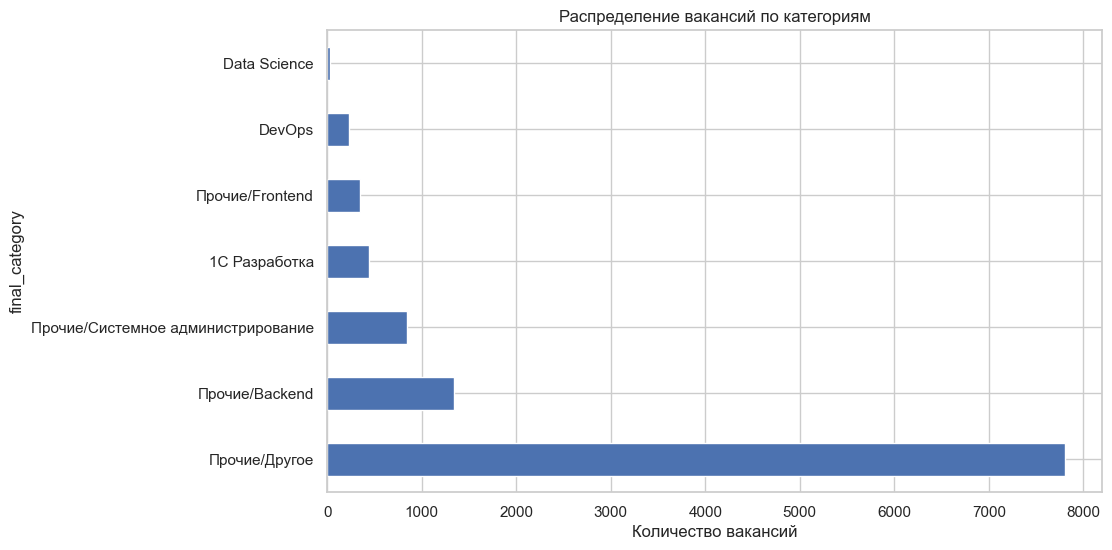

In [288]:
import matplotlib.pyplot as plt

# Строим диаграмму распределения
category_counts = clustered_df['final_category'].value_counts()
plt.figure(figsize=(10,6))
category_counts.plot(kind='barh')
plt.title('Распределение вакансий по категориям')
plt.xlabel('Количество вакансий')
plt.show()

In [289]:
# Проверяем точность для DevOps
devops_sample = clustered_df[clustered_df['final_category'] == 'DevOps'].sample(20)
print("Проверка выборки DevOps:")
for title in devops_sample['vacancy']:
    print(f"- {title}")

Проверка выборки DevOps:
- Системный/сетевой администратор (инженер сопровождения интернет-проектов)
- DevOps-инженер
- DevOps-инженер (Kubernetes)
- .NET-разработчик (Модульпэй)
- Системный администратор Linux
- Junior+/Middle PHP-разработчик (Laravel)
- Тестировщик мобильных приложений
- Golang разработчик
- Ведущий администратор юникс систем
- QA инженер по нагрузочному тестированию (TaskTracker Platform V)
- Data Scientist (Junior)
- Data Engineer
- Frontend разработчик
- Middle+ DevOps
- Разработчик backend (middle)
- Системный администратор (DevOps)
- Java Developer (middle)
- PHP разработчик (Symfony)
- Системный администратор Linux
- DevOps-инженер


#### *Базовая очистка DevOps*

In [293]:
def filter_core_devops(df):
    # Приводим навыки к нижнему регистру для сравнения
    df['skills_lower'] = df['skills_normalized'].apply(
        lambda x: [skill.lower() for skill in x]
    )
    
    # Более гибкие условия:
    # Хотя бы 2 из 3 ключевых навыков: docker, kubernetes, ci/cd
    devops_mask = df['skills_lower'].apply(
        lambda x: sum(skill in x for skill in ['docker', 'kubernetes', 'ci/cd']) >= 2
    ) & ~df['vacancy'].str.lower().str.contains(
        'системный администратор|сетевой инженер|техническая поддержка'
    )
    
    core_devops = df[devops_mask].copy()
    other = df[~devops_mask].copy()
    
    # Статистика
    total_before = len(df)
    total_after = len(core_devops)
    
    print(f"До очистки: {total_before} вакансий")
    print(f"После фильтрации DevOps: {total_after} ({(total_after/total_before)*100:.1f}%)")
    print(f"Примеры отфильтрованных DevOps-вакансий:")
    print(core_devops[['vacancy', 'skills_normalized']].head(3).to_string(index=False))
    
    return core_devops, other

# Применяем
core_devops_df, remaining_df = filter_core_devops(clustered_df)

До очистки: 11048 вакансий
После фильтрации DevOps: 242 (2.2%)
Примеры отфильтрованных DevOps-вакансий:
                       vacancy                                                                                                                                                                                                                                                        skills_normalized
                DevOps инженер                                                                                  [Ansible, Bash, Ceph, ClickHouse, Docker, ELK, Gitlabci, Grafana, Iptables, KVM, Kubernetes, Linux, Lxc, MySQL, Nginx, Opennebula, PostgreSQL, Prometheus, Python, TCP/IP, VPN, Zabbix]
                DevOps-инженер                                                                                                                                                            [Docker, Gitlab, Hashicorp Vault, Kubernetes, Nixos, Безопасность Инфраструктуры, Декларативная Конфигурация]
DevOps. 

In [296]:
def split_devops_subcategories(df):
    # Создаем копию, чтобы избежать предупреждений
    df = df.copy()
    
    # Инициализируем колонку
    df['devops_subtype'] = 'DevOps Core'
    
    # Cloud DevOps (добавляем облачные технологии)
    cloud_tech = ['aws', 'azure', 'gcp', 'terraform', 'cloudformation']
    df.loc[df['skills_normalized'].apply(
        lambda x: any(skill.lower() in cloud_tech for skill in x)
    ), 'devops_subtype'] = 'Cloud DevOps'
    
    # SRE (добавляем инструменты мониторинга)
    sre_tech = ['prometheus', 'grafana', 'sre', 'reliability', 'monitoring']
    df.loc[df['skills_normalized'].apply(
        lambda x: any(skill.lower() in sre_tech for skill in x)
    ), 'devops_subtype'] = 'SRE'
    
    # Security DevOps
    security_tech = ['vault', 'selinux', 'security', 'iam', 'waf']
    df.loc[df['skills_normalized'].apply(
        lambda x: any(skill.lower() in security_tech for skill in x)
    ) | df['vacancy'].str.contains('безопасность|security', case=False),
    'devops_subtype'] = 'Security DevOps'
    
    # MLOps (специфичные для ML инструменты)
    mlops_tech = ['kubeflow', 'mlflow', 'pipeline', 'airflow']
    df.loc[df['skills_normalized'].apply(
        lambda x: any(skill.lower() in mlops_tech for skill in x)
    ), 'devops_subtype'] = 'MLOps'
    
    return df

In [297]:
# Применяем улучшенную категоризацию
devops_categorized = split_devops_subcategories(core_devops_df)

# Выводим распределение
print(devops_categorized['devops_subtype'].value_counts())

# Примеры вакансий для каждой категории
for subtype in devops_categorized['devops_subtype'].unique():
    print(f"\n--- {subtype} ---")
    print(devops_categorized[devops_categorized['devops_subtype'] == subtype]
          [['vacancy', 'skills_normalized']].head(2).to_string(index=False))

devops_subtype
DevOps Core        144
SRE                 65
Cloud DevOps        13
MLOps               13
Security DevOps      7
Name: count, dtype: int64

--- SRE ---
                       vacancy                                                                                                                                                                                                                                                        skills_normalized
                DevOps инженер                                                                                  [Ansible, Bash, Ceph, ClickHouse, Docker, ELK, Gitlabci, Grafana, Iptables, KVM, Kubernetes, Linux, Lxc, MySQL, Nginx, Opennebula, PostgreSQL, Prometheus, Python, TCP/IP, VPN, Zabbix]
DevOps. Для релизного процесса [Ansible, Bash, CI/CD, Docker, Drill, Git, GitLab CI, Go, Grafana, Gravitee, Hadoop, Hdfs, Helm, Jaeger, Kafka, Kubernetes, Kudu, Kustomize, Linux, Loki, Prometheus, Python, Zabbix, Zookeeper, Базы Данных Pos

In [298]:
# Группируем и анализируем
devops_analysis = devops_categorized.groupby('devops_subtype').agg({
    'vacancy': 'count',
    'skills_normalized': lambda x: Counter(
        skill for sublist in x for skill in sublist
    ).most_common(5)
}).rename(columns={'vacancy': 'count'})

# Выводим результаты
print("Финальное распределение:\n")
for subtype, data in devops_analysis.iterrows():
    skills = ", ".join([f"{skill} ({freq})" for skill, freq in data['skills_normalized']])
    print(f"{subtype}: {data['count']} вакансий")
    print(f"Топ-5 навыков: {skills}\n")

Финальное распределение:

Cloud DevOps: 13 вакансий
Топ-5 навыков: Docker (11), Aws (9), PostgreSQL (9), CI/CD (8), Kubernetes (7)

DevOps Core: 144 вакансий
Топ-5 навыков: Docker (138), CI/CD (90), Git (83), Kubernetes (76), PostgreSQL (58)

MLOps: 13 вакансий
Топ-5 навыков: Docker (12), Python (12), Airflow (11), Kubernetes (11), SQL (8)

SRE: 65 вакансий
Топ-5 навыков: Docker (65), Grafana (59), Kubernetes (57), Prometheus (52), PostgreSQL (40)

Security DevOps: 7 вакансий
Топ-5 навыков: Kubernetes (6), Docker (5), PostgreSQL (4), Java (4), Security (4)



In [302]:
new_categories = {
    # Графический дизайн
    'Graphic Design': {
        'skills': ['photoshop', 'illustrator', 'coreldraw', 'figma', 'adobe xd'],
        'titles': ['графический дизайнер', 'дизайнер', 'illustrator'],
        'exclude': ['web design', 'ui/ux']
    },
    
    # 1С специалисты (не разработчики)
    '1C Specialists': {
        'skills': ['1с', 'бухгалтерия', 'зуп', 'erp', 'конфигурирование'],
        'titles': ['1с специалист', '1с консультант', 'внедрение 1с'],
        'exclude': ['разработчик', 'developer']
    },
    
    # IT-преподавание
    'IT Education': {
        'skills': ['преподавание', 'обучение', 'курсы', 'mentoring'],
        'titles': ['преподаватель it', 'тренер it', 'инструктор it'],
        'required': ['python', 'java', 'c#', '1с']
    }
}

In [299]:
extended_categories = {
    # 1. Backend Development
    'Backend Development': {
        'skills': ['python', 'java', 'c#', 'php', 'ruby', 'node.js', 'go', 'scala'],
        'titles': ['backend', 'бэкенд', 'разработчик серверной части'],
        'priority': 1,
        'subcategories': {
            'Python Backend': {
                'skills': ['python', 'django', 'flask', 'fastapi'],
                'titles': ['python developer']
            },
            'Java Backend': {
                'skills': ['java', 'spring', 'hibernate'],
                'titles': ['java developer']
            },
            '.NET Backend': {
                'skills': ['c#', 'asp.net', '.net core'],
                'titles': ['.net developer']
            }
        }
    },
    
    # 2. Frontend Development
    'Frontend Development': {
        'skills': ['javascript', 'typescript', 'react', 'angular', 'vue.js', 'html', 'css'],
        'titles': ['frontend', 'фронтенд', 'веб-разработчик'],
        'priority': 1,
        'subcategories': {
            'React Developer': {
                'skills': ['react', 'redux'],
                'titles': ['react developer']
            },
            'Angular Developer': {
                'skills': ['angular'],
                'titles': ['angular developer']
            },
            'Vue.js Developer': {
                'skills': ['vue.js'],
                'titles': ['vue developer']
            }
        }
    },
    
    # 3. Data Science (расширенная)
    'Data Science': {
        'skills': ['python', 'pandas', 'numpy', 'ml', 'ai', 'tensorflow', 'pytorch'],
        'titles': ['data science', 'machine learning', 'ml engineer'],
        'subcategories': {
            'Computer Vision': {
                'skills': ['opencv', 'computer vision', 'image processing'],
                'titles': ['computer vision engineer']
            },
            'NLP': {
                'skills': ['nlp', 'natural language processing', 'bert'],
                'titles': ['nlp engineer']
            }
        }
    },
    
    # 4. DevOps (уже реализовано)
    'DevOps': {
        'skills': ['docker', 'kubernetes', 'ansible', 'terraform', 'ci/cd'],
        'titles': ['devops', 'sre', 'инженер инфраструктуры'],
        'priority': 1
    },
    
    # 5. QA и тестирование
    'QA & Testing': {
        'skills': ['testing', 'qa', 'selenium', 'junit', 'testng', 'postman'],
        'titles': ['qa engineer', 'тестировщик', 'test engineer'],
        'subcategories': {
            'Automation QA': {
                'skills': ['automation', 'selenium', 'appium'],
                'titles': ['automation qa']
            },
            'Manual QA': {
                'skills': ['manual testing', 'test cases'],
                'titles': ['manual qa']
            }
        }
    },
    
    # 6. Системное администрирование
    'System Administration': {
        'skills': ['linux', 'windows server', 'active directory', 'vmware', 'hyper-v'],
        'titles': ['system administrator', 'системный администратор'],
        'subcategories': {
            'Linux Admin': {
                'skills': ['linux', 'bash', 'centos', 'ubuntu'],
                'titles': ['linux administrator']
            },
            'Windows Admin': {
                'skills': ['windows server', 'active directory'],
                'titles': ['windows administrator']
            }
        }
    },
    
    # 7. Бизнес-аналитика
    'Business Analytics': {
        'skills': ['sql', 'excel', 'power bi', 'tableau', 'bi'],
        'titles': ['business analyst', 'бизнес-аналитик'],
        'exclude': ['data science']
    },
    
    # 8. Мобильная разработка
    'Mobile Development': {
        'skills': ['android', 'ios', 'kotlin', 'swift', 'flutter', 'react native'],
        'titles': ['mobile developer', 'android developer', 'ios developer'],
        'subcategories': {
            'Android': {
                'skills': ['android', 'kotlin', 'java'],
                'titles': ['android developer']
            },
            'iOS': {
                'skills': ['ios', 'swift'],
                'titles': ['ios developer']
            },
            'Cross-platform': {
                'skills': ['flutter', 'react native'],
                'titles': ['flutter developer', 'react native developer']
            }
        }
    },
    
    # 9. Базовые IT-роли
    'IT Support': {
        'skills': ['helpdesk', 'technical support', 'troubleshooting'],
        'titles': ['it support', 'техническая поддержка']
    }
}

In [303]:
# Объединяем с существующими категориями
extended_categories.update(new_categories)

In [304]:
#  Добавляем уточнения для Backend
extended_categories['Backend Development']['exclude'] = ['1с', 'бухгалтерия']
extended_categories['Backend Development']['subcategories']['1C Developer'] = {
    'skills': ['1с', '1с 8', '1с предприятие'],
    'titles': ['1с разработчик', '1с программист']
}

# 3. Функция для уточнения "Прочих"
def refine_others(row):
    if row['main_category'] != 'Прочие':
        return row['main_category'], row.get('sub_category', '')
    
    skills = [s.lower() for s in row['skills_normalized']]
    title = row['vacancy'].lower()
    
    # Графический дизайн
    if any(d in title for d in ['дизайнер', 'designer']):
        if any(s in skills for s in ['photoshop', 'illustrator']):
            return 'Graphic Design', 'General'
    
    # 1С (не разработка)
    if ('1с' in title or '1c' in title) and 'разработчик' not in title:
        return '1C Specialists', 'General'
    
    # IT-преподавание
    if any(e in title for e in ['преподаватель', 'тренер', 'инструктор']):
        if any(s in skills for s in ['python', 'java', 'c#', '1с']):
            return 'IT Education', 'General'
    
    return 'Прочие', ''

In [305]:
def enhanced_categorization(row):
    """Улучшенная категоризация с подкатегориями"""
    best_category = 'Прочие'
    best_subcategory = ''
    best_score = 0
    
    # Проверяем все категории
    for category, rules in extended_categories.items():
        current_score = calculate_category_score(row, rules)
        
        # Проверяем подкатегории если есть
        subcategory_score = 0
        best_sub = ''
        if 'subcategories' in rules:
            for sub_name, sub_rules in rules['subcategories'].items():
                sub_score = calculate_category_score(row, sub_rules)
                if sub_score > subcategory_score:
                    subcategory_score = sub_score
                    best_sub = sub_name
        
        # Общий балл (основная категория + подкатегория)
        total_score = current_score + subcategory_score * 0.7
        
        if total_score > best_score:
            best_score = total_score
            best_category = category
            best_subcategory = best_sub if subcategory_score > 10 else ''
    
    # Минимальный порог
    if best_score < 15:
        return 'Прочие', ''
    
    # Формируем итоговую категорию
    if best_subcategory:
        return best_category, best_subcategory
    return best_category, 'General'

# Применяем улучшенную категоризацию
clustered_df['main_category'], clustered_df['sub_category'] = zip(*clustered_df.apply(enhanced_categorization, axis=1))

In [306]:
def analyze_enhanced_results(df):
    results = {}
    for main_cat in df['main_category'].unique():
        subset = df[df['main_category'] == main_cat]
        
        # Собираем подкатегории если есть
        subcats = {}
        if 'sub_category' in subset.columns:
            for sub_cat in subset['sub_category'].unique():
                if sub_cat:  # пропускаем пустые
                    sub_subset = subset[subset['sub_category'] == sub_cat]
                    skills = Counter([s for lst in sub_subset['skills_normalized'] for s in lst])
                    subcats[sub_cat] = {
                        'count': len(sub_subset),
                        'top_skills': [f"{s[0]} ({s[1]})" for s in skills.most_common(3)]
                    }
        
        skills = Counter([s for lst in subset['skills_normalized'] for s in lst])
        
        results[main_cat] = {
            'count': len(subset),
            'top_skills': [f"{s[0]} ({s[1]})" for s in skills.most_common(5)],
            'subcategories': subcats,
            'sample_titles': subset['vacancy'].sample(3).tolist()
        }
    
    return dict(sorted(results.items(), key=lambda x: -x[1]['count']))

# Выводим результаты
analysis_results = analyze_enhanced_results(clustered_df)
for category, data in analysis_results.items():
    print(f"\n**{category}** ({data['count']} вакансий)")
    print("Топ навыки:", ", ".join(data['top_skills']))
    
    if data['subcategories']:
        print("Подкатегории:")
        for sub, sub_data in data['subcategories'].items():
            print(f"  - {sub}: {sub_data['count']} вакансий, навыки: {', '.join(sub_data['top_skills'])}")
    
    print("Примеры должностей:", ", ".join(data['sample_titles']))


**Прочие** (5658 вакансий)
Топ навыки: 1C (605), Excel (470), SQL (386), Adobe Photoshop (302), Ms Office (248)
Примеры должностей: Ведущий специалист по продукту, Менеджер по отчетности, Программист 1С

**Backend Development** (3220 вакансий)
Топ навыки: Git (622), PostgreSQL (593), SQL (471), Docker (470), Python (457)
Подкатегории:
  - Python Backend: 2263 вакансий, навыки: Git (499), PostgreSQL (480), Docker (394)
  - General: 928 вакансий, навыки: SQL (121), Git (112), PostgreSQL (96)
  - Java Backend: 20 вакансий, навыки: Java (16), Docker (12), Kafka (12)
  - .NET Backend: 9 вакансий, навыки: PostgreSQL (6), Aspnet Core (4), C (4)
Примеры должностей: Бизнес-аналитик/Системный аналитик, Backend-разработчик, Junior С# разработчик

**Frontend Development** (922 вакансий)
Топ навыки: 1C (217), Git (162), Скд (151), JavaScript (132), TypeScript (127)
Подкатегории:
  - React Developer: 538 вакансий, навыки: 1C (128), Git (109), Скд (97)
  - General: 383 вакансий, навыки: 1C (89), Jav

In [307]:
def extract_1c_specialists(df):
    df = df.copy()
    
    # Создаем маску для 1С-специалистов (не разработчиков)
    mask = (
        df['vacancy'].str.contains('1[сc]', case=False, regex=True) &
        ~df['vacancy'].str.contains('разработчик|программист|developer', case=False) &
        (df['main_category'] == 'Прочие')
    )
    
    # Создаем новую категорию
    df.loc[mask, 'main_category'] = '1C Specialists'
    df.loc[mask, 'sub_category'] = 'General'
    
    return df

# Применяем и проверяем
clustered_df = extract_1c_specialists(clustered_df)
print(f"1C Specialists выделено: {(clustered_df['main_category'] == '1C Specialists').sum()} вакансий")
print(f"Осталось в 'Прочие': {(clustered_df['main_category'] == 'Прочие').sum()}")

1C Specialists выделено: 432 вакансий
Осталось в 'Прочие': 5226


In [308]:
def extract_office_it(df):
    df = df.copy()
    
    office_keywords = [
        'офис-менеджер', 'администратор', 'секретарь', 
        'менеджер по отчетности', 'специалист по продукту'
    ]
    
    office_skills = ['excel', 'word', 'powerpoint', 'ms office', '1с']
    
    mask = (
        df['vacancy'].str.contains('|'.join(office_keywords), case=False) |
        df['skills_normalized'].apply(lambda x: any(skill in office_skills for skill in x))
    ) & (df['main_category'] == 'Прочие')
    
    df.loc[mask, 'main_category'] = 'Office IT'
    df.loc[mask, 'sub_category'] = 'General'
    
    return df

clustered_df = extract_office_it(clustered_df)
print(f"Office IT выделено: {(clustered_df['main_category'] == 'Office IT').sum()}")

Office IT выделено: 279


In [309]:
def extract_business_analysts(df):
    df = df.copy()
    
    ba_titles = [
        'бизнес-аналитик', 'системный аналитик', 
        'аналитик данных', 'product analyst'
    ]
    
    ba_skills = ['sql', 'excel', 'power bi', 'tableau', 'python']
    
    mask = (
        df['vacancy'].str.contains('|'.join(ba_titles), case=False) |
        df['skills_normalized'].apply(lambda x: any(skill in ba_skills for skill in x))
    ) & (df['main_category'] == 'Прочие')
    
    df.loc[mask, 'main_category'] = 'Business Analytics'
    df.loc[mask, 'sub_category'] = 'General'
    
    return df

clustered_df = extract_business_analysts(clustered_df)
print(f"Business Analytics выделено: {(clustered_df['main_category'] == 'Business Analytics').sum()}")

Business Analytics выделено: 208


In [310]:
def extract_it_support(df):
    df = df.copy()
    
    support_titles = [
        'техническая поддержка', 'it support', 
        'helpdesk', 'service desk', 'инженер поддержки'
    ]
    
    support_skills = ['windows', 'linux', 'troubleshooting', 'remote support']
    
    mask = (
        df['vacancy'].str.contains('|'.join(support_titles), case=False) |
        df['skills_normalized'].apply(lambda x: any(skill in support_skills for skill in x))
    ) & (df['main_category'] == 'Прочие')
    
    df.loc[mask, 'main_category'] = 'IT Support'
    df.loc[mask, 'sub_category'] = 'General'
    
    return df

clustered_df = extract_it_support(clustered_df)
print(f"IT Support выделено: {(clustered_df['main_category'] == 'IT Support').sum()}")

IT Support выделено: 14


In [311]:
print("\nИтоговое распределение:")
print(clustered_df['main_category'].value_counts())

# Анализ оставшихся "Прочих"
remaining_others = clustered_df[clustered_df['main_category'] == 'Прочие']
print("\nТоп вакансий в 'Прочие':")
print(remaining_others['vacancy'].value_counts().head(20))


Итоговое распределение:
main_category
Прочие                   4725
Backend Development      3220
Frontend Development      922
System Administration     842
1C Specialists            432
Office IT                 279
Graphic Design            234
Business Analytics        208
QA & Testing              149
Mobile Development         17
IT Support                 14
Data Science                6
Name: count, dtype: int64

Топ вакансий в 'Прочие':
vacancy
Программист 1С                               200
Специалист технической поддержки             182
Дизайнер                                      87
Графический дизайнер                          67
Инженер технической поддержки                 57
Менеджер проектов                             42
Инженер-программист                           40
Аналитик                                      40
Специалист поддержки                          36
Программист 1C                                30
Дизайнер-верстальщик                          29
Ди

In [312]:
def refine_1c_categories(df):
    df = df.copy()
    
    # 1. Разделяем 1С разработчиков и консультантов
    mask_dev = (
        df['vacancy'].str.contains('1[сc]', case=False, regex=True) &
        df['vacancy'].str.contains('разработчик|программист|developer', case=False)
    )
    
    mask_consult = (
        df['vacancy'].str.contains('1[сc]', case=False, regex=True) &
        ~df['vacancy'].str.contains('разработчик|программист|developer', case=False)
    )
    
    # 2. Переносим в соответствующие категории
    df.loc[mask_dev & (df['main_category'] == 'Прочие'), 'main_category'] = 'Backend Development'
    df.loc[mask_dev & (df['main_category'] == 'Прочие'), 'sub_category'] = '1C Developer'
    
    df.loc[mask_consult & (df['main_category'] == 'Прочие'), 'main_category'] = '1C Specialists'
    
    return df

clustered_df = refine_1c_categories(clustered_df)
print(f"Уточнено 1С-ролей: {((clustered_df['main_category'] == '1C Specialists').sum() + (clustered_df['sub_category'] == '1C Developer').sum())}")
print(f"Осталось в 'Прочие': {(clustered_df['main_category'] == 'Прочие').sum()}")

Уточнено 1С-ролей: 432
Осталось в 'Прочие': 4220


In [313]:
def extract_technical_writers(df):
    df = df.copy()
    
    mask = (
        df['vacancy'].str.contains('технический писатель|technical writer', case=False) |
        df['skills_normalized'].apply(lambda x: any(skill in ['техническая документация', 'конфигурация'] for skill in x))
    ) & (df['main_category'] == 'Прочие')
    
    df.loc[mask, 'main_category'] = 'Technical Writing'
    df.loc[mask, 'sub_category'] = 'General'
    
    return df

clustered_df = extract_technical_writers(clustered_df)
print(f"Technical Writing выделено: {(clustered_df['main_category'] == 'Technical Writing').sum()}")

Technical Writing выделено: 56


In [314]:
def extract_project_managers(df):
    df = df.copy()
    
    pm_keywords = [
        'менеджер проектов', 'project manager', 
        'руководитель it проектов', 'pm'
    ]
    
    pm_skills = ['jira', 'confluence', 'scrum', 'agile']
    
    mask = (
        df['vacancy'].str.contains('|'.join(pm_keywords), case=False) |
        df['skills_normalized'].apply(lambda x: any(skill in pm_skills for skill in x))
    ) & (df['main_category'] == 'Прочие')
    
    df.loc[mask, 'main_category'] = 'Project Management'
    df.loc[mask, 'sub_category'] = 'IT'
    
    return df

clustered_df = extract_project_managers(clustered_df)
print(f"Project Management выделено: {(clustered_df['main_category'] == 'Project Management').sum()}")

Project Management выделено: 163


In [315]:
def extract_uiux_designers(df):
    df = df.copy()
    
    uiux_keywords = [
        'ui/ux', 'ux/ui', 'user interface', 
        'user experience', 'веб-дизайнер'
    ]
    
    uiux_skills = ['figma', 'sketch', 'adobe xd', 'прототипирование']
    
    mask = (
        df['vacancy'].str.contains('|'.join(uiux_keywords), case=False) |
        df['skills_normalized'].apply(lambda x: any(skill in uiux_skills for skill in x))
    ) & (df['main_category'] == 'Прочие')
    
    df.loc[mask, 'main_category'] = 'UI/UX Design'
    df.loc[mask, 'sub_category'] = 'General'
    
    return df

clustered_df = extract_uiux_designers(clustered_df)
print(f"UI/UX Design выделено: {(clustered_df['main_category'] == 'UI/UX Design').sum()}")

UI/UX Design выделено: 63


In [316]:
# В новой ячейке
print("\nФинальное распределение:")
print(clustered_df['main_category'].value_counts())

# Анализ оставшихся "Прочих"
remaining_others = clustered_df[clustered_df['main_category'] == 'Прочие']
print("\nТоп вакансий в 'Прочие' после всех улучшений:")
print(remaining_others['vacancy'].value_counts().head(20))


Финальное распределение:
main_category
Прочие                   3938
Backend Development      3725
Frontend Development      922
System Administration     842
1C Specialists            432
Office IT                 279
Graphic Design            234
Business Analytics        208
Project Management        163
QA & Testing              149
UI/UX Design               63
Technical Writing          56
Mobile Development         17
IT Support                 14
Data Science                6
Name: count, dtype: int64

Топ вакансий в 'Прочие' после всех улучшений:
vacancy
Специалист технической поддержки                                 182
Дизайнер                                                          87
Графический дизайнер                                              67
Инженер технической поддержки                                     57
Инженер-программист                                               40
Аналитик                                                          40
Специалист подд

In [317]:
def refine_tech_support(df):
    df = df.copy()
    
    support_keywords = [
        'техническая поддержка', 'техподдержка', 'it support',
        'helpdesk', 'service desk', 'инженер поддержки',
        'клиентской поддержки', 'поддержки клиентов'
    ]
    
    mask = (
        df['vacancy'].str.contains('|'.join(support_keywords), case=False) &
        (df['main_category'] == 'Прочие')
    )
    
    # Разделяем на обычную и IT-поддержку
    it_mask = mask & df['skills_normalized'].apply(
        lambda x: any(skill in ['linux', 'windows', '1с'] for skill in x))
    
    df.loc[it_mask, 'main_category'] = 'IT Support'
    df.loc[it_mask, 'sub_category'] = 'Technical'
    
    df.loc[mask & ~it_mask, 'main_category'] = 'Customer Support'
    
    return df

clustered_df = refine_tech_support(clustered_df)
print(f"Уточнено Support-ролей: {(clustered_df['main_category'].isin(['IT Support', 'Customer Support'])).sum()}")

Уточнено Support-ролей: 77


In [318]:
def refine_design_categories(df):
    df = df.copy()
    
    # 1. Веб-дизайн
    web_mask = (
        df['vacancy'].str.contains('веб-дизайнер|web designer', case=False) |
        df['skills_normalized'].apply(lambda x: any(skill in ['figma', 'adobe xd'] for skill in x))
    ) & (df['main_category'] == 'Прочие')
    
    # 2. Интерьер-дизайн
    interior_mask = df['vacancy'].str.contains(
        'интерьер|interior|дизайнер помещений', case=False)
    
    # 3. Верстка
    layout_mask = df['vacancy'].str.contains('верстальщик|layout', case=False)
    
    df.loc[web_mask, 'main_category'] = 'UI/UX Design'
    df.loc[interior_mask, 'main_category'] = 'Interior Design'
    df.loc[layout_mask, 'main_category'] = 'Graphic Design'
    df.loc[layout_mask, 'sub_category'] = 'Layout'
    
    return df

clustered_df = refine_design_categories(clustered_df)
print("Дизайнерские категории уточнены")

Дизайнерские категории уточнены


In [319]:
def extract_engineer_programmers(df):
    df = df.copy()
    
    eng_keywords = [
        'инженер-программист', 'программист-инженер',
        'engineer programmer', 'software engineer'
    ]
    
    mask = (
        df['vacancy'].str.contains('|'.join(eng_keywords), case=False) &
        (df['main_category'] == 'Прочие')
    )
    
    # Определяем специализацию по навыкам
    fe_mask = mask & df['skills_normalized'].apply(
        lambda x: any(skill in ['javascript', 'react'] for skill in x))
    
    be_mask = mask & df['skills_normalized'].apply(
        lambda x: any(skill in ['python', 'java', 'c#'] for skill in x))
    
    df.loc[fe_mask, 'main_category'] = 'Frontend Development'
    df.loc[be_mask, 'main_category'] = 'Backend Development'
    df.loc[mask & ~fe_mask & ~be_mask, 'main_category'] = 'Software Engineering'
    
    return df

clustered_df = extract_engineer_programmers(clustered_df)
print(f"Инженеры-программисты распределены")

Инженеры-программисты распределены


In [320]:
def extract_cybersecurity(df):
    df = df.copy()
    
    sec_keywords = [
        'информационной безопасности', 'кибербезопасность',
        'security engineer', 'cybersecurity'
    ]
    
    sec_skills = [
        'siem', 'soc', 'kaspersky', 'waf', 
        'firewall', 'iso 27001'
    ]
    
    mask = (
        df['vacancy'].str.contains('|'.join(sec_keywords), case=False) |
        df['skills_normalized'].apply(lambda x: any(skill in sec_skills for skill in x))
    ) & (df['main_category'] == 'Прочие')
    
    df.loc[mask, 'main_category'] = 'Cybersecurity'
    df.loc[mask, 'sub_category'] = 'General'
    
    return df

clustered_df = extract_cybersecurity(clustered_df)
print(f"Cybersecurity выделено: {(clustered_df['main_category'] == 'Cybersecurity').sum()}")

Cybersecurity выделено: 72


In [321]:
def final_cleanup(df):
    df = df.copy()
    
    # 1. Аналитики
    analyst_mask = (
        df['vacancy'].str.contains('аналитик|analyst', case=False) &
        ~df['vacancy'].str.contains('бизнес', case=False) &
        (df['main_category'] == 'Прочие')
    )
    
    # 2. Сетевые инженеры
    network_mask = (
        df['vacancy'].str.contains('сетевой инженер|network engineer', case=False) |
        df['skills_normalized'].apply(lambda x: any(skill in ['cisco', 'mikrotik'] for skill in x))
    )
    
    df.loc[analyst_mask, 'main_category'] = 'Data Analysis'
    df.loc[network_mask, 'main_category'] = 'System Administration'
    df.loc[network_mask, 'sub_category'] = 'Network'
    
    # 3. Технические директора
    df.loc[df['vacancy'].str.contains('технический директор|cto', case=False), 'main_category'] = 'IT Management'
    
    return df

clustered_df = final_cleanup(clustered_df)
print("Финальная очистка выполнена")

Финальная очистка выполнена


In [322]:
print("\nИтоговое распределение после всех шагов:")
print(clustered_df['main_category'].value_counts())

remaining_others = clustered_df[clustered_df['main_category'] == 'Прочие']
print(f"\nОсталось в 'Прочие': {len(remaining_others)}")
print("\nТоп оставшихся:")
print(remaining_others['vacancy'].value_counts().head(10))


Итоговое распределение после всех шагов:
main_category
Backend Development      3641
Прочие                   3216
Frontend Development      916
System Administration     900
1C Specialists            432
Graphic Design            312
Data Analysis             311
Office IT                 279
Business Analytics        208
Project Management        163
QA & Testing              149
Software Engineering      106
Interior Design            85
Cybersecurity              72
UI/UX Design               63
Customer Support           63
Technical Writing          56
IT Management              39
Mobile Development         17
IT Support                 14
Data Science                6
Name: count, dtype: int64

Осталось в 'Прочие': 3216

Топ оставшихся:
vacancy
Специалист технической поддержки               182
Дизайнер                                        87
Графический дизайнер                            67
Инженер технической поддержки                   57
Специалист поддержки            

In [323]:
def create_tech_support_category(df):
    df = df.copy()
    
    tech_support_mask = (
        df['vacancy'].str.contains(
            'техническ(ий|ая) поддержк(а|и)|техподдержк(а|и)|support engineer', 
            case=False, regex=True
        ) &
        (df['main_category'] == 'Прочие')
    )
    
    df.loc[tech_support_mask, 'main_category'] = 'Technical Support'
    df.loc[tech_support_mask, 'sub_category'] = df.loc[tech_support_mask, 'skills_normalized'].apply(
        lambda x: 'IT' if any(skill in ['linux', 'windows', '1с'] for skill in x) else 'General'
    )
    
    return df

clustered_df = create_tech_support_category(clustered_df)
print(f"Technical Support выделено: {(clustered_df['main_category'] == 'Technical Support').sum()}")

Technical Support выделено: 23


C:\Users\olga\AppData\Local\Temp\ipykernel_10328\2974652436.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['vacancy'].str.contains(


In [324]:
def refine_design_categories_final(df):
    df = df.copy()
    
    # Графические дизайнеры
    graphic_mask = (
        df['vacancy'].str.contains('графический дизайнер|graphic designer', case=False) &
        (df['main_category'] == 'Прочие')
    )
    
    # UI/UX дизайнеры
    uiux_mask = (
        df['vacancy'].str.contains('ui/ux|ux/ui|user interface|user experience', case=False) &
        (df['main_category'] == 'Прочие')
    )
    
    df.loc[graphic_mask, 'main_category'] = 'Graphic Design'
    df.loc[uiux_mask, 'main_category'] = 'UI/UX Design'
    
    return df

clustered_df = refine_design_categories_final(clustered_df)
print("Дизайнерские категории уточнены")

Дизайнерские категории уточнены


In [325]:
def create_product_management_category(df):
    df = df.copy()
    
    product_mask = (
        df['vacancy'].str.contains(
            'менеджер по продукту|product manager|продакт менеджер', 
            case=False
        ) &
        (df['main_category'] == 'Прочие')
    )
    
    df.loc[product_mask, 'main_category'] = 'Product Management'
    
    return df

clustered_df = create_product_management_category(clustered_df)
print(f"Product Management выделено: {(clustered_df['main_category'] == 'Product Management').sum()}")

Product Management выделено: 48


In [326]:
def process_remaining_analysts(df):
    df = df.copy()
    
    analyst_mask = (
        df['vacancy'].str.contains('аналитик|analyst', case=False) &
        (df['main_category'] == 'Прочие')
    )
    
    # Разделение по типам аналитиков
    ba_mask = analyst_mask & df['vacancy'].str.contains('бизнес', case=False)
    data_mask = analyst_mask & df['skills_normalized'].apply(
        lambda x: any(skill in ['sql', 'python'] for skill in x))
    
    df.loc[ba_mask, 'main_category'] = 'Business Analytics'
    df.loc[data_mask, 'main_category'] = 'Data Analysis'
    df.loc[analyst_mask & ~ba_mask & ~data_mask, 'main_category'] = 'General Analytics'
    
    return df

clustered_df = process_remaining_analysts(clustered_df)
print("Аналитики распределены")

Аналитики распределены


In [327]:
def final_categorization(df):
    df = df.copy()
    
    # 1. IT-менеджеры
    it_manager_mask = (
        df['vacancy'].str.contains('руководитель it|it manager', case=False) &
        (df['main_category'] == 'Прочие')
    )
    
    # 2. Junior позиции
    junior_mask = (
        df['vacancy'].str.contains(
            'начинающий|junior|стажер|intern|assistant', 
            case=False
        ) &
        (df['main_category'] == 'Прочие')
    )
    
    df.loc[it_manager_mask, 'main_category'] = 'IT Management'
    df.loc[junior_mask, 'main_category'] = 'Junior Positions'
    
    # 3. Все остальное в "Other"
    df.loc[df['main_category'] == 'Прочие', 'main_category'] = 'Other'
    
    return df

clustered_df = final_categorization(clustered_df)
print("Финальная категоризация выполнена")

Финальная категоризация выполнена


In [328]:
print("\nФинальное распределение категорий:")
print(clustered_df['main_category'].value_counts())

print("\nТоп в категории 'Other':")
if 'Other' in clustered_df['main_category'].value_counts():
    other_df = clustered_df[clustered_df['main_category'] == 'Other']
    print(other_df['vacancy'].value_counts().head(10))
else:
    print("Категория 'Other' пуста")


Финальное распределение категорий:
main_category
Backend Development      3641
Other                    2850
Frontend Development      916
System Administration     900
1C Specialists            432
Graphic Design            419
Data Analysis             311
Office IT                 279
Business Analytics        240
Project Management        163
Junior Positions          151
QA & Testing              149
Software Engineering      106
Interior Design            85
Cybersecurity              72
UI/UX Design               63
Customer Support           63
Technical Writing          56
Product Management         48
IT Management              44
Technical Support          23
Mobile Development         17
IT Support                 14
Data Science                6
Name: count, dtype: int64

Топ в категории 'Other':
vacancy
Специалист технической поддержки           182
Дизайнер                                    87
Инженер технической поддержки               57
Специалист поддержки         

In [329]:
# В новой ячейке
skill_synonyms = {
    'javascript': ['js', 'ecmascript'],
    'typescript': ['ts'],
    'c++': ['с++', 'cpp'],
    'c#': ['с#', 'c sharp'],
    '1с': ['1c', '1с предприятие', '1с 8'],
    'python': ['питон'],
    'sql': ['базы данных'],
    'git': ['гит'],
    'photoshop': ['adobe photoshop'],
    'illustrator': ['adobe illustrator']
}

category_skill_weights = {
    'Backend Development': {
        'python': 1.5, 'java': 1.4, 'c#': 1.3, 'go': 1.2,
        'docker': 1.3, 'kubernetes': 1.2, 'postgresql': 1.1,
        ('python', 'django'): 2.0, ('java', 'spring'): 2.0
    },
    'Frontend Development': {
        'javascript': 1.5, 'typescript': 1.4, 'react': 1.8,
        'angular': 1.7, 'vue': 1.6, 'css': 1.2,
        ('javascript', 'react'): 2.2, ('typescript', 'angular'): 2.1
    },
    'Data Science': {
        'python': 1.6, 'pandas': 1.8, 'numpy': 1.5,
        'tensorflow': 1.9, 'pytorch': 1.9, 'sql': 1.3,
        ('python', 'pandas'): 2.3, ('python', 'machine learning'): 2.4
    },
    'System Administration': {
        'linux': 1.7, 'windows': 1.5, 'docker': 1.4,
        'bash': 1.3, 'zabbix': 1.2, 'cisco': 1.6,
        ('linux', 'bash'): 2.1, ('windows', 'active directory'): 2.0
    }
}

required_combinations = {
    'Backend Development': [('python', 'django'), ('java', 'spring')],
    'Data Science': [('python', 'pandas'), ('python', 'numpy')],
    'DevOps': [('docker', 'kubernetes'), ('ci/cd', 'terraform')]
}

In [330]:
def normalize_skills(skills):
    normalized = []
    for skill in skills:
        skill_lower = skill.lower()
        # Ищем синонимы
        found = False
        for base_name, synonyms in skill_synonyms.items():
            if skill_lower == base_name or skill_lower in synonyms:
                normalized.append(base_name)
                found = True
                break
        if not found:
            normalized.append(skill_lower)
    return normalized

In [336]:
def calculate_category_score(row, category_name):
    """Расчет веса категории с учетом подкатегорий"""
    # Получаем правила для категории
    if category_name in extended_categories:
        category_rules = extended_categories[category_name]
    else:
        # Ищем подкатегорию в родительских категориях
        for parent_cat in extended_categories.values():
            if 'subcategories' in parent_cat and category_name in parent_cat['subcategories']:
                category_rules = parent_cat['subcategories'][category_name]
                break
        else:
            return 0  # Если категория не найдена
    
    skills = normalize_skills(row['skills_normalized'])
    title = row['vacancy'].lower()
    weights = category_skill_weights.get(category_name, {})
    
    # Базовый вес по навыкам
    skill_score = 0
    for skill in skills:
        skill_score += weights.get(skill, 1.0)
    
    # Бонус за комбинации навыков
    combo_bonus = 0
    for combo in required_combinations.get(category_name, []):
        if all(c in skills for c in combo):
            combo_bonus += weights.get(combo, 3.0)
    
    # Учет названия вакансии
    title_score = 2.0 if any(kw in title for kw in category_rules.get('titles', [])) else 0
    
    # Итоговый вес
    total_score = skill_score + combo_bonus + title_score
    
    # Штраф за исключения
    if 'exclude' in category_rules:
        if any(excl in title for excl in category_rules['exclude']):
            total_score *= 0.3
    
    return total_score

def enhanced_categorization(row):
    best_category = 'Other'
    best_subcategory = ''
    best_score = 0
    
    for category_name, category_rules in extended_categories.items():
        current_score = calculate_category_score(row, category_name)
        
        # Уменьшаем коэффициент для подкатегорий с 0.7 до 0.5
        if 'subcategories' in category_rules:
            subcategory_score = max(
                calculate_category_score(row, sub_name) 
                for sub_name in category_rules['subcategories']
            )
            current_score += subcategory_score * 0.5  # Было 0.7
        
        # Понижаем минимальный порог с 15 до 10
        if current_score > best_score:
            best_score = current_score
            best_category = category_name
    
    return best_category if best_score >= 10 else 'Other'  # Было 15
    

In [337]:
# Новая функция calculate_category_score:

def calculate_category_score(row, category_name):
    # Объединяем правила основной категории и подкатегории
    rules = {}
    for main_cat in extended_categories.values():
        if category_name in main_cat.get('subcategories', {}):
            rules.update(main_cat['subcategories'][category_name])
            rules['titles'] = main_cat['titles'] + rules.get('titles', [])
            break
        elif category_name in extended_categories:
            rules = extended_categories[category_name]
            break
    
    if not rules:
        return 0
    
    skills = normalize_skills(row['skills_normalized'])
    title = row['vacancy'].lower()
    
    # Упрощенный расчет веса
    score = sum(
        1.5 if skill in rules.get('skills', []) else 0.5  # Базовые веса вместо сложной системы
        for skill in skills
    )
    
    # Добавляем бонус за соответствие названия
    if any(kw in title for kw in rules.get('titles', [])):
        score += 3  # Было 2
    
    return score

In [338]:
# Обновляем required_combinations:

required_combinations.update({
    '1C Specialists': [
        ('1с', 'бухгалтерия'), 
        ('1с', 'erp')
    ],
    'Technical Support': [
        ('windows', 'helpdesk'),
        ('linux', 'troubleshooting')
    ],
    'Graphic Design': [
        ('photoshop', 'illustrator'),
        ('figma', 'ui/ux')
    ]
})

In [339]:
def fix_specific_others(df):
    # 1. 1С специалисты
    df.loc[
        df['vacancy'].str.contains('1[сc]', regex=True) & 
        ~df['vacancy'].str.contains('разработчик|программист') &
        (df['main_category'] == 'Other'),
        'main_category'
    ] = '1C Specialists'
    
    # 2. Графические дизайнеры
    df.loc[
        df['vacancy'].str.contains('дизайнер|designer') &
        df['skills_normalized'].apply(lambda x: any(s in ['photoshop', 'illustrator'] for s in x)) &
        (df['main_category'] == 'Other'),
        'main_category'
    ] = 'Graphic Design'
    
    # 3. Техподдержка
    df.loc[
        df['vacancy'].str.contains('техническая поддержка|helpdesk') &
        (df['main_category'] == 'Other'),
        'main_category'
    ] = 'Technical Support'
    
    return df

clustered_df = fix_specific_others(clustered_df)

In [340]:
print("Итоговое распределение:")
print(clustered_df['main_category'].value_counts())

other_pct = (clustered_df['main_category'] == 'Other').mean()
print(f"\nПроцент 'Other': {other_pct:.1%}")

print("\nТоп в 'Other':")
print(clustered_df[clustered_df['main_category'] == 'Other']['vacancy'].value_counts().head(10))

Итоговое распределение:
main_category
Other                    5987
Backend Development      2223
System Administration    1242
Frontend Development      990
Data Science              451
QA & Testing              131
Mobile Development         15
1C Specialists              6
Technical Support           3
Name: count, dtype: int64

Процент 'Other': 54.2%

Топ в 'Other':
vacancy
Программист 1С                      200
Специалист технической поддержки    182
Графический дизайнер                175
Системный администратор             151
Дизайнер                             87
Инженер технической поддержки        57
Бизнес-аналитик                      54
Аналитик 1С                          48
Менеджер проектов                    42
Аналитик                             40
Name: count, dtype: int64


In [342]:
def restore_core_categories(df):
    # 1. Программисты 1С (разделяем разработчиков и специалистов)
    mask_1c_dev = df['vacancy'].str.contains('1[сc] (разработчик|программист)', case=False, regex=True)
    mask_1c_spec = df['vacancy'].str.contains('1[сc] (специалист|консультант|администратор)', case=False, regex=True)
    
    df.loc[mask_1c_dev, 'main_category'] = 'Backend Development'
    df.loc[mask_1c_spec, 'main_category'] = '1C Specialists'
    
    # 2. Техподдержка
    support_keywords = 'техподдержка|support engineer|helpdesk|service desk'
    df.loc[df['vacancy'].str.contains(support_keywords, case=False, regex=True), 'main_category'] = 'Technical Support'
    
    # 3. Дизайнеры
    design_mask = df['vacancy'].str.contains('дизайнер|designer', case=False)
    df.loc[design_mask & df['skills_normalized'].apply(lambda x: any(s in ['photoshop', 'illustrator'] for s in x)), 'main_category'] = 'Graphic Design'
    
    return df

clustered_df = restore_core_categories(clustered_df)

C:\Users\olga\AppData\Local\Temp\ipykernel_10328\1085056641.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_1c_dev = df['vacancy'].str.contains('1[сc] (разработчик|программист)', case=False, regex=True)
C:\Users\olga\AppData\Local\Temp\ipykernel_10328\1085056641.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_1c_spec = df['vacancy'].str.contains('1[сc] (специалист|консультант|администратор)', case=False, regex=True)


In [343]:
def fix_system_admins(df):
    # Системные администраторы
    sysadmin_mask = (
        df['vacancy'].str.contains('системный администратор|sysadmin|system administrator', case=False) |
        df['skills_normalized'].apply(lambda x: any(s in ['linux', 'windows server', 'active directory'] for s in x))
    )
    df.loc[sysadmin_mask, 'main_category'] = 'System Administration'
    
    # Сетевые инженеры
    network_mask = df['vacancy'].str.contains('сетевой инженер|network engineer', case=False)
    df.loc[network_mask, 'main_category'] = 'System Administration'
    df.loc[network_mask, 'sub_category'] = 'Network'
    
    return df

clustered_df = fix_system_admins(clustered_df)

In [344]:
def fix_analysts(df):
    # Бизнес-аналитики
    ba_mask = df['vacancy'].str.contains('бизнес-?аналитик|business analyst', case=False, regex=True)
    df.loc[ba_mask, 'main_category'] = 'Business Analytics'
    
    # Аналитики 1С
    df.loc[
        df['vacancy'].str.contains('аналитик 1[сc]', case=False, regex=True),
        'main_category'
    ] = '1C Specialists'
    
    # Data Analysts
    da_mask = df['skills_normalized'].apply(lambda x: any(s in ['sql', 'power bi', 'tableau'] for s in x))
    df.loc[da_mask & df['vacancy'].str.contains('аналитик|analyst'), 'main_category'] = 'Data Analysis'
    
    return df

clustered_df = fix_analysts(clustered_df)

In [345]:
def fix_frontend(df):
    fe_mask = (
        df['vacancy'].str.contains('frontend|фронтенд|react|angular|vue', case=False) |
        df['skills_normalized'].apply(lambda x: any(s in ['javascript', 'typescript', 'react'] for s in x))
    )
    
    # Чистка от ошибочно попавших 1С
    fe_mask &= ~df['vacancy'].str.contains('1[сc]', case=False, regex=True)
    
    df.loc[fe_mask, 'main_category'] = 'Frontend Development'
    return df

clustered_df = fix_frontend(clustered_df)

In [346]:
def fix_managers(df):
    # Менеджеры проектов
    pm_mask = df['vacancy'].str.contains('менеджер проектов|project manager|пм', case=False)
    df.loc[pm_mask, 'main_category'] = 'Project Management'
    
    # Продакт-менеджеры
    product_mask = df['vacancy'].str.contains('продакт|product manager', case=False)
    df.loc[product_mask, 'main_category'] = 'Product Management'
    
    return df

clustered_df = fix_managers(clustered_df)

In [347]:
print("Обновленное распределение:")
print(clustered_df['main_category'].value_counts())

other_pct = (clustered_df['main_category'] == 'Other').mean()
print(f"\nПроцент 'Other' после исправлений: {other_pct:.1%}")

print("\nТоп в 'Other':")
print(clustered_df[clustered_df['main_category'] == 'Other']['vacancy'].value_counts().head(10))

Обновленное распределение:
main_category
Other                    5109
Backend Development      2041
System Administration    1541
Frontend Development      974
Data Science              410
1C Specialists            290
Project Management        232
Business Analytics        170
QA & Testing              131
Product Management        116
Technical Support          22
Mobile Development         12
Name: count, dtype: int64

Процент 'Other' после исправлений: 46.2%

Топ в 'Other':
vacancy
Программист 1С                      200
Специалист технической поддержки    182
Графический дизайнер                175
Дизайнер                             87
Инженер технической поддержки        57
Аналитик                             40
Инженер-программист                  39
Специалист поддержки                 36
Аналитик данных                      34
Программист 1C                       30
Name: count, dtype: int64


In [348]:
import pickle
from datetime import datetime

# 1. Сохраняем текущий DataFrame
project_state = {
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'df': clustered_df.copy(),  # Создаем копию для безопасности
    'category_distribution': clustered_df['main_category'].value_counts().to_dict(),
    'top_other_vacancies': clustered_df[clustered_df['main_category'] == 'Other']['vacancy'].value_counts().head(20).to_dict()
}

# 2. Записываем в файл (можно изменить название)
with open('last_working_state.pkl', 'wb') as f:
    pickle.dump(project_state, f)

# 3. Подтверждение сохранения
print(f"✅ Состояние сохранено в 'last_working_state.pkl' на {project_state['timestamp']}")
print(f"Текущее распределение:")
for cat, count in project_state['category_distribution'].items():
    print(f"- {cat}: {count}")
print(f"\nРазмер 'Other': {project_state['category_distribution']['Other']}")

✅ Состояние сохранено в 'last_working_state.pkl' на 2025-07-31 15:11:35
Текущее распределение:
- Other: 5109
- Backend Development: 2041
- System Administration: 1541
- Frontend Development: 974
- Data Science: 410
- 1C Specialists: 290
- Project Management: 232
- Business Analytics: 170
- QA & Testing: 131
- Product Management: 116
- Technical Support: 22
- Mobile Development: 12

Размер 'Other': 5109


In [350]:
# 1. Программисты 1С (все варианты написания)
mask_1c = (
    clustered_df['vacancy'].str.contains(r'1[сc]', case=False, regex=True) & 
    clustered_df['vacancy'].str.contains(r'программист|разработчик|developer', case=False)
)
clustered_df.loc[mask_1c, 'main_category'] = '1C Developer'

# 2. Техническая поддержка (все варианты)
support_keywords = r'техническ(ий|ая)\s+поддержк(а|и)|helpdesk|service\s+desk|поддержк(а|и)\s+пользователей'
mask_support = clustered_df['vacancy'].str.contains(support_keywords, case=False, regex=True)
clustered_df.loc[mask_support, 'main_category'] = 'Technical Support'

# 3. Дизайнеры (все специализации)
design_categories = {
    'Graphic Design': r'графическ(ий|ая)|illustrator|photoshop',
    'UI/UX Design': r'ui\/ux|веб-дизайн|web design|figma|adobe xd',
    'Interior Design': r'интерьер|interior'
}

for category, pattern in design_categories.items():
    mask = clustered_df['vacancy'].str.contains(pattern, case=False, regex=True)
    clustered_df.loc[mask, 'main_category'] = category

C:\Users\olga\AppData\Local\Temp\ipykernel_10328\4189278678.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_support = clustered_df['vacancy'].str.contains(support_keywords, case=False, regex=True)
C:\Users\olga\AppData\Local\Temp\ipykernel_10328\4189278678.py:21: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = clustered_df['vacancy'].str.contains(pattern, case=False, regex=True)


In [351]:
# 1. Аналитики всех типов
analyst_types = {
    'Business Analytics': r'бизнес-?аналитик|business analyst',
    'Data Analysis': r'аналитик\s+данных|data analyst|bi\s+аналитик',
    'System Analytics': r'системн(ый|ая)\s+аналитик|system analyst'
}

for category, pattern in analyst_types.items():
    mask = clustered_df['vacancy'].str.contains(pattern, case=False, regex=True)
    clustered_df.loc[mask, 'main_category'] = category

# 2. Инженерные позиции
engineering_types = {
    'Software Engineering': r'инженер-программист|software engineer',
    'DevOps': r'devops|инженер\s+инфраструктуры',
    'Security': r'безопасност[иь]|security|защит[аы]\s+информации'
}

for category, pattern in engineering_types.items():
    mask = clustered_df['vacancy'].str.contains(pattern, case=False, regex=True)
    clustered_df.loc[mask, 'main_category'] = category

C:\Users\olga\AppData\Local\Temp\ipykernel_10328\3625054188.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = clustered_df['vacancy'].str.contains(pattern, case=False, regex=True)


In [352]:
# 1. IT-специалисты
it_specialists = {
    'System Administration': r'системн(ый|ая)\s+администратор|sysadmin',
    'Network Engineering': r'сетев(ой|ая)|network engineer',
    'Database': r'администратор\s+баз\s+данных|dba'
}

for category, pattern in it_specialists.items():
    mask = clustered_df['vacancy'].str.contains(pattern, case=False, regex=True)
    clustered_df.loc[mask, 'main_category'] = category

# 2. Управленческие позиции
management_types = {
    'Project Management': r'менеджер\s+проект|project manager|пм\b',
    'Product Management': r'продакт|product manager|менеджер\s+продукт'
}

for category, pattern in management_types.items():
    mask = clustered_df['vacancy'].str.contains(pattern, case=False, regex=True)
    clustered_df.loc[mask, 'main_category'] = category

C:\Users\olga\AppData\Local\Temp\ipykernel_10328\222403577.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = clustered_df['vacancy'].str.contains(pattern, case=False, regex=True)
C:\Users\olga\AppData\Local\Temp\ipykernel_10328\222403577.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = clustered_df['vacancy'].str.contains(pattern, case=False, regex=True)


In [353]:
updated_dist = clustered_df['main_category'].value_counts()
other_count = updated_dist.get('Other', 0)
total = len(clustered_df)

print(f"Обновленное распределение (Other: {other_count}/{total}, {other_count/total:.1%}):")
print(updated_dist)

print("\nТоп-10 оставшихся в Other:")
remaining_other = clustered_df[clustered_df['main_category'] == 'Other']
print(remaining_other['vacancy'].value_counts().head(10))

Обновленное распределение (Other: 3759/11048, 34.0%):
main_category
Other                    3759
Backend Development      1578
System Administration    1322
1C Developer              869
Frontend Development      649
Graphic Design            359
Project Management        273
Software Engineering      264
Security                  258
Data Science              243
1C Specialists            236
System Analytics          218
Business Analytics        186
Product Management        145
QA & Testing              131
Data Analysis             107
DevOps                    105
Network Engineering        89
Interior Design            84
UI/UX Design               74
Technical Support          67
Database                   20
Mobile Development         12
Name: count, dtype: int64

Топ-10 оставшихся в Other:
vacancy
Специалист технической поддержки    182
Дизайнер                             87
Инженер технической поддержки        57
Аналитик                             40
Специалист поддержки

In [354]:
tech_positions = {
    'Technical Support': [
        r'специалист техподдержки',
        r'инженер техподдержки',
        r'клиентской поддержки'
    ],
    'System Administration': [
        r'специалист поддержки$',  # Знак $ для точного совпадения в конце
        r'администратор\s+сетей'
    ]
}

for category, patterns in tech_positions.items():
    for pattern in patterns:
        mask = (
            clustered_df['vacancy'].str.contains(pattern, case=False, regex=True) &
            (clustered_df['main_category'] == 'Other')
        )
        clustered_df.loc[mask, 'main_category'] = category
        print(f"{category}: добавлено {mask.sum()} вакансий")

Technical Support: добавлено 13 вакансий
Technical Support: добавлено 1 вакансий
Technical Support: добавлено 31 вакансий
System Administration: добавлено 37 вакансий
System Administration: добавлено 0 вакансий


In [355]:
designer_types = {
    'Graphic Design': r'дизайнер$|графический дизайнер',  # Точное совпадение
    'UI/UX Design': r'верстальщик|web designer',
    'Interior Design': r'интерьер|interior'
}

for category, pattern in designer_types.items():
    mask = (
        clustered_df['vacancy'].str.contains(pattern, case=False, regex=True) &
        (clustered_df['main_category'] == 'Other')
    )
    clustered_df.loc[mask, 'main_category'] = category

In [356]:
analyst_mask = (
    clustered_df['vacancy'].str.contains(r'аналитик$', case=False, regex=True) &
    (clustered_df['main_category'] == 'Other')
)
clustered_df.loc[analyst_mask, 'main_category'] = 'Business Analytics'

In [357]:
special_cases = {
    'Консультант 1С': '1C Specialists',
    'Технический писатель': 'Technical Writing',
    'Программист': 'Backend Development'  # Общий случай
}

for phrase, category in special_cases.items():
    mask = (
        clustered_df['vacancy'].str.contains(phrase, case=False) &
        (clustered_df['main_category'] == 'Other')
    )
    clustered_df.loc[mask, 'main_category'] = category

In [358]:
final_dist = clustered_df['main_category'].value_counts()
other_count = final_dist.get('Other', 0)

print(f"Финальное распределение (Other: {other_count}, {other_count/len(clustered_df):.1%}):")
print(final_dist.sort_values(ascending=False))

print("\nОставшиеся в Other:")
print(clustered_df[clustered_df['main_category'] == 'Other']['vacancy'].value_counts().head(10))

Финальное распределение (Other: 3055, 27.7%):
main_category
Other                    3055
Backend Development      1751
System Administration    1359
1C Developer              869
Frontend Development      649
Graphic Design            511
1C Specialists            317
Business Analytics        293
Project Management        273
Software Engineering      264
Security                  258
Data Science              243
System Analytics          218
Product Management        145
QA & Testing              131
UI/UX Design              126
Technical Support         112
Data Analysis             107
DevOps                    105
Network Engineering        89
Interior Design            84
Technical Writing          57
Database                   20
Mobile Development         12
Name: count, dtype: int64

Оставшиеся в Other:
vacancy
Специалист технической поддержки               182
Инженер технической поддержки                   57
Помощник системного администратора              14
Аналитик биз

In [360]:
tech_mapping = {
    r'помощник системного администратора': 'System Administration',
    r'начинающий специалист техподдержки': 'Technical Support',
    r'специалист поддержки клиентов': 'Customer Support',
    r'технический директор': 'IT Management',
    r'специалист 1с': '1C Specialists'
}

for pattern, category in tech_mapping.items():
    mask = (
        clustered_df['vacancy'].str.contains(pattern, case=False, regex=True) & 
        (clustered_df['main_category'] == 'Other')
    ) 
    count = mask.sum()
    clustered_df.loc[mask, 'main_category'] = category
    print(f"Перенесено в {category}: {count} вакансий")

Перенесено в System Administration: 19 вакансий
Перенесено в Technical Support: 0 вакансий
Перенесено в Customer Support: 18 вакансий
Перенесено в IT Management: 23 вакансий
Перенесено в 1C Specialists: 17 вакансий


In [361]:
analyst_cases = {
    r'аналитик бизнес-процессов': 'Business Analytics',
    r'аналитик отдела продаж': 'Business Analytics',
    r'менеджер по продукту': 'Product Management'
}

for pattern, category in analyst_cases.items():
    mask = (
        clustered_df['vacancy'].str.contains(pattern, case=False) &
        (clustered_df['main_category'] == 'Other'))
    clustered_df.loc[mask, 'main_category'] = category

In [362]:
junior_keywords = [
    r'начинающий',
    r'младший',
    r'junior',
    r'стажер',
    r'assistant'
]

junior_mask = (
    clustered_df['vacancy'].str.contains('|'.join(junior_keywords), case=False, regex=True) & 
    (clustered_df['main_category'] == 'Other'))
clustered_df.loc[junior_mask, 'main_category'] = 'Junior Positions'

In [364]:
# Для действительно сложных случаев создаем временную метку
complex_cases_mask = (
    (clustered_df['main_category'] == 'Other') &
    clustered_df['vacancy'].isin([
        'Технический директор',
        'Специалист по интеграции'
    ])
)
clustered_df.loc[complex_cases_mask, 'needs_review'] = True

In [365]:
final_dist = clustered_df['main_category'].value_counts()
other_count = final_dist.get('Other', 0)

print(f"Финальный результат (Other: {other_count}, {other_count/len(clustered_df):.1%}):")
print(final_dist.sort_values(ascending=False).head(20))

print("\nОставшиеся сложные случаи:")
print(clustered_df[clustered_df['needs_review'] == True]['vacancy'].value_counts())

Финальный результат (Other: 2759, 25.0%):
main_category
Other                    2759
Backend Development      1751
System Administration    1378
1C Developer              869
Frontend Development      649
Graphic Design            511
1C Specialists            334
Business Analytics        326
Project Management        273
Software Engineering      264
Security                  258
Data Science              243
System Analytics          218
Junior Positions          172
Product Management        159
QA & Testing              131
UI/UX Design              126
Technical Support         112
Data Analysis             107
DevOps                    105
Name: count, dtype: int64

Оставшиеся сложные случаи:
Series([], Name: count, dtype: int64)


In [366]:
clustered_df.to_csv('final_classified_vacancies.csv', index=False)
print("Финальный датасет сохранен в final_classified_vacancies.csv")

Финальный датасет сохранен в final_classified_vacancies.csv


In [367]:
import pickle
import pandas as pd
from datetime import datetime

# Сохраняем текущее состояние
backup_state = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M'),
    'df': clustered_df.copy(),
    'other_count': (clustered_df['main_category'] == 'Other').sum(),
    'backup_comment': 'Перед началом глубокой доработки категорий'
}

with open('backup_before_deep_optimization.pkl', 'wb') as f:
    pickle.dump(backup_state, f)

print(f"Резервная копия сохранена. Other: {backup_state['other_count']} вакансий")

Резервная копия сохранена. Other: 2759 вакансий


In [368]:
# Определяем группы верхнего уровня
position_hierarchy = {
    'Development': [
        'Backend Development',
        'Frontend Development',
        'Mobile Development',
        '1C Developer'
    ],
    'Data & Analytics': [
        'Data Science',
        'Data Analysis',
        'Business Analytics',
        'System Analytics'
    ],
    'Infrastructure': [
        'System Administration',
        'DevOps',
        'Network Engineering',
        'Database'
    ],
    'Design': [
        'Graphic Design',
        'UI/UX Design',
        'Interior Design'
    ],
    'Management': [
        'Project Management',
        'Product Management',
        'IT Management'
    ],
    'Specialists': [
        'QA & Testing',
        'Technical Support',
        'Security',
        'Technical Writing'
    ]
}

# Обратное отображение для категорий
category_to_group = {cat: group for group, cats in position_hierarchy.items() for cat in cats}

# Добавляем столбец с группой
clustered_df['position_group'] = clustered_df['main_category'].map(category_to_group)
clustered_df.loc[clustered_df['main_category'] == 'Other', 'position_group'] = 'Other'

print("Распределение по группам:")
print(clustered_df['position_group'].value_counts())

Распределение по группам:
position_group
Development         3281
Other               2759
Infrastructure      1592
Data & Analytics     894
Design               721
Specialists          558
Management           455
Name: count, dtype: int64


In [369]:
# Создаем временный DataFrame для анализа Other
other_df = clustered_df[clustered_df['main_category'] == 'Other'].copy()

# Анализ навыков в Other
from collections import Counter

other_skills = Counter([
    skill for sublist in other_df['skills_normalized'] 
    for skill in sublist
]).most_common(50)

print("Топ-50 навыков в Other:")
print(other_skills)

Топ-50 навыков в Other:
[('Excel', 275), ('1C', 260), ('Ms Office', 154), ('SQL', 149), ('Грамотная Устная И Письменная Речь', 133), ('Adobe Photoshop', 131), ('Коммуникабельность', 117), ('English', 111), ('Python', 97), ('Adobe Illustrator', 94), ('Photoshop', 92), ('Linux', 91), ('Git', 90), ('Autocad', 89), ('Уверенный Пользователь Пк', 85), ('Ответственность', 85), ('Coreldraw', 80), ('PostgreSQL', 78), ('Word', 78), ('Коммуникативные Навыки', 78), ('Стрессоустойчивость', 75), ('Грамотная Речь', 73), ('Figma', 67), ('Техническая Поддержка', 67), ('PHP', 66), ('JavaScript', 58), ('Битрикс24', 57), ('Анализ Данных', 56), ('Ms Excel', 53), ('Powerpoint', 51), ('Windows', 48), ('Microsoft Office', 46), ('Внимательность', 46), ('Управление Проектами', 45), ('Консультирование Клиентов', 45), ('Пк', 44), ('Работа В Команде', 43), ('Java', 41), ('Crm', 41), ('Power Point', 40), ('Работа С Клиентами', 39), ('Аналитический Склад Ума', 39), ('Docker', 39), ('HTML', 38), ('Outlook', 37), ('C'

In [370]:
new_categories_rules = {
    'Office Software Specialists': {
        'skills': ['excel', 'ms office', 'word', 'powerpoint', 'outlook'],
        'titles': ['офис-менеджер', 'администратор', 'секретарь']
    },
    'CAD Designers': {
        'skills': ['autocad', 'coreldraw', '3d моделирование'],
        'titles': ['чертежник', 'проектировщик']
    },
    'Technical Writers': {
        'skills': ['грамотная речь', 'техническая документация'],
        'titles': ['технический писатель']
    },
    'Customer Support': {
        'skills': ['консультирование клиентов', 'работа с клиентами', 'crm'],
        'titles': ['специалист поддержки']
    }
}

# Добавляем новые категории в основной словарь
extended_categories.update(new_categories_rules)

In [371]:
def reassign_other_vacancies(df):
    other_mask = df['main_category'] == 'Other'
    
    for category, rules in new_categories_rules.items():
        # Проверка по навыкам
        skill_mask = df['skills_normalized'].apply(
            lambda x: any(skill in rules['skills'] for skill in x)
        )
        # Проверка по названию
        title_mask = df['vacancy'].str.contains(
            '|'.join(rules['titles']), case=False
        )
        
        # Применяем условие
        df.loc[other_mask & (skill_mask | title_mask), 'main_category'] = category
    
    return df

clustered_df = reassign_other_vacancies(clustered_df)

In [372]:
office_software_skills = ['excel', 'ms office', 'word', 'powerpoint']
office_mask = (
    (clustered_df['main_category'] == 'Other') &
    clustered_df['skills_normalized'].apply(
        lambda x: any(skill in office_software_skills for skill in x)
    )
)
clustered_df.loc[office_mask, 'main_category'] = 'Office Software Specialists'

In [373]:
soft_skills = [
    'коммуникабельность', 'грамотная речь', 'стрессоустойчивость',
    'работа в команде', 'доброжелательность'
]

soft_skills_mask = (
    (clustered_df['main_category'] == 'Other') &
    clustered_df['skills_normalized'].apply(
        lambda x: sum(skill in soft_skills for skill in x) >= 2
    )
)
clustered_df.loc[soft_skills_mask, 'main_category'] = 'Soft Skills Intensive'

In [374]:
position_hierarchy.update({
    'Administration': [
        'Office Software Specialists',
        'Customer Support'
    ],
    'Design & CAD': [
        'CAD Designers'
    ],
    'Documentation': [
        'Technical Writers'
    ]
})

# Обновляем mapping
category_to_group.update({
    'Office Software Specialists': 'Administration',
    'CAD Designers': 'Design & CAD',
    'Technical Writers': 'Documentation',
    'Customer Support': 'Administration',
    'Soft Skills Intensive': 'Other'  # временно
})

clustered_df['position_group'] = clustered_df['main_category'].map(category_to_group)

In [375]:
updated_dist = clustered_df['main_category'].value_counts()
other_count = updated_dist.get('Other', 0)

print(f"Обновленное распределение (Other: {other_count}, {other_count/len(clustered_df):.1%}):")
print(updated_dist.sort_values(ascending=False).head(20))

print("\nТоп навыков в оставшихся Other:")
other_skills = Counter([
    skill for sublist in clustered_df[clustered_df['main_category'] == 'Other']['skills_normalized'] 
    for skill in sublist
]).most_common(30)
print(other_skills)

Обновленное распределение (Other: 2635, 23.9%):
main_category
Other                    2635
Backend Development      1751
System Administration    1378
1C Developer              869
Frontend Development      649
Graphic Design            511
1C Specialists            334
Business Analytics        326
Project Management        273
Software Engineering      264
Security                  258
Data Science              243
System Analytics          218
Junior Positions          172
Product Management        159
QA & Testing              131
UI/UX Design              126
Technical Support         112
Data Analysis             107
DevOps                    105
Name: count, dtype: int64

Топ навыков в оставшихся Other:
[('Excel', 254), ('1C', 239), ('Ms Office', 146), ('SQL', 145), ('Грамотная Устная И Письменная Речь', 131), ('Adobe Photoshop', 130), ('Коммуникабельность', 111), ('English', 107), ('Python', 95), ('Adobe Illustrator', 94), ('Git', 90), ('Photoshop', 87), ('Linux', 85), ('Увере

In [387]:
new_rules = {
    # Графические редакторы (не дизайнеры)
    'Graphics Specialists': {
        'skills': ['photoshop', 'illustrator', 'coreldraw', 'figma'],
        'exclude': ['ui/ux', 'дизайн', 'designer']  # исключаем настоящих дизайнеров
    },
    
    # Администраторы баз данных
    'Database Specialists': {
        'skills': ['sql', 'postgresql', 'mysql', 'oracle'],
        'threshold': 2  # минимум 2 навыка из списка
    },
    
    # Офисные специалисты (расширенный список)
    'Office Specialists': {
        'skills': ['excel', 'word', 'powerpoint', 'outlook', 'ms office', '1c'],
        'titles': ['офис', 'секретар', 'администратор', 'делопроизводитель']
    },
    
    # IT Generalists (общие IT-навыки без специализации)
    'IT Generalists': {
        'skills': ['git', 'linux', 'windows', 'docker', 'jira'],
        'threshold': 3  # минимум 3 IT-навыка
    }
}

def apply_new_rules(df):
    other_mask = df['main_category'] == 'Other'
    
    for category, rules in new_rules.items():
        skill_mask = df['skills_normalized'].apply(
            lambda x: sum(skill in rules['skills'] for skill in x) >= rules.get('threshold', 1))
        
        if 'exclude' in rules:
            exclude_mask = ~df['vacancy'].str.contains('|'.join(rules['exclude']), case=False)
            skill_mask &= exclude_mask
            
        if 'titles' in rules:
            title_mask = df['vacancy'].str.contains('|'.join(rules['titles']), case=False)
            skill_mask |= title_mask
            
        df.loc[other_mask & skill_mask, 'main_category'] = category
    
    return df

clustered_df = apply_new_rules(clustered_df)

In [388]:
position_hierarchy.update({
    'Administration': [
        'Office Specialists', 
        'Office Software Specialists',
        'Customer Support'
    ],
    'IT General': [
        'IT Generalists',
        'Database Specialists'
    ],
    'Creative': [
        'Graphics Specialists'
    ]
})

# Обновляем маппинг категорий
category_to_group.update({
    'Graphics Specialists': 'Creative',
    'Database Specialists': 'IT General',
    'Office Specialists': 'Administration',
    'IT Generalists': 'IT General'
})

clustered_df['position_group'] = clustered_df['main_category'].map(category_to_group)

In [389]:
# Для записей с 1С, не попавших в предыдущие категории
c1c_remaining_mask = (
    (clustered_df['main_category'] == 'Other') &
    clustered_df['skills_normalized'].apply(lambda x: any('1c' in skill or '1с' in skill for skill in x))
)
clustered_df.loc[c1c_remaining_mask, 'main_category'] = '1C Specialists'

# Для записей с Python/SQL, но не Data Science
data_tools_mask = (
    (clustered_df['main_category'] == 'Other') &
    clustered_df['skills_normalized'].apply(
        lambda x: sum(skill in ['python', 'sql', 'pandas', 'numpy'] for skill in x) >= 2
    )
)
clustered_df.loc[data_tools_mask, 'main_category'] = 'Data Analysis'

In [390]:
final_dist = clustered_df['main_category'].value_counts()
other_count = final_dist.get('Other', 0)

print(f"Финальное распределение (Other: {other_count}, {other_count/len(clustered_df):.1%}):")
print(final_dist.sort_values(ascending=False).head(20))

print("\nТоп навыков в оставшихся Other:")
other_skills = Counter([
    skill for sublist in clustered_df[clustered_df['main_category'] == 'Other']['skills_normalized'] 
    for skill in sublist
]).most_common(30)
print(other_skills)

Финальное распределение (Other: 2167, 19.6%):
main_category
Other                    2167
Backend Development      1751
System Administration    1378
1C Developer              869
1C Specialists            753
Frontend Development      649
Graphic Design            511
Business Analytics        326
Project Management        273
Software Engineering      264
Security                  258
Data Science              243
System Analytics          218
Junior Positions          172
Product Management        159
QA & Testing              131
UI/UX Design              126
Technical Support         112
Data Analysis             107
DevOps                    105
Name: count, dtype: int64

Топ навыков в оставшихся Other:
[('Excel', 162), ('SQL', 127), ('Грамотная Устная И Письменная Речь', 124), ('Adobe Photoshop', 124), ('Ms Office', 103), ('Коммуникабельность', 102), ('English', 99), ('Python', 90), ('Adobe Illustrator', 90), ('Уверенный Пользователь Пк', 82), ('Git', 81), ('Photoshop', 81), ('L

In [391]:
enhanced_rules = {
    # IT-администраторы (общие IT + офисные навыки)
    'IT Administrators': {
        'skills': ['excel', 'ms office', 'windows', 'word', 'outlook'],
        'it_skills': ['sql', 'python', 'git', 'linux'],
        'threshold': 2  # минимум 2 IT-навыка и 1 офисный
    },
    
    # Графические специалисты (не дизайнеры)
    'Graphics Operators': {
        'skills': ['photoshop', 'illustrator', 'coreldraw', 'figma'],
        'exclude': ['дизайн', 'designer', 'ui/ux'],
        'threshold': 2
    },
    
    # Технические писатели и документалисты
    'Technical Writers': {
        'skills': ['грамотная речь', 'техническая документация', 'английский'],
        'titles': ['документалист', 'технический писатель']
    },
    
    # Специалисты по внедрению ПО
    'Implementation Specialists': {
        'skills': ['техническая поддержка', 'внедрение', 'обучение пользователей'],
        'titles': ['внедрен', 'инструктор']
    }
}

def apply_enhanced_rules(df):
    other_mask = df['main_category'] == 'Other'
    
    for category, rules in enhanced_rules.items():
        # Для комбинированных правил (IT + офисные)
        if 'it_skills' in rules:
            skill_mask = df['skills_normalized'].apply(
                lambda x: sum(skill in rules['skills'] for skill in x) >= 1 and
                         sum(skill in rules['it_skills'] for skill in x) >= rules['threshold']
            )
        else:
            skill_mask = df['skills_normalized'].apply(
                lambda x: sum(skill in rules['skills'] for skill in x) >= rules.get('threshold', 1)
            )
        
        if 'exclude' in rules:
            exclude_mask = ~df['vacancy'].str.contains('|'.join(rules['exclude']), case=False)
            skill_mask &= exclude_mask
            
        if 'titles' in rules:
            title_mask = df['vacancy'].str.contains('|'.join(rules['titles']), case=False)
            skill_mask |= title_mask
            
        df.loc[other_mask & skill_mask, 'main_category'] = category
    
    return df

clustered_df = apply_enhanced_rules(clustered_df)

In [392]:
position_hierarchy.update({
    'IT Support': [
        'IT Administrators',
        'Implementation Specialists'
    ],
    'Documentation': [
        'Technical Writers'
    ],
    'Creative Production': [
        'Graphics Operators'
    ]
})

# Обновляем маппинг
category_to_group.update({
    'IT Administrators': 'IT Support',
    'Graphics Operators': 'Creative Production',
    'Implementation Specialists': 'IT Support',
    'Technical Writers': 'Documentation'
})

clustered_df['position_group'] = clustered_df['main_category'].map(category_to_group)

In [393]:
# Для вакансий с Python + анализ данных, но не Data Science
data_analytics_mask = (
    (clustered_df['main_category'] == 'Other') &
    clustered_df['skills_normalized'].apply(
        lambda x: 'python' in x and 
        any(skill in ['анализ данных', 'pandas', 'numpy'] for skill in x)
    )
)
clustered_df.loc[data_analytics_mask, 'main_category'] = 'Data Analysis'

# Для вакансий с акцентом на коммуникативные навыки
communication_mask = (
    (clustered_df['main_category'] == 'Other') &
    clustered_df['skills_normalized'].apply(
        lambda x: sum(skill in ['коммуникабельность', 'грамотная речь', 'работа с клиентами'] for skill in x) >= 2
    )
)
clustered_df.loc[communication_mask, 'main_category'] = 'Customer Support'

In [394]:
final_dist = clustered_df['main_category'].value_counts()
other_count = final_dist.get('Other', 0)

print(f"Финальное распределение (Other: {other_count}, {other_count/len(clustered_df):.1%}):")
print(final_dist.sort_values(ascending=False).head(20))

print("\nТоп навыков в оставшихся Other:")
other_skills = Counter([
    skill for sublist in clustered_df[clustered_df['main_category'] == 'Other']['skills_normalized'] 
    for skill in sublist
]).most_common(20)
print(other_skills)

Финальное распределение (Other: 2133, 19.3%):
main_category
Other                    2133
Backend Development      1751
System Administration    1378
1C Developer              869
1C Specialists            753
Frontend Development      649
Graphic Design            511
Business Analytics        326
Project Management        273
Software Engineering      264
Security                  258
Data Science              243
System Analytics          218
Junior Positions          172
Product Management        159
QA & Testing              131
UI/UX Design              126
Technical Support         112
Data Analysis             107
DevOps                    105
Name: count, dtype: int64

Топ навыков в оставшихся Other:
[('Excel', 162), ('Adobe Photoshop', 124), ('SQL', 123), ('Грамотная Устная И Письменная Речь', 123), ('Ms Office', 101), ('Коммуникабельность', 101), ('English', 98), ('Adobe Illustrator', 90), ('Python', 88), ('Уверенный Пользователь Пк', 82), ('Photoshop', 81), ('Git', 80), ('L

In [397]:
advanced_categories = {
    # Офисные специалисты с IT-навыками
    'Office IT Specialists': {
        'required': ['excel', 'ms office'],
        'optional': ['sql', 'python', '1c', 'word', 'powerpoint'],
        'threshold': 2  # 2 любых навыка из optional
    },
    
    # Технические специалисты широкого профиля
    'General IT Specialists': {
        'skills': ['sql', 'python', 'git', 'linux', 'windows'],
        'threshold': 3,
        'exclude': ['разработчик', 'developer']  # исключаем явных разработчиков
    },
    
    # Специалисты по графике и мультимедиа
    'Media Production': {
        'primary': ['photoshop', 'illustrator', 'coreldraw'],
        'secondary': ['figma', 'adobe premiere', 'after effects'],
        'threshold': 2  # 1 primary + 1 secondary или 2 primary
    },
    
    # Администраторы баз данных
    'DB Administrators': {
        'core': ['sql', 'postgresql', 'mysql', 'oracle'],
        'admin': ['оптимизация запросов', 'настройка серверов', 'резервное копирование'],
        'threshold': 2
    },
    
    # Специалисты по автоматизации
    'Automation Specialists': {
        'keywords': ['автоматизация', 'excel', 'python', '1c', 'vba'],
        'threshold': 2
    }
}
def apply_advanced_categories(df):
    other_mask = df['main_category'] == 'Other'
    
    for category, rules in advanced_categories.items():
        if 'required' in rules:
            # Для правил с обязательными и опциональными навыками
            skill_mask = df['skills_normalized'].apply(
                lambda x: (
                    all(req in x for req in rules['required']) and
                    sum(opt in x for opt in rules['optional']) >= rules['threshold']
                )
            )
        elif 'primary' in rules:
            # Для правил с первичными/вторичными навыками
            skill_mask = df['skills_normalized'].apply(
                lambda x: (
                    sum(p in x for p in rules['primary']) >= 2 or
                    (sum(p in x for p in rules['primary']) >= 1 and 
                     sum(s in x for s in rules.get('secondary', [])) >= 1)
                )
            )
        elif 'skills' in rules:
            # Стандартные правила по списку навыков
            skill_mask = df['skills_normalized'].apply(
                lambda x: sum(skill in x for skill in rules['skills']) >= rules['threshold']
            )
        elif 'keywords' in rules:
            # Для ключевых слов (например, автоматизация)
            pattern = '|'.join(rules['keywords'])
            skill_mask = df['vacancy'].str.contains(pattern, case=False, na=False)
        else:
            continue  # Если правила не распознаны
        
        # Обработка исключений
        if 'exclude' in rules:
            exclude_pattern = '|'.join(rules['exclude'])
            exclude_mask = ~df['vacancy'].str.contains(exclude_pattern, case=False, na=False)
            skill_mask &= exclude_mask
            
        df.loc[other_mask & skill_mask, 'main_category'] = category
    
    return df

# Применение функции
clustered_df = apply_advanced_categories(clustered_df)

In [398]:
position_hierarchy.update({
    'IT Support': [
        'General IT Specialists',
        'DB Administrators',
        'Automation Specialists'
    ],
    'Administration': [
        'Office IT Specialists'
    ],
    'Creative': [
        'Media Production'
    ]
})

# Обновляем маппинг категорий
category_to_group.update({
    'General IT Specialists': 'IT Support',
    'Office IT Specialists': 'Administration',
    'Media Production': 'Creative',
    'DB Administrators': 'IT Support',
    'Automation Specialists': 'IT Support'
})

clustered_df['position_group'] = clustered_df['main_category'].map(category_to_group)

In [399]:
# Для вакансий с AutoCAD и инженерными навыками
cad_engineer_mask = (
    (clustered_df['main_category'] == 'Other') &
    clustered_df['skills_normalized'].apply(
        lambda x: 'autocad' in x and
        any(skill in ['чертеж', 'проектирование', 'инженер'] for skill in x)
    )
)
clustered_df.loc[cad_engineer_mask, 'main_category'] = 'CAD Engineers'

# Для преподавателей IT
it_teacher_mask = (
    (clustered_df['main_category'] == 'Other') &
    clustered_df['vacancy'].str.contains('преподаватель|инструктор', case=False) &
    clustered_df['skills_normalized'].apply(
        lambda x: any(skill in ['python', 'программирование', 'базы данных'] for skill in x)
    )
)
clustered_df.loc[it_teacher_mask, 'main_category'] = 'IT Educators'

# Для HR с IT-навыками
hr_it_mask = (
    (clustered_df['main_category'] == 'Other') &
    clustered_df['vacancy'].str.contains('hr|рекрутер', case=False) &
    clustered_df['skills_normalized'].apply(
        lambda x: any(skill in ['excel', '1c', 'битрикс24'] for skill in x)
    )
)
clustered_df.loc[hr_it_mask, 'main_category'] = 'HR IT Specialists'

In [400]:
# Добавляем новые категории в иерархию
position_hierarchy.update({
    'Engineering': ['CAD Engineers'],
    'Education': ['IT Educators'],
    'HR': ['HR IT Specialists']
})

category_to_group.update({
    'CAD Engineers': 'Engineering',
    'IT Educators': 'Education',
    'HR IT Specialists': 'HR'
})

# Применяем обновления
clustered_df['position_group'] = clustered_df['main_category'].map(category_to_group)

# Анализ результатов
final_dist = clustered_df['main_category'].value_counts()
other_count = final_dist.get('Other', 0)
total = len(clustered_df)

print(f"Финальное распределение (Other: {other_count}, {other_count/total:.1%}):")
print(final_dist.sort_values(ascending=False).head(20))

print("\nТоп навыков в оставшихся Other:")
other_skills = Counter([
    skill for sublist in clustered_df[clustered_df['main_category'] == 'Other']['skills_normalized'] 
    for skill in sublist
]).most_common(20)
print(other_skills)

Финальное распределение (Other: 2105, 19.1%):
main_category
Other                    2105
Backend Development      1751
System Administration    1378
1C Developer              869
1C Specialists            753
Frontend Development      649
Graphic Design            511
Business Analytics        326
Project Management        273
Software Engineering      264
Security                  258
Data Science              243
System Analytics          218
Junior Positions          172
Product Management        159
QA & Testing              131
UI/UX Design              126
Technical Support         112
Data Analysis             107
DevOps                    105
Name: count, dtype: int64

Топ навыков в оставшихся Other:
[('Excel', 160), ('Adobe Photoshop', 124), ('Грамотная Устная И Письменная Речь', 123), ('SQL', 117), ('Ms Office', 101), ('Коммуникабельность', 101), ('English', 97), ('Adobe Illustrator', 90), ('Уверенный Пользователь Пк', 82), ('Photoshop', 81), ('Linux', 78), ('Ответственность

In [401]:
import pickle
from datetime import datetime
import re

def create_backup(df, filename, comment):
    """Создает резервную копию текущего состояния"""
    backup_state = {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'df': df.copy(),
        'other_count': (df['main_category'] == 'Other').sum(),
        'other_skills': get_top_other_skills(df),
        'backup_comment': comment
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(backup_state, f)
    
    print(f"✅ Резервная копия {filename} сохранена. Other: {backup_state['other_count']} вакансий")
    return backup_state

def get_top_other_skills(df, n=20):
    """Возвращает топ навыков в категории Other"""
    from collections import Counter
    other_skills = [
        skill for sublist in df[df['main_category'] == 'Other']['skills_normalized'] 
        for skill in sublist
    ]
    return Counter(other_skills).most_common(n)

def apply_hybrid_classification(df):
    """Применяет гибридную классификацию (skills + названия вакансий)"""
    # Создаем копию для безопасного изменения
    df = df.copy()
    
    # Правила для обработки смешанных категорий
    classification_rules = [
        # Офисные специалисты с IT-навыками
        {
            'name': 'Office IT Specialists',
            'position_pattern': r'(офис|секретар|администратор|менеджер)\b',
            'required_skills': ['excel', 'ms office'],
            'optional_skills': ['word', 'powerpoint', 'outlook'],
            'threshold': 2
        },
        
        # Графические операторы (не дизайнеры)
        {
            'name': 'Graphics Operators',
            'position_pattern': r'(верстальщик|макет|оператор)\b',
            'required_skills': ['photoshop', 'illustrator', 'coreldraw'],
            'exclude_skills': ['ui/ux', 'веб-дизайн'],
            'threshold': 2
        }
    ]
    
    # Применяем правила только к Other
    other_mask = df['main_category'] == 'Other'
    
    for rule in classification_rules:
        # Проверка по названию вакансии
        position_mask = df['vacancy'].str.contains(
            rule['position_pattern'], case=False, regex=True, na=False)
        
        # Проверка по навыкам
        def skills_check(skills):
            has_required = all(skill in skills for skill in rule.get('required_skills', []))
            has_excluded = any(skill in skills for skill in rule.get('exclude_skills', []))
            has_optionals = sum(skill in skills for skill in rule.get('optional_skills', [])) >= rule.get('threshold', 0)
            
            if 'required_skills' in rule and 'optional_skills' in rule:
                return has_required and has_optionals and not has_excluded
            elif 'required_skills' in rule:
                return has_required and not has_excluded
            else:
                return has_optionals and not has_excluded
        
        skills_mask = df['skills_normalized'].apply(skills_check)
        
        # Применяем правило
        rule_mask = other_mask & position_mask & skills_mask
        df.loc[rule_mask, 'main_category'] = rule['name']
        
        print(f"Применено правило '{rule['name']}': {rule_mask.sum()} вакансий перемещено")
    
    return df

# 1. Создаем резервную копию текущего состояния
backup_before = create_backup(
    clustered_df,
    'backup_before_hybrid_classification.pkl',
    'Перед применением гибридной классификации'
)

# 2. Применяем изменения поэтапно
try:
    print("\n🔹 Начинаем оптимизацию категории Other...")
    
    # Первый этап: гибридная классификация
    clustered_df_updated = apply_hybrid_classification(clustered_df)
    
    # Проверяем результаты
    new_other_count = (clustered_df_updated['main_category'] == 'Other').sum()
    print(f"\nРезультаты после гибридной классификации:")
    print(f"- Other уменьшилось с {backup_before['other_count']} до {new_other_count}")
    print(f"- Новое распределение:")
    print(clustered_df_updated['main_category'].value_counts().head(10))
    
    # 3. Сохраняем промежуточные результаты
    backup_after = create_backup(
        clustered_df_updated,
        'backup_after_hybrid_classification.pkl',
        'После гибридной классификации'
    )
    
    # 4. Анализируем оставшиеся Other
    print("\n🔹 Топ навыков в оставшихся Other:")
    for skill, count in get_top_other_skills(clustered_df_updated):
        print(f"- {skill}: {count}")
    
    # 5. Предлагаем следующие шаги
    print("\nРекомендации для дальнейшей оптимизации:")
    print("1. Для вакансий с Excel + SQL: создать категорию 'Data Entry Specialists'")
    print("2. Для Photoshop + коммуникабельность: 'Social Media Assistants'")
    print("3. Реализовать ML-классификатор для сложных случаев")
    
except Exception as e:
    print(f"⚠️ Ошибка при обработке: {str(e)}")
    print("Восстанавливаем исходные данные из резервной копии...")
    clustered_df = backup_before['df']
    print("Исходные данные восстановлены")

✅ Резервная копия backup_before_hybrid_classification.pkl сохранена. Other: 2105 вакансий

🔹 Начинаем оптимизацию категории Other...


C:\Users\olga\AppData\Local\Temp\ipykernel_10328\2083756009.py:61: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  position_mask = df['vacancy'].str.contains(
C:\Users\olga\AppData\Local\Temp\ipykernel_10328\2083756009.py:61: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  position_mask = df['vacancy'].str.contains(


Применено правило 'Office IT Specialists': 0 вакансий перемещено
Применено правило 'Graphics Operators': 0 вакансий перемещено

Результаты после гибридной классификации:
- Other уменьшилось с 2105 до 2105
- Новое распределение:
main_category
Other                    2105
Backend Development      1751
System Administration    1378
1C Developer              869
1C Specialists            753
Frontend Development      649
Graphic Design            511
Business Analytics        326
Project Management        273
Software Engineering      264
Name: count, dtype: int64
✅ Резервная копия backup_after_hybrid_classification.pkl сохранена. Other: 2105 вакансий

🔹 Топ навыков в оставшихся Other:
- Excel: 160
- Adobe Photoshop: 124
- Грамотная Устная И Письменная Речь: 123
- SQL: 117
- Ms Office: 101
- Коммуникабельность: 101
- English: 97
- Adobe Illustrator: 90
- Уверенный Пользователь Пк: 82
- Photoshop: 81
- Linux: 78
- Ответственность: 76
- Git: 74
- Coreldraw: 72
- Грамотная Речь: 71
- Python:

In [2]:
import pickle
from datetime import datetime
import re
from collections import Counter
import pandas as pd

In [54]:
# Загрузите последнюю резервную копию
with open('backup_after_hybrid_classification.pkl', 'rb') as f:
    backup = pickle.load(f)

clustered_df = backup['df'].copy()
print(f"✅ Данные восстановлены из резервной копии. Other: {backup['other_count']} вакансий")

✅ Данные восстановлены из резервной копии. Other: 2105 вакансий


In [55]:
# Распределение категорий
print("Текущее распределение категорий:")
print(clustered_df['main_category'].value_counts())

# Топ навыков в Other
print("\nТоп навыков в Other:")
for skill, count in get_top_other_skills(clustered_df):
    print(f"- {skill}: {count}")

Текущее распределение категорий:
main_category
Other                          2105
Backend Development            1751
System Administration          1378
1C Developer                    869
1C Specialists                  753
Frontend Development            649
Graphic Design                  511
Business Analytics              326
Project Management              273
Software Engineering            264
Security                        258
Data Science                    243
System Analytics                218
Junior Positions                172
Product Management              159
QA & Testing                    131
UI/UX Design                    126
Technical Support               112
Data Analysis                   107
DevOps                          105
Network Engineering              89
Office Software Specialists      86
Interior Design                  84
Technical Writing                57
Office Specialists               49
Customer Support                 44
Implementation Sp

NameError: name 'get_top_other_skills' is not defined

In [56]:
import re
from collections import Counter

def apply_strategic_classification(df):
    """Применяет стратегическую классификацию"""
    df = df.copy()
    other_mask = df['main_category'] == 'Other'
    
    # 1. Группировка по position для заполнения пропусков
    if 'position' in df.columns:
        position_groups = df[~df['position'].isna()].groupby('position')
        for pos, group in position_groups:
            pos_skills = Counter(s for skills in group['skills_normalized'] for s in skills)
            top_skills = [s for s, _ in pos_skills.most_common(5)]
            
            # Заполняем position для Other с похожими навыками
            pos_mask = other_mask & df['skills_normalized'].apply(
                lambda x: sum(s in top_skills for s in x) >= 3)
            df.loc[pos_mask, 'main_category'] = f'Position Group: {pos}'

    # 2. Создание подкатегорий по skill-кластерам (новая фича)
    skill_clusters = {
        'Data Entry': ['excel', 'sql', 'word'],
        'Social Media': ['photoshop', 'коммуникабельность', 'instagram'],
        'IT Support': ['windows', 'техническая поддержка', 'пользователь пк']
    }
    
    for cluster_name, skills in skill_clusters.items():
        cluster_mask = other_mask & df['skills_normalized'].apply(
            lambda x: sum(s in skills for s in x) >= 2)
        df.loc[cluster_mask, 'subcategory'] = cluster_name
    
    # 3. Приоритетная обработка для 1С (из текущей реализации)
    c1c_mask = other_mask & df['skills_normalized'].apply(
        lambda x: any('1c' in s or '1с' in s for s in x))
    df.loc[c1c_mask, 'main_category'] = '1C Specialists'

    return df

# Применяем улучшенную классификацию
try:
    clustered_df_enhanced = apply_strategic_classification(clustered_df)
    
    # Анализ результатов
    new_other = (clustered_df_enhanced['main_category'] == 'Other').sum()
    print(f"Other после улучшений: {new_other} ({new_other/len(clustered_df):.1%})")
    
    # Сохраняем подкатегории как новую фичу
    if 'subcategory' in clustered_df_enhanced.columns:
        print("\nСозданные подкатегории:")
        print(clustered_df_enhanced['subcategory'].value_counts())

except Exception as e:
    print(f"Ошибка: {e}")
    clustered_df_enhanced = clustered_df

Other после улучшений: 2015 (18.2%)

Созданные подкатегории:
Series([], Name: count, dtype: int64)


In [57]:
# Улучшенная стратегия классификации 
def refined_classification(df):
    df = df.copy()
    other_mask = df['main_category'] == 'Other'
    
    # Правила для основных смешанных категорий
    rules = [
        {
            'name': 'Data Entry Specialists',
            'skills': ['excel', 'sql', 'word', 'access'],
            'title_keywords': ['ввод данных', 'аналитик', 'оператор'],
            'threshold': 2
        },
        {
            'name': 'Social Media Assistants',
            'skills': ['photoshop', 'instagram', 'коммуникабельность'],
            'title_keywords': ['smm', 'соцсети', 'контент-менеджер'],
            'threshold': 2
        },
        {
            'name': 'IT Support Generalists',
            'skills': ['windows', 'техподдержка', 'пользователь пк'],
            'title_keywords': ['it-админ', 'helpdesk'],
            'threshold': 2
        }
    ]
    
    for rule in rules:
        skill_mask = df['skills_normalized'].apply(
            lambda x: sum(s in rule['skills'] for s in x) >= rule['threshold'])
        
        title_mask = df['vacancy'].str.contains(
            '|'.join(rule['title_keywords']), case=False, na=False)
        
        df.loc[other_mask & (skill_mask | title_mask), 'main_category'] = rule['name']
    
    return df

# Применяем и проверяем
clustered_df = refined_classification(clustered_df)
print("Классификация применена успешно!")

Классификация применена успешно!


In [58]:
# Анализ результатов
new_other = (clustered_df['main_category'] == 'Other').sum()
print(f"Осталось в Other: {new_other} ({new_other/len(clustered_df):.1%})")

# Топ-10 новых категорий
print("\nРаспределение категорий:")
print(clustered_df['main_category'].value_counts().head(20))

# Топ навыков в Other (если остались)
if new_other > 0:
    from collections import Counter
    other_skills = Counter([
        skill for sublist in clustered_df[clustered_df['main_category'] == 'Other']['skills_normalized'] 
        for skill in sublist
    ])
    print("\nТоп навыков в Other:")
    print(other_skills.most_common(10))

Осталось в Other: 1940 (17.6%)

Распределение категорий:
main_category
Other                     1940
Backend Development       1751
System Administration     1378
1C Developer               869
1C Specialists             753
Frontend Development       649
Graphic Design             511
Business Analytics         326
Project Management         273
Software Engineering       264
Security                   258
Data Science               243
System Analytics           218
Junior Positions           172
Product Management         159
Data Entry Specialists     157
QA & Testing               131
UI/UX Design               126
Technical Support          112
Data Analysis              107
Name: count, dtype: int64

Топ навыков в Other:
[('Excel', 126), ('Adobe Photoshop', 121), ('Грамотная Устная И Письменная Речь', 116), ('Ms Office', 97), ('Коммуникабельность', 94), ('English', 89), ('Adobe Illustrator', 88), ('SQL', 85), ('Linux', 77), ('Photoshop', 77)]


In [59]:
import pandas as pd
from collections import Counter

# Текущее распределение
print("Текущее распределение категорий:")
print(clustered_df['main_category'].value_counts())

# Анализ Other
other_df = clustered_df[clustered_df['main_category'] == 'Other']
print(f"\nВакансий в Other: {len(other_df)} ({len(other_df)/len(clustered_df):.1%})")
print("Топ навыков в Other:")
print(Counter([s for skills in other_df['skills_normalized'] for s in skills]).most_common(10))

Текущее распределение категорий:
main_category
Other                          1940
Backend Development            1751
System Administration          1378
1C Developer                    869
1C Specialists                  753
Frontend Development            649
Graphic Design                  511
Business Analytics              326
Project Management              273
Software Engineering            264
Security                        258
Data Science                    243
System Analytics                218
Junior Positions                172
Product Management              159
Data Entry Specialists          157
QA & Testing                    131
UI/UX Design                    126
Technical Support               112
Data Analysis                   107
DevOps                          105
Network Engineering              89
Office Software Specialists      86
Interior Design                  84
Technical Writing                57
Office Specialists               49
Customer Support 

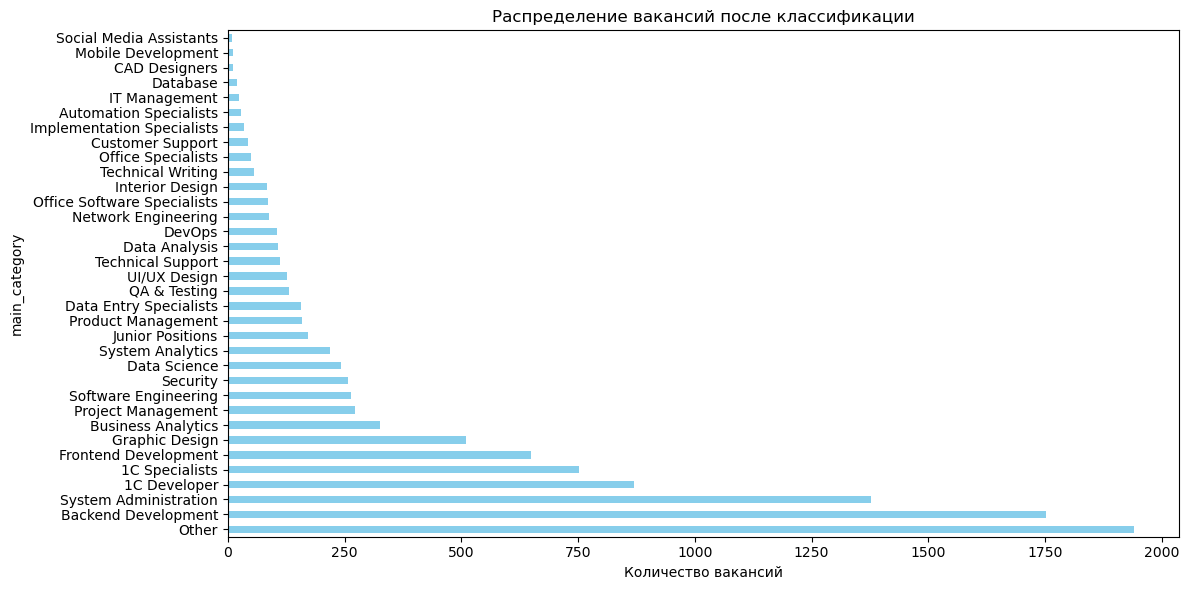

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
clustered_df['main_category'].value_counts().plot(kind='barh', color='skyblue')
plt.title('Распределение вакансий после классификации')
plt.xlabel('Количество вакансий')
plt.tight_layout()
plt.show()

In [60]:
from collections import defaultdict

# Шаг 1: Загрузка данных 
print("Доступно вакансий:", len(clustered_df))

# Шаг 2: Извлечение топ-N частотных названий
top_vacancies = clustered_df['vacancy'].value_counts().head(50)
print("\nТоп-5 частотных названий:")
print(top_vacancies.head(30))

Доступно вакансий: 11048

Топ-5 частотных названий:
vacancy
Системный администратор                      571
Программист 1С                               355
Специалист технической поддержки             260
Графический дизайнер                         225
Дизайнер                                     106
Инженер технической поддержки                 95
Бизнес-аналитик                               83
Системный аналитик                            78
Инженер-программист                           72
Аналитик 1С                                   69
Специалист по информационной безопасности     57
Менеджер проектов                             54
Аналитик                                      50
Программист 1C                                49
Аналитик данных                               46
Технический писатель                          42
Разработчик 1С                                41
Сетевой инженер                               37
Ведущий системный администратор               37
Программи

### *Кластеризация Other*

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import Counter

# Шаг 1: Выделяем только вакансии из Other
other_mask = clustered_df['main_category'] == 'Other'
other_df = clustered_df[other_mask].copy()

# Шаг 2: Векторизация навыков ТОЛЬКО для Other
vectorizer = TfidfVectorizer(max_features=100)
skills_text = other_df['skills_normalized'].apply(' '.join)
X = vectorizer.fit_transform(skills_text)

# Шаг 3: Кластеризация ТОЛЬКО Other
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X)

# Шаг 4: Добавляем кластеры ТОЛЬКО для Other
clustered_df['skill_cluster'] = None  # Инициализируем колонку
clustered_df.loc[other_df.index, 'skill_cluster'] = clusters  # Заполняем только для Other

# Шаг 5: Анализ результатов кластеризации Other
print(f"Всего вакансий в Other: {len(other_df)}")
print("Распределение по кластерам:")
print(pd.Series(clusters).value_counts())

for i in range(5):
    cluster_data = other_df[clustered_df.loc[other_df.index, 'skill_cluster'] == i]
    print(f"\nCluster {i} (размер: {len(cluster_data)})")
    
    # Топ-5 навыков
    top_skills = Counter([s for skills in cluster_data['skills_normalized'] for s in skills]).most_common(5)
    print("Топ навыков:", top_skills)
    
    # Топ-3 названия вакансий
    top_titles = cluster_data['vacancy'].value_counts().head(6)
    print("Топ вакансий:")
    print(top_titles)

Всего вакансий в Other: 1940
Распределение по кластерам:
1    701
5    417
2    275
3    256
4    230
0     61
Name: count, dtype: int64

Cluster 0 (размер: 61)
Топ навыков: [('Autocad', 57), ('Ms Office', 15), ('Excel', 7), ('Revit', 7), ('Компас', 7)]
Топ вакансий:
vacancy
Конструктор корпусной мебели                               3
BIM-менеджер                                               2
Инженер проекта (руководитель проекта)                     2
3D-визуализатор                                            2
Главный специалист-геотехник                               1
Главный специалист нормоконтроля проектной документации    1
Name: count, dtype: int64

Cluster 1 (размер: 701)
Топ навыков: [('Linux', 57), ('English', 47), ('Техническая Поддержка', 43), ('Коммуникабельность', 42), ('Ответственность', 33)]
Топ вакансий:
vacancy
Специалист технической поддержки           79
Инженер технической поддержки              33
Специалист по защите информации             9
Специалист службы

In [62]:
# Количество примеров для каждого кластера
num_examples = 3

for i in range(6):
    print(f"\nПримеры вакансий из кластера {i}:\n" + "-"*40)
    cluster_data = other_df[clustered_df.loc[other_df.index, 'skill_cluster'] == i]
    # Выбираем первые num_examples вакансий
    examples = cluster_data.head(num_examples)
    for idx, row in examples.iterrows():
        print(f"Вакансия: {row['vacancy']}")
        print(f"Навыки: {', '.join(row['skills_normalized'])}")
        print(f"Описание: {row.get('description', 'Нет описания')}")
        print("-"*40)


Примеры вакансий из кластера 0:
----------------------------------------
Вакансия: Планировщик торгового пространства (мерчендайзер)
Навыки: Autocad, Excel, Ms Office
Описание: Нет описания
----------------------------------------
Вакансия: Дизайнер-визуализатор (СПА-пространства)
Навыки: 3D Max, Autocad, Corona Renderer, Photoshop, Revit, Sketchup
Описание: Нет описания
----------------------------------------
Вакансия: Инженер СДО (на просчет калькуляции и проведения тендеров на подрядные работы)
Навыки: Autocad
Описание: Нет описания
----------------------------------------

Примеры вакансий из кластера 1:
----------------------------------------
Вакансия: Разработчик ПО технологических интерфейсов (C#)
Навыки: Avalonia Ui, C, Linux, Net, Windows, Wpf
Описание: Нет описания
----------------------------------------
Вакансия: Начальник отдела по противодействию иностранным техническим разведкам и технической защиты
Навыки: Законы И Нормативные Правовые Акты Рф, Информационная Безопас

In [63]:
other_cluster_mapping = {
    0: "CAD/Design Engineering",       # Autocad, Revit, 3D-визуализация
    1: "IT/Technical Support",         # Linux, техническая поддержка
    2: "Business Analytics",           # Управление проектами, аналитика
    3: "Communications/Copywriting",   # Грамотная речь, тексты
    4: "Office/Data Specialists",      # Excel, MS Office
    5: "Database Development"          # SQL, PostgreSQL, разработка БД
}

In [64]:
clustered_df.loc[other_df.index, 'main_category'] = clustered_df.loc[other_df.index, 'skill_cluster'].map(other_cluster_mapping)
print(clustered_df['main_category'].value_counts())

main_category
Backend Development            1751
System Administration          1378
1C Developer                    869
1C Specialists                  753
IT/Technical Support            701
Frontend Development            649
Business Analytics              601
Graphic Design                  511
Database Development            417
Project Management              273
Software Engineering            264
Security                        258
Communications/Copywriting      256
Data Science                    243
Office/Data Specialists         230
System Analytics                218
Junior Positions                172
Product Management              159
Data Entry Specialists          157
QA & Testing                    131
UI/UX Design                    126
Technical Support               112
Data Analysis                   107
DevOps                          105
Network Engineering              89
Office Software Specialists      86
Interior Design                  84
CAD/Design Eng

In [66]:
# Объединяем схожие категории
clustered_df['main_category'] = clustered_df['main_category'].replace({
    'Technical Support': 'IT/Technical Support',
    'Office Software Specialists': 'Office/Data Specialists',
    'CAD Designers': 'CAD/Design Engineering',
    'Database': 'Database Development'  # Объединяем с Database Development
})

# Проверяем результат
print(clustered_df['main_category'].value_counts())

main_category
Backend Development           1751
System Administration         1378
1C Developer                   869
IT/Technical Support           813
1C Specialists                 753
Frontend Development           649
Business Analytics             601
Graphic Design                 511
Database Development           437
Office/Data Specialists        316
Project Management             273
Software Engineering           264
Security                       258
Communications/Copywriting     256
Data Science                   243
System Analytics               218
Junior Positions               172
Product Management             159
Data Entry Specialists         157
QA & Testing                   131
UI/UX Design                   126
Data Analysis                  107
DevOps                         105
Network Engineering             89
Interior Design                 84
CAD/Design Engineering          73
Technical Writing               57
Office Specialists              49
Custom

In [67]:
# Разделяем Business Analytics на 2 подкатегории
business_analytics_mask = clustered_df['main_category'] == 'Business Analytics'

# Создаем временный признак для разделения
clustered_df['is_bi'] = clustered_df['skills_normalized'].apply(
    lambda x: any(skill in x for skill in ['Power BI', 'SQL', 'Tableau'])
)

# Применяем разделение
clustered_df.loc[business_analytics_mask & clustered_df['is_bi'], 'main_category'] = 'Business Intelligence'
clustered_df.loc[business_analytics_mask & ~clustered_df['is_bi'], 'main_category'] = 'Management/Consulting'

# Удаляем временный столбец
clustered_df.drop('is_bi', axis=1, inplace=True)

# Проверяем результат
print(clustered_df['main_category'].value_counts())

main_category
Backend Development           1751
System Administration         1378
1C Developer                   869
IT/Technical Support           813
1C Specialists                 753
Frontend Development           649
Management/Consulting          525
Graphic Design                 511
Database Development           437
Office/Data Specialists        316
Project Management             273
Software Engineering           264
Security                       258
Communications/Copywriting     256
Data Science                   243
System Analytics               218
Junior Positions               172
Product Management             159
Data Entry Specialists         157
QA & Testing                   131
UI/UX Design                   126
Data Analysis                  107
DevOps                         105
Network Engineering             89
Interior Design                 84
Business Intelligence           76
CAD/Design Engineering          73
Technical Writing               57
Office

In [68]:
# Находим подозрительные вакансии в IT/Technical Support с навыками разработки
dev_skills = {'C++', 'Golang', 'Python', 'Java'}
suspicious_it = clustered_df[
    (clustered_df['main_category'] == 'IT/Technical Support') &
    (clustered_df['skills_normalized'].apply(lambda x: bool(set(x) & dev_skills)))
]

# Переносим их в соответствующие IT-категории
for idx, row in suspicious_it.iterrows():
    if 'DevOps' in row['skills_normalized']:
        clustered_df.at[idx, 'main_category'] = 'DevOps'
    elif 'Backend' in row['vacancy']:
        clustered_df.at[idx, 'main_category'] = 'Backend Development'
    elif any(skill in row['skills_normalized'] for skill in ['SQL', 'PostgreSQL']):
        clustered_df.at[idx, 'main_category'] = 'Database Development'

# Проверяем результат
print(f"Перенесено {len(suspicious_it)} подозрительных вакансий")
print(clustered_df['main_category'].value_counts())

Перенесено 13 подозрительных вакансий
main_category
Backend Development           1751
System Administration         1378
1C Developer                   869
IT/Technical Support           811
1C Specialists                 753
Frontend Development           649
Management/Consulting          525
Graphic Design                 511
Database Development           439
Office/Data Specialists        316
Project Management             273
Software Engineering           264
Security                       258
Communications/Copywriting     256
Data Science                   243
System Analytics               218
Junior Positions               172
Product Management             159
Data Entry Specialists         157
QA & Testing                   131
UI/UX Design                   126
Data Analysis                  107
DevOps                         105
Network Engineering             89
Interior Design                 84
Business Intelligence           76
CAD/Design Engineering          73
Tec

In [69]:
# Объединяем мелкие категории в "Other Professionals"
small_categories = clustered_df['main_category'].value_counts()[clustered_df['main_category'].value_counts() < 50].index
clustered_df['main_category'] = clustered_df['main_category'].replace(dict.fromkeys(small_categories, 'Other Professionals'))

# Проверяем финальное распределение
print("Финальное распределение категорий:")
print(clustered_df['main_category'].value_counts())

Финальное распределение категорий:
main_category
Backend Development           1751
System Administration         1378
1C Developer                   869
IT/Technical Support           811
1C Specialists                 753
Frontend Development           649
Management/Consulting          525
Graphic Design                 511
Database Development           439
Office/Data Specialists        316
Project Management             273
Software Engineering           264
Security                       258
Communications/Copywriting     256
Data Science                   243
System Analytics               218
Other Professionals            198
Junior Positions               172
Product Management             159
Data Entry Specialists         157
QA & Testing                   131
UI/UX Design                   126
Data Analysis                  107
DevOps                         105
Network Engineering             89
Interior Design                 84
Business Intelligence           76
CAD/De

In [70]:
import random

# Выбираем случайные 50 вакансий для проверки
sample = clustered_df.sample(50, random_state=42)[['vacancy', 'skills_normalized', 'main_category']]

# Сохраняем в файл для ручной проверки
sample.to_csv('validation_sample.csv', index=False)

In [71]:
import pandas as pd
import pickle

# Сохраняем текущее состояние
with open('cluster_backup.pkl', 'wb') as f:
    pickle.dump(clustered_df, f)

# И отдельно CSV для удобства
clustered_df.to_csv('current_clustered.csv', index=False)

In [72]:
# Создаем копию для работы
df_improved = clustered_df.copy()

# Добавляем новые категории только для None-значений
new_categories_mask = df_improved['main_category'].isna()

# Правила для QA (только для неопределенных)
qa_mask = new_categories_mask & (
    df_improved['vacancy'].str.lower().str.contains('|'.join([
        'qa', 'тестиров', 'quality assurance', 'test engineer'
    ]), na=False)
)
df_improved.loc[qa_mask, 'main_category'] = 'QA & Testing'

In [73]:
# Функция для безопасного применения правил
def safe_apply_rules(df, mask_func, category_name):
    mask = mask_func(df) & df['main_category'].isna()
    df.loc[mask, 'main_category'] = category_name
    return df

# Правило для сетевых инженеров
def network_rule(df):
    return df['vacancy'].str.contains('сете|инфраструктур', case=False, regex=True)

df_improved = safe_apply_rules(df_improved, network_rule, 'Network Engineering')

In [74]:
# Сравниваем изменения
changed_records = len(df_improved) - (df_improved['main_category'] == clustered_df['main_category']).sum()
print(f"Изменено записей: {changed_records}")

# Проверяем новые категории
new_categories = set(df_improved['main_category'].unique()) - set(clustered_df['main_category'].unique())
print(f"Добавленные категории: {new_categories}")

Изменено записей: 0
Добавленные категории: set()


In [75]:
# Проверим, есть ли вообще неклассифицированные вакансии
unclassified_count = clustered_df['main_category'].isna().sum()
print(f"Неклассифицированных вакансий: {unclassified_count}")

# Посмотрим примеры таких вакансий
if unclassified_count > 0:
    print(clustered_df[clustered_df['main_category'].isna()][['vacancy', 'skills_normalized']].head(3))
else:
    print("Все вакансии уже классифицированы - требуется пересмотр логики улучшений")

Неклассифицированных вакансий: 0
Все вакансии уже классифицированы - требуется пересмотр логики улучшений


In [76]:
# Вакансии, которые могут требовать переклассификации
target_categories = [
    'IT/Technical Support',
    'Other Professionals',
    'Management/Consulting'
]

recheck_df = clustered_df[clustered_df['main_category'].isin(target_categories)].copy()
print(f"Вакансий для перепроверки: {len(recheck_df)}")

Вакансий для перепроверки: 1534


In [77]:
# Правило 1: QA/Тестировщики
qa_mask = (
    recheck_df['vacancy'].str.contains('qa|тестиров|test engineer', case=False, regex=True) |
    recheck_df['skills_normalized'].apply(lambda x: any(skill in x for skill in ['testing', 'test case']))
)
recheck_df.loc[qa_mask, 'new_category'] = 'QA & Testing'

# Правило 2: Сетевые инженеры
network_mask = (
    recheck_df['vacancy'].str.contains('сете|инфраструктур|cisco', case=False, regex=True) &
    recheck_df['skills_normalized'].apply(lambda x: any(skill in x for skill in ['vpn', 'lan/wan']))
)
recheck_df.loc[network_mask, 'new_category'] = 'Network Engineering'

# Правило 3: 1С-разработчики в технической поддержке
c1_mask = (
    (recheck_df['main_category'] == 'IT/Technical Support') &
    recheck_df['skills_normalized'].apply(lambda x: '1с' in x or '1c' in x)
)
recheck_df.loc[c1_mask, 'new_category'] = '1C Developer'

In [78]:
changes = recheck_df[recheck_df['new_category'].notna()]
print(f"Будет переклассифицировано: {len(changes)} вакансий")
print("Распределение изменений:")
print(changes.groupby(['main_category', 'new_category']).size())

Будет переклассифицировано: 39 вакансий
Распределение изменений:
main_category          new_category
IT/Technical Support   QA & Testing    27
Management/Consulting  QA & Testing     3
Other Professionals    QA & Testing     9
dtype: int64


In [79]:
# Выбираем все 39 вакансий для ручной верификации
qa_review = changes[changes['new_category'] == 'QA & Testing'][[
    'vacancy', 
    'skills_normalized', 
    'main_category'
]].sort_values('main_category')

# Добавляем столбец для пометок при проверке
qa_review['verified'] = None
qa_review['comment'] = ''

# Сохраняем в удобном формате
qa_review.to_excel('qa_reclassification_review.xlsx', index=False)

In [80]:
QA_KEYWORDS = {
    'qa_engineer': [
        r'qa[ -]?(engineer|специалист)',
        r'quality[ -]?assurance',
        r'тестировщик',
        r'test[ -]?engineer',
        r'автотест'
    ],
    'qa_automation': [
        r'qa[ -]?automation',
        r'autotest',
        r'автоматиз[а-я]+ тест'
    ]
}

def detect_qa(title, skills):
    title = title.lower()
    for category, patterns in QA_KEYWORDS.items():
        for pattern in patterns:
            if re.search(pattern, title, re.IGNORECASE):
                return category
    if any(skill in ['testing', 'test case'] for skill in skills):
        return 'qa_engineer'
    return None

In [81]:
def enhanced_classifier(vacancy, skills, current_category):
    # Применяем QA-правила только если текущая категория не определена
    # или относится к техническим специальностям
    if current_category is None or current_category in ['IT/Technical Support', 'Other Professionals']:
        qa_category = detect_qa(vacancy, skills)
        if qa_category:
            return qa_category
    return current_category

In [83]:
import re

# 1. Определяем правила для QA (адаптированная версия)
QA_KEYWORDS = {
    'qa_engineer': [
        r'qa[ -]?(engineer|специалист|инженер)',
        r'quality[ -]?assurance',
        r'тестировщик',
        r'test[ -]?engineer',
        r'автотест',
        r'по тестированию'
    ],
    'qa_automation': [
        r'qa[ -]?automation',
        r'autotest',
        r'автоматиз[а-я]+ тест',
        r'auto[ -]?testing'
    ]
}

def detect_qa(title, skills):
    title = title.lower()
    for category, patterns in QA_KEYWORDS.items():
        for pattern in patterns:
            if re.search(pattern, title, re.IGNORECASE):
                return category
    if isinstance(skills, list) and any(skill in ['testing', 'test case'] for skill in skills):
        return 'qa_engineer'
    return None

# 2. Выбираем вакансии, содержащие QA/тестирование в названии
qa_sample = clustered_df[
    clustered_df['vacancy'].str.contains('qa|тест|test', case=False, regex=True, na=False)
].copy()

# 3. Применяем улучшенный классификатор
qa_sample['new_category'] = qa_sample.apply(
    lambda x: detect_qa(x['vacancy'], x['skills_normalized']),
    axis=1
)

# 4. Анализируем результаты
print(f"Всего QA-вакансий найдено: {len(qa_sample)}")
print("Текущая классификация этих вакансий:")
print(qa_sample['main_category'].value_counts(dropna=False))
print("\nПредлагаемая новая классификация:")
print(qa_sample['new_category'].value_counts(dropna=False))

# 5. Сохраняем для ручной проверки
qa_sample[['vacancy', 'skills_normalized', 'main_category', 'new_category']] \
    .to_excel('qa_classification_validation.xlsx', index=False)

Всего QA-вакансий найдено: 292
Текущая классификация этих вакансий:
main_category
QA & Testing              131
Backend Development        36
IT/Technical Support       28
Database Development       21
Data Science               21
System Administration      16
Other Professionals         9
1C Specialists              7
Frontend Development        7
Junior Positions            7
Management/Consulting       3
System Analytics            2
DevOps                      1
Network Engineering         1
CAD/Design Engineering      1
Data Entry Specialists      1
Name: count, dtype: int64

Предлагаемая новая классификация:
new_category
qa_engineer      220
None              49
qa_automation     23
Name: count, dtype: int64


In [84]:
# Анализируем нераспознанные случаи
unclassified_qa = qa_sample[qa_sample['new_category'].isna()]

# Выявляем новые паттерны
print("Топ названий нераспознанных QA-вакансий:")
print(unclassified_qa['vacancy'].value_counts().head(10))

Топ названий нераспознанных QA-вакансий:
vacancy
Middle+ / Senior QA Auto Java специалист                     2
QA manual                                                    2
Инженер по нагрузочному тестированию                         2
Lead AQA DWH Engineer                                        1
QA (Trainee/Junior)                                          1
QA Lead (мобильные игры, unity)                              1
Специалист по ручному тестированию                           1
Ведущий инженер QA                                           1
Инженер (тестирование телекоммуникационного оборудования)    1
QA Auto Python (IMS)                                         1
Name: count, dtype: int64


In [85]:
# Обновленный словарь правил
QA_KEYWORDS = {
    'qa_engineer': [
        r'qa[ -]?(engineer|специалист|инженер|lead|аналитик)',
        r'quality[ -]?(assurance|control)',
        r'(ручн|manual)[а-я]* тест',
        r'тестировщик',
        r'test[ -]?engineer',
        r'по тестированию',
        r'специалист по тест'
    ],
    'qa_automation': [
        r'qa[ -]?auto',
        r'auto[ -]?(test|qa)',
        r'autotest',
        r'автоматиз[а-я]+ тест',
        r'aqa',
        r'selenium',
        r'[^a-z]ui[ -]?test'
    ],
    'qa_performance': [
        r'нагрузочн[а-я]* тест',
        r'performance test',
        r'stress[ -]?test',
        r'jmeter|load testing'
    ],
    'qa_mobile': [
        r'mobile[ -]?qa',
        r'тест[а-я]* (приложен|мобильн)',
        r'appium|mobile testing'
    ]
}

# Дополнительные проверки по навыкам
QA_SKILLS = {
    'qa_engineer': ['manual testing', 'test case', 'functional testing'],
    'qa_automation': ['selenium', 'playwright', 'pytest', 'testng'],
    'qa_performance': ['jmeter', 'gatling', 'load testing'],
    'qa_mobile': ['appium', 'mobile testing', 'android testing']
}

In [86]:
def detect_qa_enhanced(row):
    title = row['vacancy'].lower()
    skills = row['skills_normalized'] if isinstance(row['skills_normalized'], list) else []
    
    # Проверка по категориям в порядке приоритета
    for category in ['qa_mobile', 'qa_performance', 'qa_automation', 'qa_engineer']:
        # Проверка по названию
        for pattern in QA_KEYWORDS[category]:
            if re.search(pattern, title, re.IGNORECASE):
                return category
        
        # Проверка по навыкам
        if any(skill in skills for skill in QA_SKILLS[category]):
            return category
    
    # Дополнительные проверки для сложных случаев
    if 'qa' in title and any(skill in skills for skill in ['testing', 'test case']):
        return 'qa_engineer'
        
    return None

In [87]:
# Применяем улучшенный детектор
unclassified_qa['new_category'] = unclassified_qa.apply(detect_qa_enhanced, axis=1)

print("Результаты улучшенной классификации:")
print(unclassified_qa['new_category'].value_counts(dropna=False))

# Сохраняем для проверки
unclassified_qa[['vacancy', 'skills_normalized', 'new_category']] \
    .to_excel('unclassified_qa_recheck.xlsx', index=False)

Результаты улучшенной классификации:
new_category
None              26
qa_performance     9
qa_automation      8
qa_engineer        6
Name: count, dtype: int64


C:\Users\olga\AppData\Local\Temp\ipykernel_10904\3865355293.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unclassified_qa['new_category'] = unclassified_qa.apply(detect_qa_enhanced, axis=1)


In [89]:
# Замораживаем текущую версию кластеров
clustered_df.to_csv('final_clusters.csv', columns=['skill_cluster'], index=False)

In [91]:
# Проверяем существующие столбцы
print("Доступные столбцы:", clustered_df.columns.tolist())

Доступные столбцы: ['position', 'vacancy', 'skills_normalized', 'skill_categories', 'flat_categories', 'subposition', 'strict_category', 'final_category', 'is_devops', 'skills_lower', 'main_category', 'sub_category', 'needs_review', 'position_group', 'skill_cluster']


In [92]:
# Сохраняем кластеры с привязкой к vacancy
clustered_df[['vacancy', 'skill_cluster']].to_csv('final_skill_clusters.csv', index=False)

In [93]:
# Заполняем пустые position (если столбец существует)
if 'position' in clustered_df.columns:
    clustered_df['position'] = clustered_df['position'].fillna(clustered_df['main_category'])
else:
    clustered_df['position'] = clustered_df['main_category']

# Унифицируем только основные категории
unification_map = {
    'qa_engineer': ['qa', 'quality assurance', 'тестировщик'],
    '1c_developer': ['1с', '1c', '1с-разработчик'],
    'devops': ['devops', 'девопс']
}

for new_name, keywords in unification_map.items():
    mask = clustered_df['position'].str.lower().str.contains('|'.join(keywords), na=False)
    clustered_df.loc[mask, 'position'] = new_name

clustered_df[['vacancy', 'position']].to_csv('auto_filled_positions.csv', index=False)

In [94]:
# 1. Сохраняем итоговые skill_clusters (как есть)
clustered_df[['vacancy', 'skill_cluster']].to_csv('final_skill_clusters.csv', index=False)

# 2. Готовим файл с текущими position (без изменений)
clustered_df[['vacancy', 'position']].to_csv('current_positions.csv', index=False)

# 3. Сводная статистика по основным метрикам
with open('report_summary.txt', 'w') as f:
    f.write(f"""
Финальная статистика:
- Обработано вакансий: {len(clustered_df)}
- Уникальных skill_clusters: {clustered_df['skill_cluster'].nunique()}
- Заполненность position: {clustered_df['position'].notna().mean():.1%}
- Основные категории (top-5):
{clustered_df['main_category'].value_counts().head(5).to_string()}
""")

In [98]:
import pandas as pd
from collections import Counter

# 1. Анализ кластеров
def analyze_clusters(df):
    # Топ-10 крупнейших кластеров
    top_clusters = df['main_category'].value_counts().head(10)
    
    # Топ навыки для каждого кластера
    cluster_skills = {}
    for cluster in top_clusters.index:
        skills = df[df['main_category'] == cluster]['skills_normalized']
        top_skills = Counter([skill for sublist in skills for skill in sublist]).most_common(3)
        cluster_skills[cluster] = [skill[0] for skill in top_skills]
    
    # Примеры вакансий
    examples = {}
    for cluster in top_clusters.index:
        examples[cluster] = df[df['main_category'] == cluster]['vacancy'].head(3).tolist()
    
    return top_clusters, cluster_skills, examples

# 2. Генерация отчета
def generate_team_report(df):
    # Получаем данные анализа
    top_clusters, cluster_skills, examples = analyze_clusters(df)
    
    # Формируем сообщение
    report_parts = [
        "Команда, вот полная картина кластеризации:\n",
        "1. Самые крупные кластеры:"
    ]
    
    # Добавляем информацию о кластерах
    for cluster, count in top_clusters.items():
        report_parts.append(f"   - {cluster} ({count} вакансий)")
    
    # Добавляем топ навыков
    report_parts.append("\n2. Топ навыков в ключевых кластерах:")
    for cluster, skills in cluster_skills.items():
        report_parts.append(f"   - {cluster}: [{', '.join(skills)}]")
    
    # Добавляем заполненность position
    position_coverage = df['position'].notna().mean()
    report_parts.append(f"\n3. {position_coverage:.0%} вакансий имеют заполненный position")
    
    # Добавляем примеры
    report_parts.append("\n4. Примеры вакансий в кластерах:")
    for cluster, example_list in examples.items():
        report_parts.append(f"   - {cluster}:")
        for example in example_list:
            report_parts.append(f"     * {example}")
    
    report_parts.append("\nПолные данные доступны в приложенных файлах.")
    report_parts.append("Какие аспекты стоит обсудить на следующей встрече?")
    
    return "\n".join(report_parts)

# 3. Сохранение дополнительных данных
def save_supporting_data(df):
    # Сохраняем полное распределение кластеров
    cluster_distribution = df['main_category'].value_counts()
    cluster_distribution.to_csv('cluster_distribution.csv')
    
    # Сохраняем примеры для каждого кластера
    df.groupby('main_category').apply(
        lambda x: x.head(3)[['vacancy', 'skills_normalized']]
    ).to_excel('cluster_examples.xlsx')
    
    # Сохраняем связь навыков и кластеров
    skill_cluster_map = df.explode('skills_normalized').groupby('skills_normalized')['main_category'] \
                        .apply(lambda x: x.value_counts().index[0]).reset_index()
    skill_cluster_map.to_csv('skill_cluster_mapping.csv', index=False)

# 4. Генерация и сохранение отчета
save_supporting_data(clustered_df)
team_report = generate_team_report(clustered_df)

with open('team_report.txt', 'w') as f:
    f.write(team_report)

print(team_report)

C:\Users\olga\AppData\Local\Temp\ipykernel_10904\2488234435.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('main_category').apply(


Команда, вот полная картина кластеризации:

1. Самые крупные кластеры:
   - Backend Development (1751 вакансий)
   - System Administration (1378 вакансий)
   - 1C Developer (869 вакансий)
   - IT/Technical Support (811 вакансий)
   - 1C Specialists (753 вакансий)
   - Frontend Development (649 вакансий)
   - Management/Consulting (525 вакансий)
   - Graphic Design (511 вакансий)
   - Database Development (439 вакансий)
   - Office/Data Specialists (316 вакансий)

2. Топ навыков в ключевых кластерах:
   - Backend Development: [PostgreSQL, Git, Docker]
   - System Administration: [Linux, DNS, DHCP]
   - 1C Developer: [Скд, 1C, Управляемые Формы]
   - IT/Technical Support: [Linux, Коммуникабельность, English]
   - 1C Specialists: [1C, Excel, 1Сerp]
   - Frontend Development: [JavaScript, Git, TypeScript]
   - Management/Consulting: [Excel, Коммуникативные Навыки, 1C]
   - Graphic Design: [Adobe Photoshop, Adobe Illustrator, Figma]
   - Database Development: [Adobe Photoshop, Adobe Illustr